##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

   16384/84125825 [..............................] - ETA: 0s

   24576/84125825 [..............................] - ETA: 8:34

   57344/84125825 [..............................] - ETA: 7:30

   90112/84125825 [..............................] - ETA: 7:06

  122880/84125825 [..............................] - ETA: 6:54

  172032/84125825 [..............................] - ETA: 6:09

  221184/84125825 [..............................] - ETA: 5:45

  303104/84125825 [..............................] - ETA: 4:53

  401408/84125825 [..............................] - ETA: 4:12

  516096/84125825 [..............................] - ETA: 3:40

  679936/84125825 [..............................] - ETA: 3:05

  860160/84125825 [..............................] - ETA: 2:40

 1089536/84125825 [..............................] - ETA: 2:17

 1368064/84125825 [..............................] - ETA: 1:58

 1728512/84125825 [..............................] - ETA: 1:40

 2252800/84125825 [..............................] - ETA: 1:22

 2957312/84125825 [>.............................] - ETA: 1:06

 3842048/84125825 [>.............................] - ETA: 53s 

 4907008/84125825 [>.............................] - ETA: 43s

 6348800/84125825 [=>............................] - ETA: 33s

 6365184/84125825 [=>............................] - ETA: 34s

 8249344/84125825 [=>............................] - ETA: 27s

10461184/84125825 [==>...........................] - ETA: 21s

10641408/84125825 [==>...........................] - ETA: 21s

13000704/84125825 [===>..........................] - ETA: 17s

13459456/84125825 [===>..........................] - ETA: 17s

16048128/84125825 [====>.........................] - ETA: 14s

16588800/84125825 [====>.........................] - ETA: 14s

18735104/84125825 [=====>........................] - ETA: 12s

19718144/84125825 [======>.......................] - ETA: 11s

21340160/84125825 [======>.......................] - ETA: 10s

22831104/84125825 [=======>......................] - ETA: 9s 

23044096/84125825 [=======>......................] - ETA: 10s

24698880/84125825 [=======>......................] - ETA: 9s 

25976832/84125825 [========>.....................] - ETA: 8s

27353088/84125825 [========>.....................] - ETA: 8s

28729344/84125825 [=========>....................] - ETA: 7s

30531584/84125825 [=========>....................] - ETA: 7s

31842304/84125825 [==========>...................] - ETA: 6s

33316864/84125825 [==========>...................] - ETA: 6s

34529280/84125825 [===========>..................] - ETA: 6s

34988032/84125825 [===========>..................] - ETA: 6s

36544512/84125825 [============>.................] - ETA: 5s

37593088/84125825 [============>.................] - ETA: 5s

38100992/84125825 [============>.................] - ETA: 5s

39706624/84125825 [=============>................] - ETA: 5s

40460288/84125825 [=============>................] - ETA: 4s

41263104/84125825 [=============>................] - ETA: 4s

42999808/84125825 [==============>...............] - ETA: 4s

43769856/84125825 [==============>...............] - ETA: 4s

44736512/84125825 [==============>...............] - ETA: 4s

46161920/84125825 [===============>..............] - ETA: 4s

47079424/84125825 [===============>..............] - ETA: 3s

48816128/84125825 [================>.............] - ETA: 3s

50044928/84125825 [================>.............] - ETA: 3s

50454528/84125825 [================>.............] - ETA: 3s

52060160/84125825 [=================>............] - ETA: 3s

53321728/84125825 [==================>...........] - ETA: 3s

54935552/84125825 [==================>...........] - ETA: 2s

55975936/84125825 [==================>...........] - ETA: 2s

56713216/84125825 [===================>..........] - ETA: 2s

58286080/84125825 [===================>..........] - ETA: 2s

59138048/84125825 [====================>.........] - ETA: 2s

59826176/84125825 [====================>.........] - ETA: 2s

61071360/84125825 [====================>.........] - ETA: 2s

62332928/84125825 [=====================>........] - ETA: 2s

63774720/84125825 [=====================>........] - ETA: 1s

65118208/84125825 [======================>.......] - ETA: 1s

66904064/84125825 [======================>.......] - ETA: 1s

67903488/84125825 [=======================>......] - ETA: 1s

68280320/84125825 [=======================>......] - ETA: 1s

70000640/84125825 [=======================>......] - ETA: 1s

71041024/84125825 [========================>.....] - ETA: 1s

71147520/84125825 [========================>.....] - ETA: 1s

73211904/84125825 [=========================>....] - ETA: 0s

74293248/84125825 [=========================>....] - ETA: 0s

76242944/84125825 [==========================>...] - ETA: 0s

77258752/84125825 [==========================>...] - ETA: 0s

79110144/84125825 [===========================>..] - ETA: 0s

80388096/84125825 [===========================>..] - ETA: 0s

82141184/84125825 [============================>.] - ETA: 0s

83156992/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


84140032/84125825 [==============================] - 7s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2021-12-01 12:17:32.795514: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6749899]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

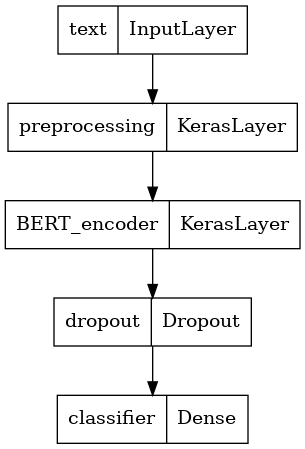

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 55:01 - loss: 0.9679 - binary_accuracy: 0.3438

  2/625 [..............................] - ETA: 1:20 - loss: 0.8367 - binary_accuracy: 0.4062 

  3/625 [..............................] - ETA: 1:18 - loss: 0.7764 - binary_accuracy: 0.4792

  4/625 [..............................] - ETA: 1:16 - loss: 0.7989 - binary_accuracy: 0.4766

  5/625 [..............................] - ETA: 1:15 - loss: 0.8020 - binary_accuracy: 0.4812

  6/625 [..............................] - ETA: 1:14 - loss: 0.8039 - binary_accuracy: 0.4635

  7/625 [..............................] - ETA: 1:14 - loss: 0.8048 - binary_accuracy: 0.4911

  8/625 [..............................] - ETA: 1:14 - loss: 0.8046 - binary_accuracy: 0.4922

  9/625 [..............................] - ETA: 1:13 - loss: 0.7980 - binary_accuracy: 0.5000

 10/625 [..............................] - ETA: 1:13 - loss: 0.7796 - binary_accuracy: 0.5188

 11/625 [..............................] - ETA: 1:13 - loss: 0.7710 - binary_accuracy: 0.5114

 12/625 [..............................] - ETA: 1:12 - loss: 0.7599 - binary_accuracy: 0.5104

 13/625 [..............................] - ETA: 1:12 - loss: 0.7555 - binary_accuracy: 0.5168

 14/625 [..............................] - ETA: 1:12 - loss: 0.7568 - binary_accuracy: 0.5134

 15/625 [..............................] - ETA: 1:12 - loss: 0.7582 - binary_accuracy: 0.5063

 16/625 [..............................] - ETA: 1:12 - loss: 0.7643 - binary_accuracy: 0.5098

 17/625 [..............................] - ETA: 1:12 - loss: 0.7578 - binary_accuracy: 0.5147

 18/625 [..............................] - ETA: 1:11 - loss: 0.7586 - binary_accuracy: 0.5156

 19/625 [..............................] - ETA: 1:11 - loss: 0.7534 - binary_accuracy: 0.5148

 20/625 [..............................] - ETA: 1:11 - loss: 0.7485 - binary_accuracy: 0.5188

 21/625 [>.............................] - ETA: 1:11 - loss: 0.7454 - binary_accuracy: 0.5179

 22/625 [>.............................] - ETA: 1:11 - loss: 0.7405 - binary_accuracy: 0.5227

 23/625 [>.............................] - ETA: 1:11 - loss: 0.7400 - binary_accuracy: 0.5245

 24/625 [>.............................] - ETA: 1:11 - loss: 0.7409 - binary_accuracy: 0.5286

 25/625 [>.............................] - ETA: 1:10 - loss: 0.7390 - binary_accuracy: 0.5275

 26/625 [>.............................] - ETA: 1:10 - loss: 0.7390 - binary_accuracy: 0.5228

 27/625 [>.............................] - ETA: 1:10 - loss: 0.7349 - binary_accuracy: 0.5220

 28/625 [>.............................] - ETA: 1:10 - loss: 0.7335 - binary_accuracy: 0.5246

 29/625 [>.............................] - ETA: 1:10 - loss: 0.7323 - binary_accuracy: 0.5216

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7283 - binary_accuracy: 0.5260

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7270 - binary_accuracy: 0.5312

 32/625 [>.............................] - ETA: 1:09 - loss: 0.7267 - binary_accuracy: 0.5332

 33/625 [>.............................] - ETA: 1:09 - loss: 0.7266 - binary_accuracy: 0.5360

 34/625 [>.............................] - ETA: 1:09 - loss: 0.7260 - binary_accuracy: 0.5358

 35/625 [>.............................] - ETA: 1:09 - loss: 0.7232 - binary_accuracy: 0.5384

 36/625 [>.............................] - ETA: 1:09 - loss: 0.7206 - binary_accuracy: 0.5399

 37/625 [>.............................] - ETA: 1:09 - loss: 0.7182 - binary_accuracy: 0.5397

 38/625 [>.............................] - ETA: 1:09 - loss: 0.7164 - binary_accuracy: 0.5387

 39/625 [>.............................] - ETA: 1:09 - loss: 0.7150 - binary_accuracy: 0.5409

 40/625 [>.............................] - ETA: 1:08 - loss: 0.7140 - binary_accuracy: 0.5398

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7131 - binary_accuracy: 0.5442

 42/625 [=>............................] - ETA: 1:08 - loss: 0.7122 - binary_accuracy: 0.5446

 43/625 [=>............................] - ETA: 1:08 - loss: 0.7111 - binary_accuracy: 0.5458

 44/625 [=>............................] - ETA: 1:08 - loss: 0.7106 - binary_accuracy: 0.5433

 45/625 [=>............................] - ETA: 1:08 - loss: 0.7086 - binary_accuracy: 0.5458

 46/625 [=>............................] - ETA: 1:08 - loss: 0.7066 - binary_accuracy: 0.5482

 47/625 [=>............................] - ETA: 1:08 - loss: 0.7068 - binary_accuracy: 0.5479

 48/625 [=>............................] - ETA: 1:08 - loss: 0.7049 - binary_accuracy: 0.5501

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7053 - binary_accuracy: 0.5497

 50/625 [=>............................] - ETA: 1:07 - loss: 0.7023 - binary_accuracy: 0.5531

 51/625 [=>............................] - ETA: 1:07 - loss: 0.7014 - binary_accuracy: 0.5521

 52/625 [=>............................] - ETA: 1:07 - loss: 0.7014 - binary_accuracy: 0.5505

 53/625 [=>............................] - ETA: 1:07 - loss: 0.7008 - binary_accuracy: 0.5501

 54/625 [=>............................] - ETA: 1:07 - loss: 0.6995 - binary_accuracy: 0.5509

 55/625 [=>............................] - ETA: 1:07 - loss: 0.6994 - binary_accuracy: 0.5511

 56/625 [=>............................] - ETA: 1:07 - loss: 0.6989 - binary_accuracy: 0.5513

 57/625 [=>............................] - ETA: 1:06 - loss: 0.6972 - binary_accuracy: 0.5521

 58/625 [=>............................] - ETA: 1:06 - loss: 0.6970 - binary_accuracy: 0.5490

 59/625 [=>............................] - ETA: 1:06 - loss: 0.6956 - binary_accuracy: 0.5519

 60/625 [=>............................] - ETA: 1:06 - loss: 0.6945 - binary_accuracy: 0.5547

 61/625 [=>............................] - ETA: 1:06 - loss: 0.6927 - binary_accuracy: 0.5574

 62/625 [=>............................] - ETA: 1:06 - loss: 0.6906 - binary_accuracy: 0.5595

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.6897 - binary_accuracy: 0.5605

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.6881 - binary_accuracy: 0.5610

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.6876 - binary_accuracy: 0.5611

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.6862 - binary_accuracy: 0.5630

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.6854 - binary_accuracy: 0.5639

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.6834 - binary_accuracy: 0.5671

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.6813 - binary_accuracy: 0.5684

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.6807 - binary_accuracy: 0.5692

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.6797 - binary_accuracy: 0.5709

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.6789 - binary_accuracy: 0.5712

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.6773 - binary_accuracy: 0.5715

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.6756 - binary_accuracy: 0.5705

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.6750 - binary_accuracy: 0.5688

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.6737 - binary_accuracy: 0.5687

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.6729 - binary_accuracy: 0.5686

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.6719 - binary_accuracy: 0.5701

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.6709 - binary_accuracy: 0.5720

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.6700 - binary_accuracy: 0.5727

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.6694 - binary_accuracy: 0.5733

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.6681 - binary_accuracy: 0.5755

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.6673 - binary_accuracy: 0.5772

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.6657 - binary_accuracy: 0.5789

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.6665 - binary_accuracy: 0.5790

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.6652 - binary_accuracy: 0.5807

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.6641 - binary_accuracy: 0.5815

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.6640 - binary_accuracy: 0.5820

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.6637 - binary_accuracy: 0.5822

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.6635 - binary_accuracy: 0.5813

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.6631 - binary_accuracy: 0.5834

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.6632 - binary_accuracy: 0.5846

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.6624 - binary_accuracy: 0.5857

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.6621 - binary_accuracy: 0.5871

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.6625 - binary_accuracy: 0.5868

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.6611 - binary_accuracy: 0.5889

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.6601 - binary_accuracy: 0.5892

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.6599 - binary_accuracy: 0.5893

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.6589 - binary_accuracy: 0.5906

100/625 [===>..........................] - ETA: 1:01 - loss: 0.6581 - binary_accuracy: 0.5913

101/625 [===>..........................] - ETA: 1:01 - loss: 0.6581 - binary_accuracy: 0.5913

102/625 [===>..........................] - ETA: 1:01 - loss: 0.6573 - binary_accuracy: 0.5919

103/625 [===>..........................] - ETA: 1:01 - loss: 0.6556 - binary_accuracy: 0.5931

104/625 [===>..........................] - ETA: 1:01 - loss: 0.6544 - binary_accuracy: 0.5950

105/625 [====>.........................] - ETA: 1:01 - loss: 0.6535 - binary_accuracy: 0.5952

106/625 [====>.........................] - ETA: 1:01 - loss: 0.6529 - binary_accuracy: 0.5955

107/625 [====>.........................] - ETA: 1:01 - loss: 0.6522 - binary_accuracy: 0.5967

108/625 [====>.........................] - ETA: 1:00 - loss: 0.6504 - binary_accuracy: 0.5981

109/625 [====>.........................] - ETA: 1:00 - loss: 0.6500 - binary_accuracy: 0.5975

110/625 [====>.........................] - ETA: 1:00 - loss: 0.6496 - binary_accuracy: 0.5983

111/625 [====>.........................] - ETA: 1:00 - loss: 0.6489 - binary_accuracy: 0.5980

112/625 [====>.........................] - ETA: 1:00 - loss: 0.6481 - binary_accuracy: 0.5979

113/625 [====>.........................] - ETA: 1:00 - loss: 0.6477 - binary_accuracy: 0.5985

114/625 [====>.........................] - ETA: 1:00 - loss: 0.6479 - binary_accuracy: 0.5984

115/625 [====>.........................] - ETA: 1:00 - loss: 0.6465 - binary_accuracy: 0.5997

116/625 [====>.........................] - ETA: 1:00 - loss: 0.6471 - binary_accuracy: 0.5991

117/625 [====>.........................] - ETA: 59s - loss: 0.6473 - binary_accuracy: 0.5996 

118/625 [====>.........................] - ETA: 59s - loss: 0.6463 - binary_accuracy: 0.6006

119/625 [====>.........................] - ETA: 59s - loss: 0.6449 - binary_accuracy: 0.6027

120/625 [====>.........................] - ETA: 59s - loss: 0.6447 - binary_accuracy: 0.6042

121/625 [====>.........................] - ETA: 59s - loss: 0.6444 - binary_accuracy: 0.6033

122/625 [====>.........................] - ETA: 59s - loss: 0.6437 - binary_accuracy: 0.6045

123/625 [====>.........................] - ETA: 59s - loss: 0.6437 - binary_accuracy: 0.6042

124/625 [====>.........................] - ETA: 59s - loss: 0.6421 - binary_accuracy: 0.6058

125/625 [=====>........................] - ETA: 59s - loss: 0.6409 - binary_accuracy: 0.6068

126/625 [=====>........................] - ETA: 58s - loss: 0.6403 - binary_accuracy: 0.6074

127/625 [=====>........................] - ETA: 58s - loss: 0.6386 - binary_accuracy: 0.6095

128/625 [=====>........................] - ETA: 58s - loss: 0.6371 - binary_accuracy: 0.6116

129/625 [=====>........................] - ETA: 58s - loss: 0.6367 - binary_accuracy: 0.6129

130/625 [=====>........................] - ETA: 58s - loss: 0.6365 - binary_accuracy: 0.6127

131/625 [=====>........................] - ETA: 58s - loss: 0.6354 - binary_accuracy: 0.6135

132/625 [=====>........................] - ETA: 58s - loss: 0.6346 - binary_accuracy: 0.6139

133/625 [=====>........................] - ETA: 58s - loss: 0.6332 - binary_accuracy: 0.6151

134/625 [=====>........................] - ETA: 57s - loss: 0.6328 - binary_accuracy: 0.6157

135/625 [=====>........................] - ETA: 57s - loss: 0.6318 - binary_accuracy: 0.6171

136/625 [=====>........................] - ETA: 57s - loss: 0.6299 - binary_accuracy: 0.6186

137/625 [=====>........................] - ETA: 57s - loss: 0.6283 - binary_accuracy: 0.6200

138/625 [=====>........................] - ETA: 57s - loss: 0.6274 - binary_accuracy: 0.6202

139/625 [=====>........................] - ETA: 57s - loss: 0.6255 - binary_accuracy: 0.6216

140/625 [=====>........................] - ETA: 57s - loss: 0.6265 - binary_accuracy: 0.6219

141/625 [=====>........................] - ETA: 57s - loss: 0.6251 - binary_accuracy: 0.6228

142/625 [=====>........................] - ETA: 56s - loss: 0.6242 - binary_accuracy: 0.6239

143/625 [=====>........................] - ETA: 56s - loss: 0.6235 - binary_accuracy: 0.6250

144/625 [=====>........................] - ETA: 56s - loss: 0.6228 - binary_accuracy: 0.6257

145/625 [=====>........................] - ETA: 56s - loss: 0.6224 - binary_accuracy: 0.6259

146/625 [======>.......................] - ETA: 56s - loss: 0.6212 - binary_accuracy: 0.6274

147/625 [======>.......................] - ETA: 56s - loss: 0.6203 - binary_accuracy: 0.6284

148/625 [======>.......................] - ETA: 56s - loss: 0.6195 - binary_accuracy: 0.6294

149/625 [======>.......................] - ETA: 56s - loss: 0.6184 - binary_accuracy: 0.6302

150/625 [======>.......................] - ETA: 56s - loss: 0.6191 - binary_accuracy: 0.6296

151/625 [======>.......................] - ETA: 55s - loss: 0.6178 - binary_accuracy: 0.6306

152/625 [======>.......................] - ETA: 55s - loss: 0.6174 - binary_accuracy: 0.6316

153/625 [======>.......................] - ETA: 55s - loss: 0.6167 - binary_accuracy: 0.6315

154/625 [======>.......................] - ETA: 55s - loss: 0.6162 - binary_accuracy: 0.6321

155/625 [======>.......................] - ETA: 55s - loss: 0.6154 - binary_accuracy: 0.6325

156/625 [======>.......................] - ETA: 55s - loss: 0.6141 - binary_accuracy: 0.6334

157/625 [======>.......................] - ETA: 55s - loss: 0.6141 - binary_accuracy: 0.6334

158/625 [======>.......................] - ETA: 55s - loss: 0.6136 - binary_accuracy: 0.6339

159/625 [======>.......................] - ETA: 54s - loss: 0.6129 - binary_accuracy: 0.6352

160/625 [======>.......................] - ETA: 54s - loss: 0.6122 - binary_accuracy: 0.6359

161/625 [======>.......................] - ETA: 54s - loss: 0.6109 - binary_accuracy: 0.6372

162/625 [======>.......................] - ETA: 54s - loss: 0.6103 - binary_accuracy: 0.6377

163/625 [======>.......................] - ETA: 54s - loss: 0.6088 - binary_accuracy: 0.6388

164/625 [======>.......................] - ETA: 54s - loss: 0.6090 - binary_accuracy: 0.6387

165/625 [======>.......................] - ETA: 54s - loss: 0.6080 - binary_accuracy: 0.6400

166/625 [======>.......................] - ETA: 54s - loss: 0.6075 - binary_accuracy: 0.6401

167/625 [=======>......................] - ETA: 53s - loss: 0.6069 - binary_accuracy: 0.6402

168/625 [=======>......................] - ETA: 53s - loss: 0.6068 - binary_accuracy: 0.6406

169/625 [=======>......................] - ETA: 53s - loss: 0.6057 - binary_accuracy: 0.6416

170/625 [=======>......................] - ETA: 53s - loss: 0.6050 - binary_accuracy: 0.6425

171/625 [=======>......................] - ETA: 53s - loss: 0.6044 - binary_accuracy: 0.6429

172/625 [=======>......................] - ETA: 53s - loss: 0.6032 - binary_accuracy: 0.6437

173/625 [=======>......................] - ETA: 53s - loss: 0.6025 - binary_accuracy: 0.6447

174/625 [=======>......................] - ETA: 53s - loss: 0.6011 - binary_accuracy: 0.6460

175/625 [=======>......................] - ETA: 53s - loss: 0.5999 - binary_accuracy: 0.6470

176/625 [=======>......................] - ETA: 52s - loss: 0.5998 - binary_accuracy: 0.6474

177/625 [=======>......................] - ETA: 52s - loss: 0.5993 - binary_accuracy: 0.6474

178/625 [=======>......................] - ETA: 52s - loss: 0.5989 - binary_accuracy: 0.6478

179/625 [=======>......................] - ETA: 52s - loss: 0.5981 - binary_accuracy: 0.6480

180/625 [=======>......................] - ETA: 52s - loss: 0.5975 - binary_accuracy: 0.6483

181/625 [=======>......................] - ETA: 52s - loss: 0.5967 - binary_accuracy: 0.6488

182/625 [=======>......................] - ETA: 52s - loss: 0.5964 - binary_accuracy: 0.6492

183/625 [=======>......................] - ETA: 52s - loss: 0.5962 - binary_accuracy: 0.6498

184/625 [=======>......................] - ETA: 51s - loss: 0.5957 - binary_accuracy: 0.6501

185/625 [=======>......................] - ETA: 51s - loss: 0.5941 - binary_accuracy: 0.6512

186/625 [=======>......................] - ETA: 51s - loss: 0.5930 - binary_accuracy: 0.6520

187/625 [=======>......................] - ETA: 51s - loss: 0.5920 - binary_accuracy: 0.6526

188/625 [========>.....................] - ETA: 51s - loss: 0.5907 - binary_accuracy: 0.6539

189/625 [========>.....................] - ETA: 51s - loss: 0.5893 - binary_accuracy: 0.6553

190/625 [========>.....................] - ETA: 51s - loss: 0.5895 - binary_accuracy: 0.6554

191/625 [========>.....................] - ETA: 51s - loss: 0.5885 - binary_accuracy: 0.6562

192/625 [========>.....................] - ETA: 51s - loss: 0.5876 - binary_accuracy: 0.6569

193/625 [========>.....................] - ETA: 50s - loss: 0.5871 - binary_accuracy: 0.6571

194/625 [========>.....................] - ETA: 50s - loss: 0.5868 - binary_accuracy: 0.6575

195/625 [========>.....................] - ETA: 50s - loss: 0.5862 - binary_accuracy: 0.6580

196/625 [========>.....................] - ETA: 50s - loss: 0.5873 - binary_accuracy: 0.6577

197/625 [========>.....................] - ETA: 50s - loss: 0.5870 - binary_accuracy: 0.6582

198/625 [========>.....................] - ETA: 50s - loss: 0.5864 - binary_accuracy: 0.6586

199/625 [========>.....................] - ETA: 50s - loss: 0.5867 - binary_accuracy: 0.6584

200/625 [========>.....................] - ETA: 50s - loss: 0.5853 - binary_accuracy: 0.6594

201/625 [========>.....................] - ETA: 49s - loss: 0.5859 - binary_accuracy: 0.6594

202/625 [========>.....................] - ETA: 49s - loss: 0.5845 - binary_accuracy: 0.6603

203/625 [========>.....................] - ETA: 49s - loss: 0.5846 - binary_accuracy: 0.6603

204/625 [========>.....................] - ETA: 49s - loss: 0.5840 - binary_accuracy: 0.6613

205/625 [========>.....................] - ETA: 49s - loss: 0.5835 - binary_accuracy: 0.6620

206/625 [========>.....................] - ETA: 49s - loss: 0.5828 - binary_accuracy: 0.6628

207/625 [========>.....................] - ETA: 49s - loss: 0.5830 - binary_accuracy: 0.6632

208/625 [========>.....................] - ETA: 49s - loss: 0.5827 - binary_accuracy: 0.6635

209/625 [=========>....................] - ETA: 48s - loss: 0.5819 - binary_accuracy: 0.6642

210/625 [=========>....................] - ETA: 48s - loss: 0.5815 - binary_accuracy: 0.6646

211/625 [=========>....................] - ETA: 48s - loss: 0.5804 - binary_accuracy: 0.6656

212/625 [=========>....................] - ETA: 48s - loss: 0.5801 - binary_accuracy: 0.6661

213/625 [=========>....................] - ETA: 48s - loss: 0.5793 - binary_accuracy: 0.6667

214/625 [=========>....................] - ETA: 48s - loss: 0.5785 - binary_accuracy: 0.6671

215/625 [=========>....................] - ETA: 48s - loss: 0.5786 - binary_accuracy: 0.6672

216/625 [=========>....................] - ETA: 48s - loss: 0.5784 - binary_accuracy: 0.6672

217/625 [=========>....................] - ETA: 48s - loss: 0.5778 - binary_accuracy: 0.6681

218/625 [=========>....................] - ETA: 47s - loss: 0.5766 - binary_accuracy: 0.6687

219/625 [=========>....................] - ETA: 47s - loss: 0.5765 - binary_accuracy: 0.6688

220/625 [=========>....................] - ETA: 47s - loss: 0.5762 - binary_accuracy: 0.6689

221/625 [=========>....................] - ETA: 47s - loss: 0.5756 - binary_accuracy: 0.6694

222/625 [=========>....................] - ETA: 47s - loss: 0.5749 - binary_accuracy: 0.6698

223/625 [=========>....................] - ETA: 47s - loss: 0.5745 - binary_accuracy: 0.6703

224/625 [=========>....................] - ETA: 47s - loss: 0.5752 - binary_accuracy: 0.6701

225/625 [=========>....................] - ETA: 47s - loss: 0.5753 - binary_accuracy: 0.6704

226/625 [=========>....................] - ETA: 46s - loss: 0.5742 - binary_accuracy: 0.6710

227/625 [=========>....................] - ETA: 46s - loss: 0.5733 - binary_accuracy: 0.6717

228/625 [=========>....................] - ETA: 46s - loss: 0.5727 - binary_accuracy: 0.6721

229/625 [=========>....................] - ETA: 46s - loss: 0.5725 - binary_accuracy: 0.6725

230/625 [==========>...................] - ETA: 46s - loss: 0.5718 - binary_accuracy: 0.6731

231/625 [==========>...................] - ETA: 46s - loss: 0.5711 - binary_accuracy: 0.6736

232/625 [==========>...................] - ETA: 46s - loss: 0.5701 - binary_accuracy: 0.6743

233/625 [==========>...................] - ETA: 46s - loss: 0.5692 - binary_accuracy: 0.6752

234/625 [==========>...................] - ETA: 46s - loss: 0.5687 - binary_accuracy: 0.6756

235/625 [==========>...................] - ETA: 45s - loss: 0.5681 - binary_accuracy: 0.6759

236/625 [==========>...................] - ETA: 45s - loss: 0.5685 - binary_accuracy: 0.6758

237/625 [==========>...................] - ETA: 45s - loss: 0.5678 - binary_accuracy: 0.6763

238/625 [==========>...................] - ETA: 45s - loss: 0.5665 - binary_accuracy: 0.6774

239/625 [==========>...................] - ETA: 45s - loss: 0.5673 - binary_accuracy: 0.6768

240/625 [==========>...................] - ETA: 45s - loss: 0.5661 - binary_accuracy: 0.6779

241/625 [==========>...................] - ETA: 45s - loss: 0.5661 - binary_accuracy: 0.6782

242/625 [==========>...................] - ETA: 45s - loss: 0.5652 - binary_accuracy: 0.6787

243/625 [==========>...................] - ETA: 44s - loss: 0.5646 - binary_accuracy: 0.6791

244/625 [==========>...................] - ETA: 44s - loss: 0.5644 - binary_accuracy: 0.6793

245/625 [==========>...................] - ETA: 44s - loss: 0.5637 - binary_accuracy: 0.6800

246/625 [==========>...................] - ETA: 44s - loss: 0.5633 - binary_accuracy: 0.6804

247/625 [==========>...................] - ETA: 44s - loss: 0.5631 - binary_accuracy: 0.6805

248/625 [==========>...................] - ETA: 44s - loss: 0.5628 - binary_accuracy: 0.6806

249/625 [==========>...................] - ETA: 44s - loss: 0.5618 - binary_accuracy: 0.6814

250/625 [===========>..................] - ETA: 44s - loss: 0.5613 - binary_accuracy: 0.6817

251/625 [===========>..................] - ETA: 43s - loss: 0.5613 - binary_accuracy: 0.6816

252/625 [===========>..................] - ETA: 43s - loss: 0.5603 - binary_accuracy: 0.6822

253/625 [===========>..................] - ETA: 43s - loss: 0.5597 - binary_accuracy: 0.6826

254/625 [===========>..................] - ETA: 43s - loss: 0.5594 - binary_accuracy: 0.6828

255/625 [===========>..................] - ETA: 43s - loss: 0.5591 - binary_accuracy: 0.6832

256/625 [===========>..................] - ETA: 43s - loss: 0.5593 - binary_accuracy: 0.6832

257/625 [===========>..................] - ETA: 43s - loss: 0.5588 - binary_accuracy: 0.6835

258/625 [===========>..................] - ETA: 43s - loss: 0.5581 - binary_accuracy: 0.6842

259/625 [===========>..................] - ETA: 43s - loss: 0.5578 - binary_accuracy: 0.6844

260/625 [===========>..................] - ETA: 42s - loss: 0.5576 - binary_accuracy: 0.6850

261/625 [===========>..................] - ETA: 42s - loss: 0.5566 - binary_accuracy: 0.6857

262/625 [===========>..................] - ETA: 42s - loss: 0.5556 - binary_accuracy: 0.6865

263/625 [===========>..................] - ETA: 42s - loss: 0.5566 - binary_accuracy: 0.6861

264/625 [===========>..................] - ETA: 42s - loss: 0.5566 - binary_accuracy: 0.6862

265/625 [===========>..................] - ETA: 42s - loss: 0.5554 - binary_accuracy: 0.6870

266/625 [===========>..................] - ETA: 42s - loss: 0.5546 - binary_accuracy: 0.6875

267/625 [===========>..................] - ETA: 42s - loss: 0.5539 - binary_accuracy: 0.6882

268/625 [===========>..................] - ETA: 42s - loss: 0.5533 - binary_accuracy: 0.6887

269/625 [===========>..................] - ETA: 41s - loss: 0.5529 - binary_accuracy: 0.6889

270/625 [===========>..................] - ETA: 41s - loss: 0.5528 - binary_accuracy: 0.6889

271/625 [============>.................] - ETA: 41s - loss: 0.5526 - binary_accuracy: 0.6890

272/625 [============>.................] - ETA: 41s - loss: 0.5521 - binary_accuracy: 0.6893

273/625 [============>.................] - ETA: 41s - loss: 0.5530 - binary_accuracy: 0.6886

274/625 [============>.................] - ETA: 41s - loss: 0.5528 - binary_accuracy: 0.6885

275/625 [============>.................] - ETA: 41s - loss: 0.5523 - binary_accuracy: 0.6889

276/625 [============>.................] - ETA: 41s - loss: 0.5518 - binary_accuracy: 0.6891

277/625 [============>.................] - ETA: 40s - loss: 0.5507 - binary_accuracy: 0.6899

278/625 [============>.................] - ETA: 40s - loss: 0.5499 - binary_accuracy: 0.6903

279/625 [============>.................] - ETA: 40s - loss: 0.5494 - binary_accuracy: 0.6906

280/625 [============>.................] - ETA: 40s - loss: 0.5489 - binary_accuracy: 0.6913

281/625 [============>.................] - ETA: 40s - loss: 0.5489 - binary_accuracy: 0.6916

282/625 [============>.................] - ETA: 40s - loss: 0.5485 - binary_accuracy: 0.6919

283/625 [============>.................] - ETA: 40s - loss: 0.5479 - binary_accuracy: 0.6921

284/625 [============>.................] - ETA: 40s - loss: 0.5469 - binary_accuracy: 0.6928

285/625 [============>.................] - ETA: 40s - loss: 0.5466 - binary_accuracy: 0.6931

286/625 [============>.................] - ETA: 39s - loss: 0.5467 - binary_accuracy: 0.6933

287/625 [============>.................] - ETA: 39s - loss: 0.5465 - binary_accuracy: 0.6936

288/625 [============>.................] - ETA: 39s - loss: 0.5467 - binary_accuracy: 0.6935

289/625 [============>.................] - ETA: 39s - loss: 0.5464 - binary_accuracy: 0.6939

290/625 [============>.................] - ETA: 39s - loss: 0.5464 - binary_accuracy: 0.6941

291/625 [============>.................] - ETA: 39s - loss: 0.5464 - binary_accuracy: 0.6939

292/625 [=============>................] - ETA: 39s - loss: 0.5461 - binary_accuracy: 0.6941

293/625 [=============>................] - ETA: 39s - loss: 0.5459 - binary_accuracy: 0.6944

294/625 [=============>................] - ETA: 38s - loss: 0.5456 - binary_accuracy: 0.6948

295/625 [=============>................] - ETA: 38s - loss: 0.5457 - binary_accuracy: 0.6947

296/625 [=============>................] - ETA: 38s - loss: 0.5452 - binary_accuracy: 0.6951

297/625 [=============>................] - ETA: 38s - loss: 0.5446 - binary_accuracy: 0.6954

298/625 [=============>................] - ETA: 38s - loss: 0.5441 - binary_accuracy: 0.6959

299/625 [=============>................] - ETA: 38s - loss: 0.5441 - binary_accuracy: 0.6960

300/625 [=============>................] - ETA: 38s - loss: 0.5436 - binary_accuracy: 0.6964

301/625 [=============>................] - ETA: 38s - loss: 0.5431 - binary_accuracy: 0.6968

302/625 [=============>................] - ETA: 38s - loss: 0.5430 - binary_accuracy: 0.6970

303/625 [=============>................] - ETA: 37s - loss: 0.5429 - binary_accuracy: 0.6970

304/625 [=============>................] - ETA: 37s - loss: 0.5421 - binary_accuracy: 0.6976

305/625 [=============>................] - ETA: 37s - loss: 0.5419 - binary_accuracy: 0.6978

306/625 [=============>................] - ETA: 37s - loss: 0.5424 - binary_accuracy: 0.6976

307/625 [=============>................] - ETA: 37s - loss: 0.5422 - binary_accuracy: 0.6977

308/625 [=============>................] - ETA: 37s - loss: 0.5423 - binary_accuracy: 0.6978

309/625 [=============>................] - ETA: 37s - loss: 0.5417 - binary_accuracy: 0.6984

310/625 [=============>................] - ETA: 37s - loss: 0.5409 - binary_accuracy: 0.6991

311/625 [=============>................] - ETA: 36s - loss: 0.5409 - binary_accuracy: 0.6993

312/625 [=============>................] - ETA: 36s - loss: 0.5408 - binary_accuracy: 0.6994

313/625 [==============>...............] - ETA: 36s - loss: 0.5404 - binary_accuracy: 0.7000

314/625 [==============>...............] - ETA: 36s - loss: 0.5396 - binary_accuracy: 0.7007

315/625 [==============>...............] - ETA: 36s - loss: 0.5389 - binary_accuracy: 0.7012

316/625 [==============>...............] - ETA: 36s - loss: 0.5384 - binary_accuracy: 0.7015

317/625 [==============>...............] - ETA: 36s - loss: 0.5376 - binary_accuracy: 0.7022

318/625 [==============>...............] - ETA: 36s - loss: 0.5375 - binary_accuracy: 0.7024

319/625 [==============>...............] - ETA: 36s - loss: 0.5371 - binary_accuracy: 0.7028

320/625 [==============>...............] - ETA: 35s - loss: 0.5375 - binary_accuracy: 0.7025

321/625 [==============>...............] - ETA: 35s - loss: 0.5377 - binary_accuracy: 0.7026

322/625 [==============>...............] - ETA: 35s - loss: 0.5378 - binary_accuracy: 0.7026

323/625 [==============>...............] - ETA: 35s - loss: 0.5371 - binary_accuracy: 0.7032

324/625 [==============>...............] - ETA: 35s - loss: 0.5364 - binary_accuracy: 0.7038

325/625 [==============>...............] - ETA: 35s - loss: 0.5369 - binary_accuracy: 0.7038

326/625 [==============>...............] - ETA: 35s - loss: 0.5368 - binary_accuracy: 0.7041

327/625 [==============>...............] - ETA: 35s - loss: 0.5363 - binary_accuracy: 0.7046

328/625 [==============>...............] - ETA: 34s - loss: 0.5364 - binary_accuracy: 0.7047

329/625 [==============>...............] - ETA: 34s - loss: 0.5361 - binary_accuracy: 0.7051

330/625 [==============>...............] - ETA: 34s - loss: 0.5356 - binary_accuracy: 0.7054

331/625 [==============>...............] - ETA: 34s - loss: 0.5355 - binary_accuracy: 0.7053

332/625 [==============>...............] - ETA: 34s - loss: 0.5353 - binary_accuracy: 0.7054

333/625 [==============>...............] - ETA: 34s - loss: 0.5359 - binary_accuracy: 0.7053

334/625 [===============>..............] - ETA: 34s - loss: 0.5362 - binary_accuracy: 0.7051

335/625 [===============>..............] - ETA: 34s - loss: 0.5362 - binary_accuracy: 0.7049

336/625 [===============>..............] - ETA: 34s - loss: 0.5362 - binary_accuracy: 0.7050

337/625 [===============>..............] - ETA: 33s - loss: 0.5365 - binary_accuracy: 0.7048

338/625 [===============>..............] - ETA: 33s - loss: 0.5363 - binary_accuracy: 0.7050

339/625 [===============>..............] - ETA: 33s - loss: 0.5356 - binary_accuracy: 0.7055

340/625 [===============>..............] - ETA: 33s - loss: 0.5350 - binary_accuracy: 0.7060

341/625 [===============>..............] - ETA: 33s - loss: 0.5349 - binary_accuracy: 0.7063

342/625 [===============>..............] - ETA: 33s - loss: 0.5344 - binary_accuracy: 0.7068

343/625 [===============>..............] - ETA: 33s - loss: 0.5341 - binary_accuracy: 0.7070

344/625 [===============>..............] - ETA: 33s - loss: 0.5332 - binary_accuracy: 0.7077

345/625 [===============>..............] - ETA: 32s - loss: 0.5332 - binary_accuracy: 0.7076

346/625 [===============>..............] - ETA: 32s - loss: 0.5338 - binary_accuracy: 0.7074

347/625 [===============>..............] - ETA: 32s - loss: 0.5332 - binary_accuracy: 0.7077

348/625 [===============>..............] - ETA: 32s - loss: 0.5332 - binary_accuracy: 0.7077

349/625 [===============>..............] - ETA: 32s - loss: 0.5332 - binary_accuracy: 0.7080

350/625 [===============>..............] - ETA: 32s - loss: 0.5331 - binary_accuracy: 0.7083

351/625 [===============>..............] - ETA: 32s - loss: 0.5326 - binary_accuracy: 0.7085

352/625 [===============>..............] - ETA: 32s - loss: 0.5326 - binary_accuracy: 0.7086

353/625 [===============>..............] - ETA: 32s - loss: 0.5328 - binary_accuracy: 0.7087

354/625 [===============>..............] - ETA: 31s - loss: 0.5320 - binary_accuracy: 0.7091

355/625 [================>.............] - ETA: 31s - loss: 0.5317 - binary_accuracy: 0.7095

356/625 [================>.............] - ETA: 31s - loss: 0.5314 - binary_accuracy: 0.7096

357/625 [================>.............] - ETA: 31s - loss: 0.5306 - binary_accuracy: 0.7098

358/625 [================>.............] - ETA: 31s - loss: 0.5299 - binary_accuracy: 0.7104

359/625 [================>.............] - ETA: 31s - loss: 0.5295 - binary_accuracy: 0.7107

360/625 [================>.............] - ETA: 31s - loss: 0.5293 - binary_accuracy: 0.7109

361/625 [================>.............] - ETA: 31s - loss: 0.5288 - binary_accuracy: 0.7112

362/625 [================>.............] - ETA: 30s - loss: 0.5284 - binary_accuracy: 0.7117

363/625 [================>.............] - ETA: 30s - loss: 0.5278 - binary_accuracy: 0.7122

364/625 [================>.............] - ETA: 30s - loss: 0.5277 - binary_accuracy: 0.7123

365/625 [================>.............] - ETA: 30s - loss: 0.5271 - binary_accuracy: 0.7128

366/625 [================>.............] - ETA: 30s - loss: 0.5266 - binary_accuracy: 0.7130

367/625 [================>.............] - ETA: 30s - loss: 0.5257 - binary_accuracy: 0.7136

368/625 [================>.............] - ETA: 30s - loss: 0.5255 - binary_accuracy: 0.7138

369/625 [================>.............] - ETA: 30s - loss: 0.5252 - binary_accuracy: 0.7139

370/625 [================>.............] - ETA: 30s - loss: 0.5252 - binary_accuracy: 0.7140

371/625 [================>.............] - ETA: 29s - loss: 0.5246 - binary_accuracy: 0.7145

372/625 [================>.............] - ETA: 29s - loss: 0.5243 - binary_accuracy: 0.7148

373/625 [================>.............] - ETA: 29s - loss: 0.5238 - binary_accuracy: 0.7152

374/625 [================>.............] - ETA: 29s - loss: 0.5239 - binary_accuracy: 0.7154

375/625 [=================>............] - ETA: 29s - loss: 0.5236 - binary_accuracy: 0.7157

376/625 [=================>............] - ETA: 29s - loss: 0.5231 - binary_accuracy: 0.7160

377/625 [=================>............] - ETA: 29s - loss: 0.5231 - binary_accuracy: 0.7160

378/625 [=================>............] - ETA: 29s - loss: 0.5228 - binary_accuracy: 0.7161

379/625 [=================>............] - ETA: 28s - loss: 0.5223 - binary_accuracy: 0.7164

380/625 [=================>............] - ETA: 28s - loss: 0.5221 - binary_accuracy: 0.7166

381/625 [=================>............] - ETA: 28s - loss: 0.5215 - binary_accuracy: 0.7169

382/625 [=================>............] - ETA: 28s - loss: 0.5209 - binary_accuracy: 0.7174

383/625 [=================>............] - ETA: 28s - loss: 0.5203 - binary_accuracy: 0.7177

384/625 [=================>............] - ETA: 28s - loss: 0.5203 - binary_accuracy: 0.7179

385/625 [=================>............] - ETA: 28s - loss: 0.5206 - binary_accuracy: 0.7178

386/625 [=================>............] - ETA: 28s - loss: 0.5203 - binary_accuracy: 0.7181

387/625 [=================>............] - ETA: 28s - loss: 0.5202 - binary_accuracy: 0.7183

388/625 [=================>............] - ETA: 27s - loss: 0.5199 - binary_accuracy: 0.7186

389/625 [=================>............] - ETA: 27s - loss: 0.5192 - binary_accuracy: 0.7192

390/625 [=================>............] - ETA: 27s - loss: 0.5188 - binary_accuracy: 0.7194

391/625 [=================>............] - ETA: 27s - loss: 0.5182 - binary_accuracy: 0.7199

392/625 [=================>............] - ETA: 27s - loss: 0.5179 - binary_accuracy: 0.7202

393/625 [=================>............] - ETA: 27s - loss: 0.5179 - binary_accuracy: 0.7204

394/625 [=================>............] - ETA: 27s - loss: 0.5173 - binary_accuracy: 0.7209

395/625 [=================>............] - ETA: 27s - loss: 0.5170 - binary_accuracy: 0.7210

396/625 [==================>...........] - ETA: 26s - loss: 0.5171 - binary_accuracy: 0.7210

397/625 [==================>...........] - ETA: 26s - loss: 0.5171 - binary_accuracy: 0.7212

398/625 [==================>...........] - ETA: 26s - loss: 0.5166 - binary_accuracy: 0.7216

399/625 [==================>...........] - ETA: 26s - loss: 0.5161 - binary_accuracy: 0.7220

400/625 [==================>...........] - ETA: 26s - loss: 0.5162 - binary_accuracy: 0.7221

401/625 [==================>...........] - ETA: 26s - loss: 0.5156 - binary_accuracy: 0.7223

402/625 [==================>...........] - ETA: 26s - loss: 0.5158 - binary_accuracy: 0.7224

403/625 [==================>...........] - ETA: 26s - loss: 0.5156 - binary_accuracy: 0.7228

404/625 [==================>...........] - ETA: 26s - loss: 0.5160 - binary_accuracy: 0.7227

405/625 [==================>...........] - ETA: 25s - loss: 0.5156 - binary_accuracy: 0.7229

406/625 [==================>...........] - ETA: 25s - loss: 0.5156 - binary_accuracy: 0.7230

407/625 [==================>...........] - ETA: 25s - loss: 0.5155 - binary_accuracy: 0.7231

408/625 [==================>...........] - ETA: 25s - loss: 0.5152 - binary_accuracy: 0.7233

409/625 [==================>...........] - ETA: 25s - loss: 0.5148 - binary_accuracy: 0.7237

410/625 [==================>...........] - ETA: 25s - loss: 0.5148 - binary_accuracy: 0.7237

411/625 [==================>...........] - ETA: 25s - loss: 0.5146 - binary_accuracy: 0.7237

412/625 [==================>...........] - ETA: 25s - loss: 0.5143 - binary_accuracy: 0.7238

413/625 [==================>...........] - ETA: 24s - loss: 0.5140 - binary_accuracy: 0.7240

414/625 [==================>...........] - ETA: 24s - loss: 0.5147 - binary_accuracy: 0.7239

415/625 [==================>...........] - ETA: 24s - loss: 0.5145 - binary_accuracy: 0.7241

416/625 [==================>...........] - ETA: 24s - loss: 0.5140 - binary_accuracy: 0.7243

417/625 [===================>..........] - ETA: 24s - loss: 0.5138 - binary_accuracy: 0.7245

418/625 [===================>..........] - ETA: 24s - loss: 0.5135 - binary_accuracy: 0.7247

419/625 [===================>..........] - ETA: 24s - loss: 0.5137 - binary_accuracy: 0.7246

420/625 [===================>..........] - ETA: 24s - loss: 0.5135 - binary_accuracy: 0.7250

421/625 [===================>..........] - ETA: 24s - loss: 0.5134 - binary_accuracy: 0.7254

422/625 [===================>..........] - ETA: 23s - loss: 0.5131 - binary_accuracy: 0.7254

423/625 [===================>..........] - ETA: 23s - loss: 0.5130 - binary_accuracy: 0.7253

424/625 [===================>..........] - ETA: 23s - loss: 0.5128 - binary_accuracy: 0.7255

425/625 [===================>..........] - ETA: 23s - loss: 0.5126 - binary_accuracy: 0.7257

426/625 [===================>..........] - ETA: 23s - loss: 0.5131 - binary_accuracy: 0.7254

427/625 [===================>..........] - ETA: 23s - loss: 0.5131 - binary_accuracy: 0.7252

428/625 [===================>..........] - ETA: 23s - loss: 0.5126 - binary_accuracy: 0.7255

429/625 [===================>..........] - ETA: 23s - loss: 0.5123 - binary_accuracy: 0.7256

430/625 [===================>..........] - ETA: 22s - loss: 0.5117 - binary_accuracy: 0.7259

431/625 [===================>..........] - ETA: 22s - loss: 0.5116 - binary_accuracy: 0.7261

432/625 [===================>..........] - ETA: 22s - loss: 0.5115 - binary_accuracy: 0.7261

433/625 [===================>..........] - ETA: 22s - loss: 0.5117 - binary_accuracy: 0.7259

434/625 [===================>..........] - ETA: 22s - loss: 0.5117 - binary_accuracy: 0.7262

435/625 [===================>..........] - ETA: 22s - loss: 0.5113 - binary_accuracy: 0.7266

436/625 [===================>..........] - ETA: 22s - loss: 0.5109 - binary_accuracy: 0.7268

437/625 [===================>..........] - ETA: 22s - loss: 0.5106 - binary_accuracy: 0.7272

438/625 [====================>.........] - ETA: 22s - loss: 0.5104 - binary_accuracy: 0.7272

439/625 [====================>.........] - ETA: 21s - loss: 0.5100 - binary_accuracy: 0.7276

440/625 [====================>.........] - ETA: 21s - loss: 0.5097 - binary_accuracy: 0.7276

441/625 [====================>.........] - ETA: 21s - loss: 0.5093 - binary_accuracy: 0.7278

442/625 [====================>.........] - ETA: 21s - loss: 0.5093 - binary_accuracy: 0.7278

443/625 [====================>.........] - ETA: 21s - loss: 0.5089 - binary_accuracy: 0.7281

444/625 [====================>.........] - ETA: 21s - loss: 0.5088 - binary_accuracy: 0.7283

445/625 [====================>.........] - ETA: 21s - loss: 0.5084 - binary_accuracy: 0.7286

446/625 [====================>.........] - ETA: 21s - loss: 0.5080 - binary_accuracy: 0.7289

447/625 [====================>.........] - ETA: 20s - loss: 0.5077 - binary_accuracy: 0.7291

448/625 [====================>.........] - ETA: 20s - loss: 0.5073 - binary_accuracy: 0.7294

449/625 [====================>.........] - ETA: 20s - loss: 0.5072 - binary_accuracy: 0.7295

450/625 [====================>.........] - ETA: 20s - loss: 0.5074 - binary_accuracy: 0.7294

451/625 [====================>.........] - ETA: 20s - loss: 0.5072 - binary_accuracy: 0.7295

452/625 [====================>.........] - ETA: 20s - loss: 0.5068 - binary_accuracy: 0.7295

453/625 [====================>.........] - ETA: 20s - loss: 0.5064 - binary_accuracy: 0.7298

454/625 [====================>.........] - ETA: 20s - loss: 0.5060 - binary_accuracy: 0.7302

455/625 [====================>.........] - ETA: 20s - loss: 0.5058 - binary_accuracy: 0.7303

456/625 [====================>.........] - ETA: 19s - loss: 0.5057 - binary_accuracy: 0.7304

457/625 [====================>.........] - ETA: 19s - loss: 0.5057 - binary_accuracy: 0.7304

458/625 [====================>.........] - ETA: 19s - loss: 0.5054 - binary_accuracy: 0.7308

459/625 [=====================>........] - ETA: 19s - loss: 0.5053 - binary_accuracy: 0.7310

460/625 [=====================>........] - ETA: 19s - loss: 0.5049 - binary_accuracy: 0.7310

461/625 [=====================>........] - ETA: 19s - loss: 0.5049 - binary_accuracy: 0.7311

462/625 [=====================>........] - ETA: 19s - loss: 0.5049 - binary_accuracy: 0.7312

463/625 [=====================>........] - ETA: 19s - loss: 0.5046 - binary_accuracy: 0.7314

464/625 [=====================>........] - ETA: 18s - loss: 0.5046 - binary_accuracy: 0.7317

465/625 [=====================>........] - ETA: 18s - loss: 0.5042 - binary_accuracy: 0.7320

466/625 [=====================>........] - ETA: 18s - loss: 0.5041 - binary_accuracy: 0.7319

467/625 [=====================>........] - ETA: 18s - loss: 0.5038 - binary_accuracy: 0.7321

468/625 [=====================>........] - ETA: 18s - loss: 0.5037 - binary_accuracy: 0.7322

469/625 [=====================>........] - ETA: 18s - loss: 0.5032 - binary_accuracy: 0.7324

470/625 [=====================>........] - ETA: 18s - loss: 0.5028 - binary_accuracy: 0.7327

471/625 [=====================>........] - ETA: 18s - loss: 0.5023 - binary_accuracy: 0.7331

472/625 [=====================>........] - ETA: 18s - loss: 0.5023 - binary_accuracy: 0.7331

473/625 [=====================>........] - ETA: 17s - loss: 0.5020 - binary_accuracy: 0.7334

474/625 [=====================>........] - ETA: 17s - loss: 0.5018 - binary_accuracy: 0.7334

475/625 [=====================>........] - ETA: 17s - loss: 0.5016 - binary_accuracy: 0.7334

476/625 [=====================>........] - ETA: 17s - loss: 0.5011 - binary_accuracy: 0.7337

477/625 [=====================>........] - ETA: 17s - loss: 0.5009 - binary_accuracy: 0.7338

478/625 [=====================>........] - ETA: 17s - loss: 0.5006 - binary_accuracy: 0.7339

479/625 [=====================>........] - ETA: 17s - loss: 0.5006 - binary_accuracy: 0.7340

480/625 [======================>.......] - ETA: 17s - loss: 0.5002 - binary_accuracy: 0.7344

481/625 [======================>.......] - ETA: 16s - loss: 0.5005 - binary_accuracy: 0.7344

482/625 [======================>.......] - ETA: 16s - loss: 0.5002 - binary_accuracy: 0.7346

483/625 [======================>.......] - ETA: 16s - loss: 0.5001 - binary_accuracy: 0.7347

484/625 [======================>.......] - ETA: 16s - loss: 0.4998 - binary_accuracy: 0.7349

485/625 [======================>.......] - ETA: 16s - loss: 0.4996 - binary_accuracy: 0.7349

486/625 [======================>.......] - ETA: 16s - loss: 0.4990 - binary_accuracy: 0.7351

487/625 [======================>.......] - ETA: 16s - loss: 0.4988 - binary_accuracy: 0.7352

488/625 [======================>.......] - ETA: 16s - loss: 0.4983 - binary_accuracy: 0.7356

489/625 [======================>.......] - ETA: 16s - loss: 0.4978 - binary_accuracy: 0.7359

490/625 [======================>.......] - ETA: 15s - loss: 0.4975 - binary_accuracy: 0.7360

491/625 [======================>.......] - ETA: 15s - loss: 0.4971 - binary_accuracy: 0.7363

492/625 [======================>.......] - ETA: 15s - loss: 0.4965 - binary_accuracy: 0.7367

493/625 [======================>.......] - ETA: 15s - loss: 0.4962 - binary_accuracy: 0.7370

494/625 [======================>.......] - ETA: 15s - loss: 0.4959 - binary_accuracy: 0.7373

495/625 [======================>.......] - ETA: 15s - loss: 0.4953 - binary_accuracy: 0.7377

496/625 [======================>.......] - ETA: 15s - loss: 0.4949 - binary_accuracy: 0.7379

497/625 [======================>.......] - ETA: 15s - loss: 0.4947 - binary_accuracy: 0.7381

498/625 [======================>.......] - ETA: 14s - loss: 0.4949 - binary_accuracy: 0.7378

499/625 [======================>.......] - ETA: 14s - loss: 0.4946 - binary_accuracy: 0.7380

500/625 [=======================>......] - ETA: 14s - loss: 0.4942 - binary_accuracy: 0.7383

501/625 [=======================>......] - ETA: 14s - loss: 0.4941 - binary_accuracy: 0.7383

502/625 [=======================>......] - ETA: 14s - loss: 0.4938 - binary_accuracy: 0.7385

503/625 [=======================>......] - ETA: 14s - loss: 0.4938 - binary_accuracy: 0.7386

504/625 [=======================>......] - ETA: 14s - loss: 0.4936 - binary_accuracy: 0.7388

505/625 [=======================>......] - ETA: 14s - loss: 0.4932 - binary_accuracy: 0.7391

506/625 [=======================>......] - ETA: 14s - loss: 0.4933 - binary_accuracy: 0.7393

507/625 [=======================>......] - ETA: 13s - loss: 0.4933 - binary_accuracy: 0.7393

508/625 [=======================>......] - ETA: 13s - loss: 0.4931 - binary_accuracy: 0.7395

509/625 [=======================>......] - ETA: 13s - loss: 0.4930 - binary_accuracy: 0.7397

510/625 [=======================>......] - ETA: 13s - loss: 0.4925 - binary_accuracy: 0.7399

511/625 [=======================>......] - ETA: 13s - loss: 0.4921 - binary_accuracy: 0.7402

512/625 [=======================>......] - ETA: 13s - loss: 0.4919 - binary_accuracy: 0.7404

513/625 [=======================>......] - ETA: 13s - loss: 0.4916 - binary_accuracy: 0.7405

514/625 [=======================>......] - ETA: 13s - loss: 0.4918 - binary_accuracy: 0.7402

515/625 [=======================>......] - ETA: 12s - loss: 0.4914 - binary_accuracy: 0.7404

516/625 [=======================>......] - ETA: 12s - loss: 0.4912 - binary_accuracy: 0.7404

517/625 [=======================>......] - ETA: 12s - loss: 0.4914 - binary_accuracy: 0.7404

518/625 [=======================>......] - ETA: 12s - loss: 0.4912 - binary_accuracy: 0.7406

519/625 [=======================>......] - ETA: 12s - loss: 0.4910 - binary_accuracy: 0.7408

520/625 [=======================>......] - ETA: 12s - loss: 0.4909 - binary_accuracy: 0.7408

521/625 [========================>.....] - ETA: 12s - loss: 0.4905 - binary_accuracy: 0.7409

522/625 [========================>.....] - ETA: 12s - loss: 0.4903 - binary_accuracy: 0.7410

523/625 [========================>.....] - ETA: 12s - loss: 0.4901 - binary_accuracy: 0.7411

524/625 [========================>.....] - ETA: 11s - loss: 0.4900 - binary_accuracy: 0.7412

525/625 [========================>.....] - ETA: 11s - loss: 0.4901 - binary_accuracy: 0.7413

526/625 [========================>.....] - ETA: 11s - loss: 0.4901 - binary_accuracy: 0.7414

527/625 [========================>.....] - ETA: 11s - loss: 0.4901 - binary_accuracy: 0.7416

528/625 [========================>.....] - ETA: 11s - loss: 0.4905 - binary_accuracy: 0.7416

529/625 [========================>.....] - ETA: 11s - loss: 0.4902 - binary_accuracy: 0.7418

530/625 [========================>.....] - ETA: 11s - loss: 0.4899 - binary_accuracy: 0.7420

531/625 [========================>.....] - ETA: 11s - loss: 0.4896 - binary_accuracy: 0.7422

532/625 [========================>.....] - ETA: 10s - loss: 0.4896 - binary_accuracy: 0.7422

533/625 [========================>.....] - ETA: 10s - loss: 0.4894 - binary_accuracy: 0.7424

534/625 [========================>.....] - ETA: 10s - loss: 0.4895 - binary_accuracy: 0.7425

535/625 [========================>.....] - ETA: 10s - loss: 0.4891 - binary_accuracy: 0.7428

536/625 [========================>.....] - ETA: 10s - loss: 0.4889 - binary_accuracy: 0.7430

537/625 [========================>.....] - ETA: 10s - loss: 0.4886 - binary_accuracy: 0.7432

538/625 [========================>.....] - ETA: 10s - loss: 0.4885 - binary_accuracy: 0.7433

539/625 [========================>.....] - ETA: 10s - loss: 0.4882 - binary_accuracy: 0.7435

540/625 [========================>.....] - ETA: 10s - loss: 0.4881 - binary_accuracy: 0.7437

541/625 [========================>.....] - ETA: 9s - loss: 0.4880 - binary_accuracy: 0.7438 

542/625 [=========================>....] - ETA: 9s - loss: 0.4878 - binary_accuracy: 0.7438

543/625 [=========================>....] - ETA: 9s - loss: 0.4879 - binary_accuracy: 0.7440

544/625 [=========================>....] - ETA: 9s - loss: 0.4878 - binary_accuracy: 0.7439

545/625 [=========================>....] - ETA: 9s - loss: 0.4875 - binary_accuracy: 0.7440

546/625 [=========================>....] - ETA: 9s - loss: 0.4875 - binary_accuracy: 0.7440

547/625 [=========================>....] - ETA: 9s - loss: 0.4875 - binary_accuracy: 0.7439

548/625 [=========================>....] - ETA: 9s - loss: 0.4876 - binary_accuracy: 0.7438

549/625 [=========================>....] - ETA: 8s - loss: 0.4873 - binary_accuracy: 0.7439

550/625 [=========================>....] - ETA: 8s - loss: 0.4872 - binary_accuracy: 0.7440

551/625 [=========================>....] - ETA: 8s - loss: 0.4869 - binary_accuracy: 0.7442

552/625 [=========================>....] - ETA: 8s - loss: 0.4870 - binary_accuracy: 0.7442

553/625 [=========================>....] - ETA: 8s - loss: 0.4867 - binary_accuracy: 0.7443

554/625 [=========================>....] - ETA: 8s - loss: 0.4866 - binary_accuracy: 0.7444

555/625 [=========================>....] - ETA: 8s - loss: 0.4862 - binary_accuracy: 0.7446

556/625 [=========================>....] - ETA: 8s - loss: 0.4864 - binary_accuracy: 0.7445

557/625 [=========================>....] - ETA: 8s - loss: 0.4860 - binary_accuracy: 0.7447

558/625 [=========================>....] - ETA: 7s - loss: 0.4861 - binary_accuracy: 0.7446

559/625 [=========================>....] - ETA: 7s - loss: 0.4859 - binary_accuracy: 0.7447

560/625 [=========================>....] - ETA: 7s - loss: 0.4856 - binary_accuracy: 0.7450

561/625 [=========================>....] - ETA: 7s - loss: 0.4856 - binary_accuracy: 0.7450

562/625 [=========================>....] - ETA: 7s - loss: 0.4854 - binary_accuracy: 0.7452

563/625 [==========================>...] - ETA: 7s - loss: 0.4852 - binary_accuracy: 0.7454

564/625 [==========================>...] - ETA: 7s - loss: 0.4849 - binary_accuracy: 0.7456

565/625 [==========================>...] - ETA: 7s - loss: 0.4849 - binary_accuracy: 0.7458

566/625 [==========================>...] - ETA: 6s - loss: 0.4848 - binary_accuracy: 0.7459

567/625 [==========================>...] - ETA: 6s - loss: 0.4850 - binary_accuracy: 0.7457

568/625 [==========================>...] - ETA: 6s - loss: 0.4847 - binary_accuracy: 0.7459

569/625 [==========================>...] - ETA: 6s - loss: 0.4843 - binary_accuracy: 0.7461

570/625 [==========================>...] - ETA: 6s - loss: 0.4843 - binary_accuracy: 0.7462

571/625 [==========================>...] - ETA: 6s - loss: 0.4843 - binary_accuracy: 0.7461

572/625 [==========================>...] - ETA: 6s - loss: 0.4840 - binary_accuracy: 0.7462

573/625 [==========================>...] - ETA: 6s - loss: 0.4838 - binary_accuracy: 0.7463

574/625 [==========================>...] - ETA: 6s - loss: 0.4836 - binary_accuracy: 0.7465

575/625 [==========================>...] - ETA: 5s - loss: 0.4837 - binary_accuracy: 0.7466

576/625 [==========================>...] - ETA: 5s - loss: 0.4838 - binary_accuracy: 0.7465

577/625 [==========================>...] - ETA: 5s - loss: 0.4840 - binary_accuracy: 0.7464

578/625 [==========================>...] - ETA: 5s - loss: 0.4840 - binary_accuracy: 0.7465

579/625 [==========================>...] - ETA: 5s - loss: 0.4842 - binary_accuracy: 0.7465

580/625 [==========================>...] - ETA: 5s - loss: 0.4842 - binary_accuracy: 0.7466

581/625 [==========================>...] - ETA: 5s - loss: 0.4841 - binary_accuracy: 0.7466

582/625 [==========================>...] - ETA: 5s - loss: 0.4842 - binary_accuracy: 0.7467

583/625 [==========================>...] - ETA: 4s - loss: 0.4840 - binary_accuracy: 0.7467

584/625 [===========================>..] - ETA: 4s - loss: 0.4839 - binary_accuracy: 0.7467

585/625 [===========================>..] - ETA: 4s - loss: 0.4835 - binary_accuracy: 0.7469

586/625 [===========================>..] - ETA: 4s - loss: 0.4837 - binary_accuracy: 0.7469

587/625 [===========================>..] - ETA: 4s - loss: 0.4838 - binary_accuracy: 0.7469

588/625 [===========================>..] - ETA: 4s - loss: 0.4834 - binary_accuracy: 0.7470

589/625 [===========================>..] - ETA: 4s - loss: 0.4831 - binary_accuracy: 0.7473

590/625 [===========================>..] - ETA: 4s - loss: 0.4830 - binary_accuracy: 0.7475

591/625 [===========================>..] - ETA: 4s - loss: 0.4827 - binary_accuracy: 0.7478

592/625 [===========================>..] - ETA: 3s - loss: 0.4824 - binary_accuracy: 0.7481

593/625 [===========================>..] - ETA: 3s - loss: 0.4821 - binary_accuracy: 0.7483

594/625 [===========================>..] - ETA: 3s - loss: 0.4820 - binary_accuracy: 0.7486

595/625 [===========================>..] - ETA: 3s - loss: 0.4816 - binary_accuracy: 0.7489

596/625 [===========================>..] - ETA: 3s - loss: 0.4815 - binary_accuracy: 0.7490

597/625 [===========================>..] - ETA: 3s - loss: 0.4814 - binary_accuracy: 0.7490

598/625 [===========================>..] - ETA: 3s - loss: 0.4812 - binary_accuracy: 0.7491

599/625 [===========================>..] - ETA: 3s - loss: 0.4813 - binary_accuracy: 0.7490

600/625 [===========================>..] - ETA: 2s - loss: 0.4812 - binary_accuracy: 0.7491

601/625 [===========================>..] - ETA: 2s - loss: 0.4809 - binary_accuracy: 0.7492

602/625 [===========================>..] - ETA: 2s - loss: 0.4807 - binary_accuracy: 0.7492

603/625 [===========================>..] - ETA: 2s - loss: 0.4804 - binary_accuracy: 0.7494

604/625 [===========================>..] - ETA: 2s - loss: 0.4804 - binary_accuracy: 0.7494

605/625 [============================>.] - ETA: 2s - loss: 0.4806 - binary_accuracy: 0.7493

606/625 [============================>.] - ETA: 2s - loss: 0.4806 - binary_accuracy: 0.7493

607/625 [============================>.] - ETA: 2s - loss: 0.4802 - binary_accuracy: 0.7497

608/625 [============================>.] - ETA: 2s - loss: 0.4803 - binary_accuracy: 0.7497

609/625 [============================>.] - ETA: 1s - loss: 0.4799 - binary_accuracy: 0.7500

610/625 [============================>.] - ETA: 1s - loss: 0.4796 - binary_accuracy: 0.7501

611/625 [============================>.] - ETA: 1s - loss: 0.4794 - binary_accuracy: 0.7501

612/625 [============================>.] - ETA: 1s - loss: 0.4790 - binary_accuracy: 0.7503

613/625 [============================>.] - ETA: 1s - loss: 0.4793 - binary_accuracy: 0.7503

614/625 [============================>.] - ETA: 1s - loss: 0.4790 - binary_accuracy: 0.7504

615/625 [============================>.] - ETA: 1s - loss: 0.4791 - binary_accuracy: 0.7504

616/625 [============================>.] - ETA: 1s - loss: 0.4787 - binary_accuracy: 0.7507

617/625 [============================>.] - ETA: 0s - loss: 0.4788 - binary_accuracy: 0.7506

618/625 [============================>.] - ETA: 0s - loss: 0.4787 - binary_accuracy: 0.7507

619/625 [============================>.] - ETA: 0s - loss: 0.4783 - binary_accuracy: 0.7508

620/625 [============================>.] - ETA: 0s - loss: 0.4782 - binary_accuracy: 0.7508

621/625 [============================>.] - ETA: 0s - loss: 0.4784 - binary_accuracy: 0.7508

622/625 [============================>.] - ETA: 0s - loss: 0.4782 - binary_accuracy: 0.7508

623/625 [============================>.] - ETA: 0s - loss: 0.4780 - binary_accuracy: 0.7509

624/625 [============================>.] - ETA: 0s - loss: 0.4778 - binary_accuracy: 0.7512

625/625 [==============================] - ETA: 0s - loss: 0.4776 - binary_accuracy: 0.7513

625/625 [==============================] - 91s 138ms/step - loss: 0.4776 - binary_accuracy: 0.7513 - val_loss: 0.3791 - val_binary_accuracy: 0.8380


Epoch 2/5
  1/625 [..............................] - ETA: 1:17 - loss: 0.7437 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:19 - loss: 0.6006 - binary_accuracy: 0.7969

  3/625 [..............................] - ETA: 1:16 - loss: 0.5062 - binary_accuracy: 0.8229

  4/625 [..............................] - ETA: 1:15 - loss: 0.4439 - binary_accuracy: 0.8438

  5/625 [..............................] - ETA: 1:14 - loss: 0.4175 - binary_accuracy: 0.8562

  6/625 [..............................] - ETA: 1:14 - loss: 0.4164 - binary_accuracy: 0.8594

  7/625 [..............................] - ETA: 1:14 - loss: 0.4114 - binary_accuracy: 0.8571

  8/625 [..............................] - ETA: 1:13 - loss: 0.4066 - binary_accuracy: 0.8438

  9/625 [..............................] - ETA: 1:13 - loss: 0.4253 - binary_accuracy: 0.8229

 10/625 [..............................] - ETA: 1:13 - loss: 0.4317 - binary_accuracy: 0.8125

 11/625 [..............................] - ETA: 1:13 - loss: 0.4480 - binary_accuracy: 0.8011

 12/625 [..............................] - ETA: 1:13 - loss: 0.4339 - binary_accuracy: 0.8073

 13/625 [..............................] - ETA: 1:13 - loss: 0.4280 - binary_accuracy: 0.8125

 14/625 [..............................] - ETA: 1:13 - loss: 0.4271 - binary_accuracy: 0.8103

 15/625 [..............................] - ETA: 1:13 - loss: 0.4206 - binary_accuracy: 0.8125

 16/625 [..............................] - ETA: 1:13 - loss: 0.4233 - binary_accuracy: 0.8145

 17/625 [..............................] - ETA: 1:12 - loss: 0.4140 - binary_accuracy: 0.8180

 18/625 [..............................] - ETA: 1:12 - loss: 0.4240 - binary_accuracy: 0.8177

 19/625 [..............................] - ETA: 1:12 - loss: 0.4325 - binary_accuracy: 0.8158

 20/625 [..............................] - ETA: 1:12 - loss: 0.4274 - binary_accuracy: 0.8188

 21/625 [>.............................] - ETA: 1:12 - loss: 0.4220 - binary_accuracy: 0.8214

 22/625 [>.............................] - ETA: 1:11 - loss: 0.4227 - binary_accuracy: 0.8196

 23/625 [>.............................] - ETA: 1:11 - loss: 0.4174 - binary_accuracy: 0.8207

 24/625 [>.............................] - ETA: 1:11 - loss: 0.4045 - binary_accuracy: 0.8281

 25/625 [>.............................] - ETA: 1:11 - loss: 0.4027 - binary_accuracy: 0.8275

 26/625 [>.............................] - ETA: 1:11 - loss: 0.4125 - binary_accuracy: 0.8233

 27/625 [>.............................] - ETA: 1:11 - loss: 0.4074 - binary_accuracy: 0.8264

 28/625 [>.............................] - ETA: 1:11 - loss: 0.4072 - binary_accuracy: 0.8270

 29/625 [>.............................] - ETA: 1:11 - loss: 0.4028 - binary_accuracy: 0.8276

 30/625 [>.............................] - ETA: 1:10 - loss: 0.4040 - binary_accuracy: 0.8281

 31/625 [>.............................] - ETA: 1:10 - loss: 0.4013 - binary_accuracy: 0.8296

 32/625 [>.............................] - ETA: 1:10 - loss: 0.3981 - binary_accuracy: 0.8311

 33/625 [>.............................] - ETA: 1:10 - loss: 0.3928 - binary_accuracy: 0.8333

 34/625 [>.............................] - ETA: 1:10 - loss: 0.3970 - binary_accuracy: 0.8318

 35/625 [>.............................] - ETA: 1:10 - loss: 0.3978 - binary_accuracy: 0.8321

 36/625 [>.............................] - ETA: 1:09 - loss: 0.3932 - binary_accuracy: 0.8333

 37/625 [>.............................] - ETA: 1:09 - loss: 0.3913 - binary_accuracy: 0.8336

 38/625 [>.............................] - ETA: 1:09 - loss: 0.3908 - binary_accuracy: 0.8331

 39/625 [>.............................] - ETA: 1:09 - loss: 0.3922 - binary_accuracy: 0.8325

 40/625 [>.............................] - ETA: 1:09 - loss: 0.3887 - binary_accuracy: 0.8328

 41/625 [>.............................] - ETA: 1:09 - loss: 0.3890 - binary_accuracy: 0.8338

 42/625 [=>............................] - ETA: 1:09 - loss: 0.3883 - binary_accuracy: 0.8333

 43/625 [=>............................] - ETA: 1:09 - loss: 0.3897 - binary_accuracy: 0.8321

 44/625 [=>............................] - ETA: 1:08 - loss: 0.3937 - binary_accuracy: 0.8281

 45/625 [=>............................] - ETA: 1:08 - loss: 0.3900 - binary_accuracy: 0.8306

 46/625 [=>............................] - ETA: 1:08 - loss: 0.3890 - binary_accuracy: 0.8308

 47/625 [=>............................] - ETA: 1:08 - loss: 0.3872 - binary_accuracy: 0.8311

 48/625 [=>............................] - ETA: 1:08 - loss: 0.3900 - binary_accuracy: 0.8307

 49/625 [=>............................] - ETA: 1:08 - loss: 0.3883 - binary_accuracy: 0.8323

 50/625 [=>............................] - ETA: 1:08 - loss: 0.3869 - binary_accuracy: 0.8331

 51/625 [=>............................] - ETA: 1:08 - loss: 0.3887 - binary_accuracy: 0.8321

 52/625 [=>............................] - ETA: 1:08 - loss: 0.3869 - binary_accuracy: 0.8335

 53/625 [=>............................] - ETA: 1:07 - loss: 0.3882 - binary_accuracy: 0.8337

 54/625 [=>............................] - ETA: 1:07 - loss: 0.3870 - binary_accuracy: 0.8328

 55/625 [=>............................] - ETA: 1:07 - loss: 0.3864 - binary_accuracy: 0.8324

 56/625 [=>............................] - ETA: 1:07 - loss: 0.3873 - binary_accuracy: 0.8315

 57/625 [=>............................] - ETA: 1:07 - loss: 0.3864 - binary_accuracy: 0.8322

 58/625 [=>............................] - ETA: 1:07 - loss: 0.3847 - binary_accuracy: 0.8319

 59/625 [=>............................] - ETA: 1:07 - loss: 0.3859 - binary_accuracy: 0.8316

 60/625 [=>............................] - ETA: 1:06 - loss: 0.3876 - binary_accuracy: 0.8286

 61/625 [=>............................] - ETA: 1:06 - loss: 0.3855 - binary_accuracy: 0.8304

 62/625 [=>............................] - ETA: 1:06 - loss: 0.3841 - binary_accuracy: 0.8301

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.3834 - binary_accuracy: 0.8289

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.3841 - binary_accuracy: 0.8286

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.3829 - binary_accuracy: 0.8298

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.3850 - binary_accuracy: 0.8291

 67/625 [==>...........................] - ETA: 1:06 - loss: 0.3847 - binary_accuracy: 0.8279

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.3839 - binary_accuracy: 0.8277

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.3847 - binary_accuracy: 0.8270

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.3837 - binary_accuracy: 0.8272

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.3830 - binary_accuracy: 0.8266

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.3820 - binary_accuracy: 0.8281

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.3813 - binary_accuracy: 0.8283

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.3807 - binary_accuracy: 0.8285

 75/625 [==>...........................] - ETA: 1:05 - loss: 0.3814 - binary_accuracy: 0.8283

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.3799 - binary_accuracy: 0.8294

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.3817 - binary_accuracy: 0.8295

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.3821 - binary_accuracy: 0.8301

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.3803 - binary_accuracy: 0.8311

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.3789 - binary_accuracy: 0.8320

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.3775 - binary_accuracy: 0.8329

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.3767 - binary_accuracy: 0.8335

 83/625 [==>...........................] - ETA: 1:04 - loss: 0.3761 - binary_accuracy: 0.8336

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.3763 - binary_accuracy: 0.8337

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.3763 - binary_accuracy: 0.8331

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.3745 - binary_accuracy: 0.8347

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.3744 - binary_accuracy: 0.8341

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.3766 - binary_accuracy: 0.8327

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.3779 - binary_accuracy: 0.8322

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.3779 - binary_accuracy: 0.8316

 91/625 [===>..........................] - ETA: 1:03 - loss: 0.3788 - binary_accuracy: 0.8314

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.3768 - binary_accuracy: 0.8322

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.3760 - binary_accuracy: 0.8323

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.3771 - binary_accuracy: 0.8324

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.3796 - binary_accuracy: 0.8313

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.3795 - binary_accuracy: 0.8320

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.3789 - binary_accuracy: 0.8325

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.3774 - binary_accuracy: 0.8329

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.3767 - binary_accuracy: 0.8324

100/625 [===>..........................] - ETA: 1:01 - loss: 0.3768 - binary_accuracy: 0.8319

101/625 [===>..........................] - ETA: 1:01 - loss: 0.3778 - binary_accuracy: 0.8311

102/625 [===>..........................] - ETA: 1:01 - loss: 0.3776 - binary_accuracy: 0.8312

103/625 [===>..........................] - ETA: 1:01 - loss: 0.3762 - binary_accuracy: 0.8319

104/625 [===>..........................] - ETA: 1:01 - loss: 0.3762 - binary_accuracy: 0.8323

105/625 [====>.........................] - ETA: 1:01 - loss: 0.3761 - binary_accuracy: 0.8315

106/625 [====>.........................] - ETA: 1:01 - loss: 0.3758 - binary_accuracy: 0.8320

107/625 [====>.........................] - ETA: 1:01 - loss: 0.3752 - binary_accuracy: 0.8321

108/625 [====>.........................] - ETA: 1:01 - loss: 0.3734 - binary_accuracy: 0.8330

109/625 [====>.........................] - ETA: 1:00 - loss: 0.3744 - binary_accuracy: 0.8326

110/625 [====>.........................] - ETA: 1:00 - loss: 0.3746 - binary_accuracy: 0.8324

111/625 [====>.........................] - ETA: 1:00 - loss: 0.3728 - binary_accuracy: 0.8336

112/625 [====>.........................] - ETA: 1:00 - loss: 0.3731 - binary_accuracy: 0.8340

113/625 [====>.........................] - ETA: 1:00 - loss: 0.3734 - binary_accuracy: 0.8341

114/625 [====>.........................] - ETA: 1:00 - loss: 0.3734 - binary_accuracy: 0.8339

115/625 [====>.........................] - ETA: 1:00 - loss: 0.3729 - binary_accuracy: 0.8342

116/625 [====>.........................] - ETA: 1:00 - loss: 0.3731 - binary_accuracy: 0.8346

117/625 [====>.........................] - ETA: 59s - loss: 0.3734 - binary_accuracy: 0.8349 

118/625 [====>.........................] - ETA: 59s - loss: 0.3724 - binary_accuracy: 0.8358

119/625 [====>.........................] - ETA: 59s - loss: 0.3723 - binary_accuracy: 0.8356

120/625 [====>.........................] - ETA: 59s - loss: 0.3721 - binary_accuracy: 0.8357

121/625 [====>.........................] - ETA: 59s - loss: 0.3726 - binary_accuracy: 0.8355

122/625 [====>.........................] - ETA: 59s - loss: 0.3744 - binary_accuracy: 0.8340

123/625 [====>.........................] - ETA: 59s - loss: 0.3741 - binary_accuracy: 0.8338

124/625 [====>.........................] - ETA: 59s - loss: 0.3731 - binary_accuracy: 0.8342

125/625 [=====>........................] - ETA: 58s - loss: 0.3723 - binary_accuracy: 0.8345

126/625 [=====>........................] - ETA: 58s - loss: 0.3730 - binary_accuracy: 0.8336

127/625 [=====>........................] - ETA: 58s - loss: 0.3713 - binary_accuracy: 0.8344

128/625 [=====>........................] - ETA: 58s - loss: 0.3706 - binary_accuracy: 0.8347

129/625 [=====>........................] - ETA: 58s - loss: 0.3706 - binary_accuracy: 0.8353

130/625 [=====>........................] - ETA: 58s - loss: 0.3711 - binary_accuracy: 0.8351

131/625 [=====>........................] - ETA: 58s - loss: 0.3699 - binary_accuracy: 0.8359

132/625 [=====>........................] - ETA: 58s - loss: 0.3701 - binary_accuracy: 0.8352

133/625 [=====>........................] - ETA: 57s - loss: 0.3690 - binary_accuracy: 0.8358

134/625 [=====>........................] - ETA: 57s - loss: 0.3701 - binary_accuracy: 0.8358

135/625 [=====>........................] - ETA: 57s - loss: 0.3694 - binary_accuracy: 0.8359

136/625 [=====>........................] - ETA: 57s - loss: 0.3681 - binary_accuracy: 0.8364

137/625 [=====>........................] - ETA: 57s - loss: 0.3675 - binary_accuracy: 0.8371

138/625 [=====>........................] - ETA: 57s - loss: 0.3680 - binary_accuracy: 0.8367

139/625 [=====>........................] - ETA: 57s - loss: 0.3672 - binary_accuracy: 0.8368

140/625 [=====>........................] - ETA: 57s - loss: 0.3673 - binary_accuracy: 0.8364

141/625 [=====>........................] - ETA: 56s - loss: 0.3668 - binary_accuracy: 0.8367

142/625 [=====>........................] - ETA: 56s - loss: 0.3667 - binary_accuracy: 0.8367

143/625 [=====>........................] - ETA: 56s - loss: 0.3683 - binary_accuracy: 0.8359

144/625 [=====>........................] - ETA: 56s - loss: 0.3694 - binary_accuracy: 0.8351

145/625 [=====>........................] - ETA: 56s - loss: 0.3702 - binary_accuracy: 0.8347

146/625 [======>.......................] - ETA: 56s - loss: 0.3695 - binary_accuracy: 0.8352

147/625 [======>.......................] - ETA: 56s - loss: 0.3700 - binary_accuracy: 0.8344

148/625 [======>.......................] - ETA: 56s - loss: 0.3693 - binary_accuracy: 0.8347

149/625 [======>.......................] - ETA: 56s - loss: 0.3686 - binary_accuracy: 0.8349

150/625 [======>.......................] - ETA: 55s - loss: 0.3703 - binary_accuracy: 0.8342

151/625 [======>.......................] - ETA: 55s - loss: 0.3692 - binary_accuracy: 0.8351

152/625 [======>.......................] - ETA: 55s - loss: 0.3699 - binary_accuracy: 0.8349

153/625 [======>.......................] - ETA: 55s - loss: 0.3693 - binary_accuracy: 0.8350

154/625 [======>.......................] - ETA: 55s - loss: 0.3693 - binary_accuracy: 0.8350

155/625 [======>.......................] - ETA: 55s - loss: 0.3697 - binary_accuracy: 0.8351

156/625 [======>.......................] - ETA: 55s - loss: 0.3686 - binary_accuracy: 0.8355

157/625 [======>.......................] - ETA: 55s - loss: 0.3695 - binary_accuracy: 0.8352

158/625 [======>.......................] - ETA: 54s - loss: 0.3693 - binary_accuracy: 0.8354

159/625 [======>.......................] - ETA: 54s - loss: 0.3685 - binary_accuracy: 0.8361

160/625 [======>.......................] - ETA: 54s - loss: 0.3684 - binary_accuracy: 0.8355

161/625 [======>.......................] - ETA: 54s - loss: 0.3677 - binary_accuracy: 0.8360

162/625 [======>.......................] - ETA: 54s - loss: 0.3671 - binary_accuracy: 0.8362

163/625 [======>.......................] - ETA: 54s - loss: 0.3660 - binary_accuracy: 0.8365

164/625 [======>.......................] - ETA: 54s - loss: 0.3656 - binary_accuracy: 0.8365

165/625 [======>.......................] - ETA: 54s - loss: 0.3655 - binary_accuracy: 0.8366

166/625 [======>.......................] - ETA: 54s - loss: 0.3650 - binary_accuracy: 0.8368

167/625 [=======>......................] - ETA: 53s - loss: 0.3643 - binary_accuracy: 0.8365

168/625 [=======>......................] - ETA: 53s - loss: 0.3637 - binary_accuracy: 0.8367

169/625 [=======>......................] - ETA: 53s - loss: 0.3626 - binary_accuracy: 0.8373

170/625 [=======>......................] - ETA: 53s - loss: 0.3626 - binary_accuracy: 0.8375

171/625 [=======>......................] - ETA: 53s - loss: 0.3633 - binary_accuracy: 0.8375

172/625 [=======>......................] - ETA: 53s - loss: 0.3621 - binary_accuracy: 0.8381

173/625 [=======>......................] - ETA: 53s - loss: 0.3618 - binary_accuracy: 0.8385

174/625 [=======>......................] - ETA: 53s - loss: 0.3614 - binary_accuracy: 0.8387

175/625 [=======>......................] - ETA: 52s - loss: 0.3612 - binary_accuracy: 0.8389

176/625 [=======>......................] - ETA: 52s - loss: 0.3620 - binary_accuracy: 0.8388

177/625 [=======>......................] - ETA: 52s - loss: 0.3618 - binary_accuracy: 0.8386

178/625 [=======>......................] - ETA: 52s - loss: 0.3623 - binary_accuracy: 0.8383

179/625 [=======>......................] - ETA: 52s - loss: 0.3624 - binary_accuracy: 0.8378

180/625 [=======>......................] - ETA: 52s - loss: 0.3623 - binary_accuracy: 0.8377

181/625 [=======>......................] - ETA: 52s - loss: 0.3617 - binary_accuracy: 0.8375

182/625 [=======>......................] - ETA: 52s - loss: 0.3619 - binary_accuracy: 0.8372

183/625 [=======>......................] - ETA: 52s - loss: 0.3614 - binary_accuracy: 0.8373

184/625 [=======>......................] - ETA: 51s - loss: 0.3619 - binary_accuracy: 0.8366

185/625 [=======>......................] - ETA: 51s - loss: 0.3612 - binary_accuracy: 0.8370

186/625 [=======>......................] - ETA: 51s - loss: 0.3606 - binary_accuracy: 0.8374

187/625 [=======>......................] - ETA: 51s - loss: 0.3595 - binary_accuracy: 0.8381

188/625 [========>.....................] - ETA: 51s - loss: 0.3590 - binary_accuracy: 0.8386

189/625 [========>.....................] - ETA: 51s - loss: 0.3586 - binary_accuracy: 0.8388

190/625 [========>.....................] - ETA: 51s - loss: 0.3596 - binary_accuracy: 0.8388

191/625 [========>.....................] - ETA: 51s - loss: 0.3594 - binary_accuracy: 0.8390

192/625 [========>.....................] - ETA: 50s - loss: 0.3588 - binary_accuracy: 0.8394

193/625 [========>.....................] - ETA: 50s - loss: 0.3600 - binary_accuracy: 0.8391

194/625 [========>.....................] - ETA: 50s - loss: 0.3603 - binary_accuracy: 0.8386

195/625 [========>.....................] - ETA: 50s - loss: 0.3606 - binary_accuracy: 0.8386

196/625 [========>.....................] - ETA: 50s - loss: 0.3621 - binary_accuracy: 0.8379

197/625 [========>.....................] - ETA: 50s - loss: 0.3628 - binary_accuracy: 0.8376

198/625 [========>.....................] - ETA: 50s - loss: 0.3631 - binary_accuracy: 0.8374

199/625 [========>.....................] - ETA: 50s - loss: 0.3644 - binary_accuracy: 0.8365

200/625 [========>.....................] - ETA: 49s - loss: 0.3640 - binary_accuracy: 0.8364

201/625 [========>.....................] - ETA: 49s - loss: 0.3650 - binary_accuracy: 0.8360

202/625 [========>.....................] - ETA: 49s - loss: 0.3641 - binary_accuracy: 0.8365

203/625 [========>.....................] - ETA: 49s - loss: 0.3637 - binary_accuracy: 0.8364

204/625 [========>.....................] - ETA: 49s - loss: 0.3630 - binary_accuracy: 0.8367

205/625 [========>.....................] - ETA: 49s - loss: 0.3631 - binary_accuracy: 0.8366

206/625 [========>.....................] - ETA: 49s - loss: 0.3635 - binary_accuracy: 0.8369

207/625 [========>.....................] - ETA: 49s - loss: 0.3649 - binary_accuracy: 0.8362

208/625 [========>.....................] - ETA: 49s - loss: 0.3656 - binary_accuracy: 0.8359

209/625 [=========>....................] - ETA: 48s - loss: 0.3653 - binary_accuracy: 0.8364

210/625 [=========>....................] - ETA: 48s - loss: 0.3656 - binary_accuracy: 0.8365

211/625 [=========>....................] - ETA: 48s - loss: 0.3650 - binary_accuracy: 0.8366

212/625 [=========>....................] - ETA: 48s - loss: 0.3653 - binary_accuracy: 0.8365

213/625 [=========>....................] - ETA: 48s - loss: 0.3648 - binary_accuracy: 0.8370

214/625 [=========>....................] - ETA: 48s - loss: 0.3639 - binary_accuracy: 0.8375

215/625 [=========>....................] - ETA: 48s - loss: 0.3640 - binary_accuracy: 0.8374

216/625 [=========>....................] - ETA: 48s - loss: 0.3637 - binary_accuracy: 0.8375

217/625 [=========>....................] - ETA: 48s - loss: 0.3633 - binary_accuracy: 0.8376

218/625 [=========>....................] - ETA: 47s - loss: 0.3629 - binary_accuracy: 0.8374

219/625 [=========>....................] - ETA: 47s - loss: 0.3627 - binary_accuracy: 0.8376

220/625 [=========>....................] - ETA: 47s - loss: 0.3632 - binary_accuracy: 0.8376

221/625 [=========>....................] - ETA: 47s - loss: 0.3630 - binary_accuracy: 0.8377

222/625 [=========>....................] - ETA: 47s - loss: 0.3628 - binary_accuracy: 0.8376

223/625 [=========>....................] - ETA: 47s - loss: 0.3627 - binary_accuracy: 0.8377

224/625 [=========>....................] - ETA: 47s - loss: 0.3637 - binary_accuracy: 0.8369

225/625 [=========>....................] - ETA: 47s - loss: 0.3640 - binary_accuracy: 0.8369

226/625 [=========>....................] - ETA: 46s - loss: 0.3633 - binary_accuracy: 0.8373

227/625 [=========>....................] - ETA: 46s - loss: 0.3624 - binary_accuracy: 0.8376

228/625 [=========>....................] - ETA: 46s - loss: 0.3621 - binary_accuracy: 0.8377

229/625 [=========>....................] - ETA: 46s - loss: 0.3621 - binary_accuracy: 0.8377

230/625 [==========>...................] - ETA: 46s - loss: 0.3614 - binary_accuracy: 0.8378

231/625 [==========>...................] - ETA: 46s - loss: 0.3613 - binary_accuracy: 0.8379

232/625 [==========>...................] - ETA: 46s - loss: 0.3606 - binary_accuracy: 0.8382

233/625 [==========>...................] - ETA: 46s - loss: 0.3605 - binary_accuracy: 0.8384

234/625 [==========>...................] - ETA: 45s - loss: 0.3603 - binary_accuracy: 0.8383

235/625 [==========>...................] - ETA: 45s - loss: 0.3599 - binary_accuracy: 0.8386

236/625 [==========>...................] - ETA: 45s - loss: 0.3604 - binary_accuracy: 0.8381

237/625 [==========>...................] - ETA: 45s - loss: 0.3599 - binary_accuracy: 0.8382

238/625 [==========>...................] - ETA: 45s - loss: 0.3588 - binary_accuracy: 0.8389

239/625 [==========>...................] - ETA: 45s - loss: 0.3592 - binary_accuracy: 0.8385

240/625 [==========>...................] - ETA: 45s - loss: 0.3583 - binary_accuracy: 0.8389

241/625 [==========>...................] - ETA: 45s - loss: 0.3584 - binary_accuracy: 0.8388

242/625 [==========>...................] - ETA: 45s - loss: 0.3575 - binary_accuracy: 0.8394

243/625 [==========>...................] - ETA: 44s - loss: 0.3573 - binary_accuracy: 0.8392

244/625 [==========>...................] - ETA: 44s - loss: 0.3576 - binary_accuracy: 0.8390

245/625 [==========>...................] - ETA: 44s - loss: 0.3579 - binary_accuracy: 0.8390

246/625 [==========>...................] - ETA: 44s - loss: 0.3573 - binary_accuracy: 0.8392

247/625 [==========>...................] - ETA: 44s - loss: 0.3569 - binary_accuracy: 0.8396

248/625 [==========>...................] - ETA: 44s - loss: 0.3570 - binary_accuracy: 0.8396

249/625 [==========>...................] - ETA: 44s - loss: 0.3568 - binary_accuracy: 0.8396

250/625 [===========>..................] - ETA: 44s - loss: 0.3563 - binary_accuracy: 0.8397

251/625 [===========>..................] - ETA: 44s - loss: 0.3572 - binary_accuracy: 0.8394

252/625 [===========>..................] - ETA: 43s - loss: 0.3562 - binary_accuracy: 0.8399

253/625 [===========>..................] - ETA: 43s - loss: 0.3558 - binary_accuracy: 0.8400

254/625 [===========>..................] - ETA: 43s - loss: 0.3555 - binary_accuracy: 0.8401

255/625 [===========>..................] - ETA: 43s - loss: 0.3555 - binary_accuracy: 0.8400

256/625 [===========>..................] - ETA: 43s - loss: 0.3565 - binary_accuracy: 0.8398

257/625 [===========>..................] - ETA: 43s - loss: 0.3565 - binary_accuracy: 0.8399

258/625 [===========>..................] - ETA: 43s - loss: 0.3560 - binary_accuracy: 0.8400

259/625 [===========>..................] - ETA: 43s - loss: 0.3555 - binary_accuracy: 0.8404

260/625 [===========>..................] - ETA: 42s - loss: 0.3563 - binary_accuracy: 0.8400

261/625 [===========>..................] - ETA: 42s - loss: 0.3556 - binary_accuracy: 0.8405

262/625 [===========>..................] - ETA: 42s - loss: 0.3550 - binary_accuracy: 0.8408

263/625 [===========>..................] - ETA: 42s - loss: 0.3553 - binary_accuracy: 0.8404

264/625 [===========>..................] - ETA: 42s - loss: 0.3555 - binary_accuracy: 0.8404

265/625 [===========>..................] - ETA: 42s - loss: 0.3546 - binary_accuracy: 0.8408

266/625 [===========>..................] - ETA: 42s - loss: 0.3541 - binary_accuracy: 0.8412

267/625 [===========>..................] - ETA: 42s - loss: 0.3536 - binary_accuracy: 0.8415

268/625 [===========>..................] - ETA: 41s - loss: 0.3534 - binary_accuracy: 0.8419

269/625 [===========>..................] - ETA: 41s - loss: 0.3531 - binary_accuracy: 0.8422

270/625 [===========>..................] - ETA: 41s - loss: 0.3531 - binary_accuracy: 0.8424

271/625 [============>.................] - ETA: 41s - loss: 0.3530 - binary_accuracy: 0.8424

272/625 [============>.................] - ETA: 41s - loss: 0.3526 - binary_accuracy: 0.8426

273/625 [============>.................] - ETA: 41s - loss: 0.3534 - binary_accuracy: 0.8423

274/625 [============>.................] - ETA: 41s - loss: 0.3539 - binary_accuracy: 0.8418

275/625 [============>.................] - ETA: 41s - loss: 0.3540 - binary_accuracy: 0.8418

276/625 [============>.................] - ETA: 41s - loss: 0.3535 - binary_accuracy: 0.8421

277/625 [============>.................] - ETA: 40s - loss: 0.3530 - binary_accuracy: 0.8423

278/625 [============>.................] - ETA: 40s - loss: 0.3530 - binary_accuracy: 0.8422

279/625 [============>.................] - ETA: 40s - loss: 0.3528 - binary_accuracy: 0.8418

280/625 [============>.................] - ETA: 40s - loss: 0.3526 - binary_accuracy: 0.8420

281/625 [============>.................] - ETA: 40s - loss: 0.3528 - binary_accuracy: 0.8419

282/625 [============>.................] - ETA: 40s - loss: 0.3535 - binary_accuracy: 0.8420

283/625 [============>.................] - ETA: 40s - loss: 0.3530 - binary_accuracy: 0.8424

284/625 [============>.................] - ETA: 40s - loss: 0.3523 - binary_accuracy: 0.8429

285/625 [============>.................] - ETA: 39s - loss: 0.3523 - binary_accuracy: 0.8429

286/625 [============>.................] - ETA: 39s - loss: 0.3527 - binary_accuracy: 0.8427

287/625 [============>.................] - ETA: 39s - loss: 0.3527 - binary_accuracy: 0.8424

288/625 [============>.................] - ETA: 39s - loss: 0.3533 - binary_accuracy: 0.8418

289/625 [============>.................] - ETA: 39s - loss: 0.3531 - binary_accuracy: 0.8420

290/625 [============>.................] - ETA: 39s - loss: 0.3525 - binary_accuracy: 0.8422

291/625 [============>.................] - ETA: 39s - loss: 0.3528 - binary_accuracy: 0.8419

292/625 [=============>................] - ETA: 39s - loss: 0.3525 - binary_accuracy: 0.8421

293/625 [=============>................] - ETA: 39s - loss: 0.3526 - binary_accuracy: 0.8422

294/625 [=============>................] - ETA: 38s - loss: 0.3527 - binary_accuracy: 0.8420

295/625 [=============>................] - ETA: 38s - loss: 0.3525 - binary_accuracy: 0.8421

296/625 [=============>................] - ETA: 38s - loss: 0.3527 - binary_accuracy: 0.8420

297/625 [=============>................] - ETA: 38s - loss: 0.3523 - binary_accuracy: 0.8421

298/625 [=============>................] - ETA: 38s - loss: 0.3518 - binary_accuracy: 0.8423

299/625 [=============>................] - ETA: 38s - loss: 0.3520 - binary_accuracy: 0.8421

300/625 [=============>................] - ETA: 38s - loss: 0.3519 - binary_accuracy: 0.8419

301/625 [=============>................] - ETA: 38s - loss: 0.3515 - binary_accuracy: 0.8422

302/625 [=============>................] - ETA: 37s - loss: 0.3515 - binary_accuracy: 0.8421

303/625 [=============>................] - ETA: 37s - loss: 0.3520 - binary_accuracy: 0.8419

304/625 [=============>................] - ETA: 37s - loss: 0.3514 - binary_accuracy: 0.8422

305/625 [=============>................] - ETA: 37s - loss: 0.3516 - binary_accuracy: 0.8422

306/625 [=============>................] - ETA: 37s - loss: 0.3520 - binary_accuracy: 0.8420

307/625 [=============>................] - ETA: 37s - loss: 0.3518 - binary_accuracy: 0.8422

308/625 [=============>................] - ETA: 37s - loss: 0.3521 - binary_accuracy: 0.8419

309/625 [=============>................] - ETA: 37s - loss: 0.3521 - binary_accuracy: 0.8418

310/625 [=============>................] - ETA: 37s - loss: 0.3515 - binary_accuracy: 0.8419

311/625 [=============>................] - ETA: 36s - loss: 0.3514 - binary_accuracy: 0.8421

312/625 [=============>................] - ETA: 36s - loss: 0.3513 - binary_accuracy: 0.8421

313/625 [==============>...............] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8424

314/625 [==============>...............] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8425

315/625 [==============>...............] - ETA: 36s - loss: 0.3508 - binary_accuracy: 0.8428

316/625 [==============>...............] - ETA: 36s - loss: 0.3506 - binary_accuracy: 0.8429

317/625 [==============>...............] - ETA: 36s - loss: 0.3501 - binary_accuracy: 0.8431

318/625 [==============>...............] - ETA: 36s - loss: 0.3500 - binary_accuracy: 0.8431

319/625 [==============>...............] - ETA: 35s - loss: 0.3498 - binary_accuracy: 0.8433

320/625 [==============>...............] - ETA: 35s - loss: 0.3504 - binary_accuracy: 0.8431

321/625 [==============>...............] - ETA: 35s - loss: 0.3507 - binary_accuracy: 0.8431

322/625 [==============>...............] - ETA: 35s - loss: 0.3505 - binary_accuracy: 0.8432

323/625 [==============>...............] - ETA: 35s - loss: 0.3500 - binary_accuracy: 0.8435

324/625 [==============>...............] - ETA: 35s - loss: 0.3495 - binary_accuracy: 0.8437

325/625 [==============>...............] - ETA: 35s - loss: 0.3499 - binary_accuracy: 0.8435

326/625 [==============>...............] - ETA: 35s - loss: 0.3499 - binary_accuracy: 0.8434

327/625 [==============>...............] - ETA: 35s - loss: 0.3496 - binary_accuracy: 0.8435

328/625 [==============>...............] - ETA: 34s - loss: 0.3495 - binary_accuracy: 0.8435

329/625 [==============>...............] - ETA: 34s - loss: 0.3499 - binary_accuracy: 0.8435

330/625 [==============>...............] - ETA: 34s - loss: 0.3498 - binary_accuracy: 0.8435

331/625 [==============>...............] - ETA: 34s - loss: 0.3502 - binary_accuracy: 0.8432

332/625 [==============>...............] - ETA: 34s - loss: 0.3498 - binary_accuracy: 0.8435

333/625 [==============>...............] - ETA: 34s - loss: 0.3505 - binary_accuracy: 0.8432

334/625 [===============>..............] - ETA: 34s - loss: 0.3505 - binary_accuracy: 0.8427

335/625 [===============>..............] - ETA: 34s - loss: 0.3504 - binary_accuracy: 0.8427

336/625 [===============>..............] - ETA: 33s - loss: 0.3503 - binary_accuracy: 0.8426

337/625 [===============>..............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8425

338/625 [===============>..............] - ETA: 33s - loss: 0.3503 - binary_accuracy: 0.8425

339/625 [===============>..............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8426

340/625 [===============>..............] - ETA: 33s - loss: 0.3502 - binary_accuracy: 0.8426

341/625 [===============>..............] - ETA: 33s - loss: 0.3501 - binary_accuracy: 0.8427

342/625 [===============>..............] - ETA: 33s - loss: 0.3499 - binary_accuracy: 0.8427

343/625 [===============>..............] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8427

344/625 [===============>..............] - ETA: 33s - loss: 0.3493 - binary_accuracy: 0.8430

345/625 [===============>..............] - ETA: 32s - loss: 0.3498 - binary_accuracy: 0.8426

346/625 [===============>..............] - ETA: 32s - loss: 0.3504 - binary_accuracy: 0.8424

347/625 [===============>..............] - ETA: 32s - loss: 0.3499 - binary_accuracy: 0.8426

348/625 [===============>..............] - ETA: 32s - loss: 0.3498 - binary_accuracy: 0.8426

349/625 [===============>..............] - ETA: 32s - loss: 0.3496 - binary_accuracy: 0.8428

350/625 [===============>..............] - ETA: 32s - loss: 0.3492 - binary_accuracy: 0.8429

351/625 [===============>..............] - ETA: 32s - loss: 0.3490 - binary_accuracy: 0.8430

352/625 [===============>..............] - ETA: 32s - loss: 0.3491 - binary_accuracy: 0.8431

353/625 [===============>..............] - ETA: 31s - loss: 0.3493 - binary_accuracy: 0.8431

354/625 [===============>..............] - ETA: 31s - loss: 0.3488 - binary_accuracy: 0.8434

355/625 [================>.............] - ETA: 31s - loss: 0.3486 - binary_accuracy: 0.8435

356/625 [================>.............] - ETA: 31s - loss: 0.3486 - binary_accuracy: 0.8435

357/625 [================>.............] - ETA: 31s - loss: 0.3480 - binary_accuracy: 0.8438

358/625 [================>.............] - ETA: 31s - loss: 0.3475 - binary_accuracy: 0.8442

359/625 [================>.............] - ETA: 31s - loss: 0.3472 - binary_accuracy: 0.8444

360/625 [================>.............] - ETA: 31s - loss: 0.3469 - binary_accuracy: 0.8445

361/625 [================>.............] - ETA: 31s - loss: 0.3468 - binary_accuracy: 0.8444

362/625 [================>.............] - ETA: 30s - loss: 0.3463 - binary_accuracy: 0.8445

363/625 [================>.............] - ETA: 30s - loss: 0.3460 - binary_accuracy: 0.8447

364/625 [================>.............] - ETA: 30s - loss: 0.3459 - binary_accuracy: 0.8448

365/625 [================>.............] - ETA: 30s - loss: 0.3455 - binary_accuracy: 0.8449

366/625 [================>.............] - ETA: 30s - loss: 0.3450 - binary_accuracy: 0.8452

367/625 [================>.............] - ETA: 30s - loss: 0.3444 - binary_accuracy: 0.8455

368/625 [================>.............] - ETA: 30s - loss: 0.3445 - binary_accuracy: 0.8454

369/625 [================>.............] - ETA: 30s - loss: 0.3443 - binary_accuracy: 0.8454

370/625 [================>.............] - ETA: 29s - loss: 0.3443 - binary_accuracy: 0.8451

371/625 [================>.............] - ETA: 29s - loss: 0.3442 - binary_accuracy: 0.8452

372/625 [================>.............] - ETA: 29s - loss: 0.3439 - binary_accuracy: 0.8453

373/625 [================>.............] - ETA: 29s - loss: 0.3434 - binary_accuracy: 0.8457

374/625 [================>.............] - ETA: 29s - loss: 0.3435 - binary_accuracy: 0.8458

375/625 [=================>............] - ETA: 29s - loss: 0.3434 - binary_accuracy: 0.8459

376/625 [=================>............] - ETA: 29s - loss: 0.3435 - binary_accuracy: 0.8460

377/625 [=================>............] - ETA: 29s - loss: 0.3434 - binary_accuracy: 0.8459

378/625 [=================>............] - ETA: 29s - loss: 0.3431 - binary_accuracy: 0.8460

379/625 [=================>............] - ETA: 28s - loss: 0.3426 - binary_accuracy: 0.8461

380/625 [=================>............] - ETA: 28s - loss: 0.3430 - binary_accuracy: 0.8461

381/625 [=================>............] - ETA: 28s - loss: 0.3424 - binary_accuracy: 0.8465

382/625 [=================>............] - ETA: 28s - loss: 0.3418 - binary_accuracy: 0.8468

383/625 [=================>............] - ETA: 28s - loss: 0.3415 - binary_accuracy: 0.8469

384/625 [=================>............] - ETA: 28s - loss: 0.3416 - binary_accuracy: 0.8468

385/625 [=================>............] - ETA: 28s - loss: 0.3417 - binary_accuracy: 0.8465

386/625 [=================>............] - ETA: 28s - loss: 0.3415 - binary_accuracy: 0.8466

387/625 [=================>............] - ETA: 27s - loss: 0.3415 - binary_accuracy: 0.8467

388/625 [=================>............] - ETA: 27s - loss: 0.3412 - binary_accuracy: 0.8468

389/625 [=================>............] - ETA: 27s - loss: 0.3407 - binary_accuracy: 0.8471

390/625 [=================>............] - ETA: 27s - loss: 0.3404 - binary_accuracy: 0.8471

391/625 [=================>............] - ETA: 27s - loss: 0.3400 - binary_accuracy: 0.8473

392/625 [=================>............] - ETA: 27s - loss: 0.3401 - binary_accuracy: 0.8473

393/625 [=================>............] - ETA: 27s - loss: 0.3407 - binary_accuracy: 0.8472

394/625 [=================>............] - ETA: 27s - loss: 0.3402 - binary_accuracy: 0.8475

395/625 [=================>............] - ETA: 27s - loss: 0.3400 - binary_accuracy: 0.8477

396/625 [==================>...........] - ETA: 26s - loss: 0.3404 - binary_accuracy: 0.8475

397/625 [==================>...........] - ETA: 26s - loss: 0.3407 - binary_accuracy: 0.8475

398/625 [==================>...........] - ETA: 26s - loss: 0.3406 - binary_accuracy: 0.8476

399/625 [==================>...........] - ETA: 26s - loss: 0.3404 - binary_accuracy: 0.8477

400/625 [==================>...........] - ETA: 26s - loss: 0.3403 - binary_accuracy: 0.8476

401/625 [==================>...........] - ETA: 26s - loss: 0.3402 - binary_accuracy: 0.8476

402/625 [==================>...........] - ETA: 26s - loss: 0.3407 - binary_accuracy: 0.8474

403/625 [==================>...........] - ETA: 26s - loss: 0.3408 - binary_accuracy: 0.8474

404/625 [==================>...........] - ETA: 25s - loss: 0.3409 - binary_accuracy: 0.8473

405/625 [==================>...........] - ETA: 25s - loss: 0.3405 - binary_accuracy: 0.8475

406/625 [==================>...........] - ETA: 25s - loss: 0.3409 - binary_accuracy: 0.8474

407/625 [==================>...........] - ETA: 25s - loss: 0.3407 - binary_accuracy: 0.8473

408/625 [==================>...........] - ETA: 25s - loss: 0.3404 - binary_accuracy: 0.8473

409/625 [==================>...........] - ETA: 25s - loss: 0.3401 - binary_accuracy: 0.8475

410/625 [==================>...........] - ETA: 25s - loss: 0.3402 - binary_accuracy: 0.8473

411/625 [==================>...........] - ETA: 25s - loss: 0.3403 - binary_accuracy: 0.8474

412/625 [==================>...........] - ETA: 24s - loss: 0.3400 - binary_accuracy: 0.8473

413/625 [==================>...........] - ETA: 24s - loss: 0.3397 - binary_accuracy: 0.8475

414/625 [==================>...........] - ETA: 24s - loss: 0.3408 - binary_accuracy: 0.8469

415/625 [==================>...........] - ETA: 24s - loss: 0.3407 - binary_accuracy: 0.8471

416/625 [==================>...........] - ETA: 24s - loss: 0.3403 - binary_accuracy: 0.8473

417/625 [===================>..........] - ETA: 24s - loss: 0.3401 - binary_accuracy: 0.8475

418/625 [===================>..........] - ETA: 24s - loss: 0.3399 - binary_accuracy: 0.8476

419/625 [===================>..........] - ETA: 24s - loss: 0.3404 - binary_accuracy: 0.8474

420/625 [===================>..........] - ETA: 24s - loss: 0.3403 - binary_accuracy: 0.8474

421/625 [===================>..........] - ETA: 23s - loss: 0.3402 - binary_accuracy: 0.8476

422/625 [===================>..........] - ETA: 23s - loss: 0.3399 - binary_accuracy: 0.8477

423/625 [===================>..........] - ETA: 23s - loss: 0.3398 - binary_accuracy: 0.8478

424/625 [===================>..........] - ETA: 23s - loss: 0.3398 - binary_accuracy: 0.8478

425/625 [===================>..........] - ETA: 23s - loss: 0.3396 - binary_accuracy: 0.8479

426/625 [===================>..........] - ETA: 23s - loss: 0.3406 - binary_accuracy: 0.8474

427/625 [===================>..........] - ETA: 23s - loss: 0.3405 - binary_accuracy: 0.8474

428/625 [===================>..........] - ETA: 23s - loss: 0.3403 - binary_accuracy: 0.8474

429/625 [===================>..........] - ETA: 22s - loss: 0.3399 - binary_accuracy: 0.8477

430/625 [===================>..........] - ETA: 22s - loss: 0.3394 - binary_accuracy: 0.8480

431/625 [===================>..........] - ETA: 22s - loss: 0.3393 - binary_accuracy: 0.8481

432/625 [===================>..........] - ETA: 22s - loss: 0.3396 - binary_accuracy: 0.8478

433/625 [===================>..........] - ETA: 22s - loss: 0.3396 - binary_accuracy: 0.8477

434/625 [===================>..........] - ETA: 22s - loss: 0.3401 - binary_accuracy: 0.8476

435/625 [===================>..........] - ETA: 22s - loss: 0.3398 - binary_accuracy: 0.8478

436/625 [===================>..........] - ETA: 22s - loss: 0.3395 - binary_accuracy: 0.8478

437/625 [===================>..........] - ETA: 22s - loss: 0.3393 - binary_accuracy: 0.8479

438/625 [====================>.........] - ETA: 21s - loss: 0.3393 - binary_accuracy: 0.8478

439/625 [====================>.........] - ETA: 21s - loss: 0.3391 - binary_accuracy: 0.8479

440/625 [====================>.........] - ETA: 21s - loss: 0.3388 - binary_accuracy: 0.8481

441/625 [====================>.........] - ETA: 21s - loss: 0.3387 - binary_accuracy: 0.8481

442/625 [====================>.........] - ETA: 21s - loss: 0.3387 - binary_accuracy: 0.8480

443/625 [====================>.........] - ETA: 21s - loss: 0.3386 - binary_accuracy: 0.8481

444/625 [====================>.........] - ETA: 21s - loss: 0.3385 - binary_accuracy: 0.8480

445/625 [====================>.........] - ETA: 21s - loss: 0.3380 - binary_accuracy: 0.8483

446/625 [====================>.........] - ETA: 21s - loss: 0.3379 - binary_accuracy: 0.8484

447/625 [====================>.........] - ETA: 20s - loss: 0.3376 - binary_accuracy: 0.8484

448/625 [====================>.........] - ETA: 20s - loss: 0.3372 - binary_accuracy: 0.8486

449/625 [====================>.........] - ETA: 20s - loss: 0.3371 - binary_accuracy: 0.8486

450/625 [====================>.........] - ETA: 20s - loss: 0.3375 - binary_accuracy: 0.8486

451/625 [====================>.........] - ETA: 20s - loss: 0.3374 - binary_accuracy: 0.8487

452/625 [====================>.........] - ETA: 20s - loss: 0.3373 - binary_accuracy: 0.8488

453/625 [====================>.........] - ETA: 20s - loss: 0.3370 - binary_accuracy: 0.8489

454/625 [====================>.........] - ETA: 20s - loss: 0.3369 - binary_accuracy: 0.8491

455/625 [====================>.........] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8491

456/625 [====================>.........] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8492

457/625 [====================>.........] - ETA: 19s - loss: 0.3369 - binary_accuracy: 0.8491

458/625 [====================>.........] - ETA: 19s - loss: 0.3364 - binary_accuracy: 0.8493

459/625 [=====================>........] - ETA: 19s - loss: 0.3364 - binary_accuracy: 0.8493

460/625 [=====================>........] - ETA: 19s - loss: 0.3360 - binary_accuracy: 0.8495

461/625 [=====================>........] - ETA: 19s - loss: 0.3364 - binary_accuracy: 0.8492

462/625 [=====================>........] - ETA: 19s - loss: 0.3364 - binary_accuracy: 0.8493

463/625 [=====================>........] - ETA: 19s - loss: 0.3363 - binary_accuracy: 0.8494

464/625 [=====================>........] - ETA: 18s - loss: 0.3364 - binary_accuracy: 0.8495

465/625 [=====================>........] - ETA: 18s - loss: 0.3361 - binary_accuracy: 0.8496

466/625 [=====================>........] - ETA: 18s - loss: 0.3361 - binary_accuracy: 0.8495

467/625 [=====================>........] - ETA: 18s - loss: 0.3358 - binary_accuracy: 0.8497

468/625 [=====================>........] - ETA: 18s - loss: 0.3356 - binary_accuracy: 0.8499

469/625 [=====================>........] - ETA: 18s - loss: 0.3352 - binary_accuracy: 0.8501

470/625 [=====================>........] - ETA: 18s - loss: 0.3352 - binary_accuracy: 0.8501

471/625 [=====================>........] - ETA: 18s - loss: 0.3350 - binary_accuracy: 0.8503

472/625 [=====================>........] - ETA: 17s - loss: 0.3352 - binary_accuracy: 0.8502

473/625 [=====================>........] - ETA: 17s - loss: 0.3349 - binary_accuracy: 0.8504

474/625 [=====================>........] - ETA: 17s - loss: 0.3346 - binary_accuracy: 0.8505

475/625 [=====================>........] - ETA: 17s - loss: 0.3347 - binary_accuracy: 0.8503

476/625 [=====================>........] - ETA: 17s - loss: 0.3344 - binary_accuracy: 0.8504

477/625 [=====================>........] - ETA: 17s - loss: 0.3342 - binary_accuracy: 0.8505

478/625 [=====================>........] - ETA: 17s - loss: 0.3341 - binary_accuracy: 0.8505

479/625 [=====================>........] - ETA: 17s - loss: 0.3342 - binary_accuracy: 0.8505

480/625 [======================>.......] - ETA: 17s - loss: 0.3340 - binary_accuracy: 0.8507

481/625 [======================>.......] - ETA: 16s - loss: 0.3340 - binary_accuracy: 0.8507

482/625 [======================>.......] - ETA: 16s - loss: 0.3342 - binary_accuracy: 0.8506

483/625 [======================>.......] - ETA: 16s - loss: 0.3346 - binary_accuracy: 0.8502

484/625 [======================>.......] - ETA: 16s - loss: 0.3343 - binary_accuracy: 0.8504

485/625 [======================>.......] - ETA: 16s - loss: 0.3341 - binary_accuracy: 0.8504

486/625 [======================>.......] - ETA: 16s - loss: 0.3339 - binary_accuracy: 0.8505

487/625 [======================>.......] - ETA: 16s - loss: 0.3337 - binary_accuracy: 0.8506

488/625 [======================>.......] - ETA: 16s - loss: 0.3333 - binary_accuracy: 0.8508

489/625 [======================>.......] - ETA: 15s - loss: 0.3328 - binary_accuracy: 0.8509

490/625 [======================>.......] - ETA: 15s - loss: 0.3326 - binary_accuracy: 0.8510

491/625 [======================>.......] - ETA: 15s - loss: 0.3324 - binary_accuracy: 0.8512

492/625 [======================>.......] - ETA: 15s - loss: 0.3319 - binary_accuracy: 0.8514

493/625 [======================>.......] - ETA: 15s - loss: 0.3316 - binary_accuracy: 0.8515

494/625 [======================>.......] - ETA: 15s - loss: 0.3319 - binary_accuracy: 0.8515

495/625 [======================>.......] - ETA: 15s - loss: 0.3316 - binary_accuracy: 0.8517

496/625 [======================>.......] - ETA: 15s - loss: 0.3312 - binary_accuracy: 0.8519

497/625 [======================>.......] - ETA: 15s - loss: 0.3312 - binary_accuracy: 0.8520

498/625 [======================>.......] - ETA: 14s - loss: 0.3316 - binary_accuracy: 0.8518

499/625 [======================>.......] - ETA: 14s - loss: 0.3313 - binary_accuracy: 0.8518

500/625 [=======================>......] - ETA: 14s - loss: 0.3312 - binary_accuracy: 0.8519

501/625 [=======================>......] - ETA: 14s - loss: 0.3313 - binary_accuracy: 0.8519

502/625 [=======================>......] - ETA: 14s - loss: 0.3312 - binary_accuracy: 0.8517

503/625 [=======================>......] - ETA: 14s - loss: 0.3309 - binary_accuracy: 0.8518

504/625 [=======================>......] - ETA: 14s - loss: 0.3306 - binary_accuracy: 0.8520

505/625 [=======================>......] - ETA: 14s - loss: 0.3304 - binary_accuracy: 0.8521

506/625 [=======================>......] - ETA: 13s - loss: 0.3305 - binary_accuracy: 0.8520

507/625 [=======================>......] - ETA: 13s - loss: 0.3304 - binary_accuracy: 0.8521

508/625 [=======================>......] - ETA: 13s - loss: 0.3303 - binary_accuracy: 0.8521

509/625 [=======================>......] - ETA: 13s - loss: 0.3301 - binary_accuracy: 0.8522

510/625 [=======================>......] - ETA: 13s - loss: 0.3298 - binary_accuracy: 0.8524

511/625 [=======================>......] - ETA: 13s - loss: 0.3294 - binary_accuracy: 0.8527

512/625 [=======================>......] - ETA: 13s - loss: 0.3294 - binary_accuracy: 0.8528

513/625 [=======================>......] - ETA: 13s - loss: 0.3291 - binary_accuracy: 0.8528

514/625 [=======================>......] - ETA: 13s - loss: 0.3294 - binary_accuracy: 0.8527

515/625 [=======================>......] - ETA: 12s - loss: 0.3292 - binary_accuracy: 0.8527

516/625 [=======================>......] - ETA: 12s - loss: 0.3291 - binary_accuracy: 0.8526

517/625 [=======================>......] - ETA: 12s - loss: 0.3293 - binary_accuracy: 0.8526

518/625 [=======================>......] - ETA: 12s - loss: 0.3294 - binary_accuracy: 0.8526

519/625 [=======================>......] - ETA: 12s - loss: 0.3292 - binary_accuracy: 0.8527

520/625 [=======================>......] - ETA: 12s - loss: 0.3291 - binary_accuracy: 0.8525

521/625 [========================>.....] - ETA: 12s - loss: 0.3289 - binary_accuracy: 0.8526

522/625 [========================>.....] - ETA: 12s - loss: 0.3288 - binary_accuracy: 0.8525

523/625 [========================>.....] - ETA: 11s - loss: 0.3286 - binary_accuracy: 0.8526

524/625 [========================>.....] - ETA: 11s - loss: 0.3283 - binary_accuracy: 0.8527

525/625 [========================>.....] - ETA: 11s - loss: 0.3285 - binary_accuracy: 0.8529

526/625 [========================>.....] - ETA: 11s - loss: 0.3283 - binary_accuracy: 0.8531

527/625 [========================>.....] - ETA: 11s - loss: 0.3285 - binary_accuracy: 0.8531

528/625 [========================>.....] - ETA: 11s - loss: 0.3294 - binary_accuracy: 0.8529

529/625 [========================>.....] - ETA: 11s - loss: 0.3294 - binary_accuracy: 0.8528

530/625 [========================>.....] - ETA: 11s - loss: 0.3292 - binary_accuracy: 0.8529

531/625 [========================>.....] - ETA: 11s - loss: 0.3293 - binary_accuracy: 0.8529

532/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8528

533/625 [========================>.....] - ETA: 10s - loss: 0.3294 - binary_accuracy: 0.8528

534/625 [========================>.....] - ETA: 10s - loss: 0.3295 - binary_accuracy: 0.8528

535/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8528

536/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8528

537/625 [========================>.....] - ETA: 10s - loss: 0.3294 - binary_accuracy: 0.8528

538/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8529

539/625 [========================>.....] - ETA: 10s - loss: 0.3293 - binary_accuracy: 0.8530

540/625 [========================>.....] - ETA: 9s - loss: 0.3292 - binary_accuracy: 0.8531 

541/625 [========================>.....] - ETA: 9s - loss: 0.3291 - binary_accuracy: 0.8530

542/625 [=========================>....] - ETA: 9s - loss: 0.3290 - binary_accuracy: 0.8530

543/625 [=========================>....] - ETA: 9s - loss: 0.3291 - binary_accuracy: 0.8531

544/625 [=========================>....] - ETA: 9s - loss: 0.3291 - binary_accuracy: 0.8531

545/625 [=========================>....] - ETA: 9s - loss: 0.3288 - binary_accuracy: 0.8533

546/625 [=========================>....] - ETA: 9s - loss: 0.3287 - binary_accuracy: 0.8532

547/625 [=========================>....] - ETA: 9s - loss: 0.3289 - binary_accuracy: 0.8531

548/625 [=========================>....] - ETA: 9s - loss: 0.3288 - binary_accuracy: 0.8529

549/625 [=========================>....] - ETA: 8s - loss: 0.3286 - binary_accuracy: 0.8530

550/625 [=========================>....] - ETA: 8s - loss: 0.3287 - binary_accuracy: 0.8530

551/625 [=========================>....] - ETA: 8s - loss: 0.3285 - binary_accuracy: 0.8530

552/625 [=========================>....] - ETA: 8s - loss: 0.3286 - binary_accuracy: 0.8529

553/625 [=========================>....] - ETA: 8s - loss: 0.3284 - binary_accuracy: 0.8531

554/625 [=========================>....] - ETA: 8s - loss: 0.3282 - binary_accuracy: 0.8532

555/625 [=========================>....] - ETA: 8s - loss: 0.3280 - binary_accuracy: 0.8532

556/625 [=========================>....] - ETA: 8s - loss: 0.3281 - binary_accuracy: 0.8532

557/625 [=========================>....] - ETA: 7s - loss: 0.3280 - binary_accuracy: 0.8532

558/625 [=========================>....] - ETA: 7s - loss: 0.3280 - binary_accuracy: 0.8532

559/625 [=========================>....] - ETA: 7s - loss: 0.3279 - binary_accuracy: 0.8534

560/625 [=========================>....] - ETA: 7s - loss: 0.3277 - binary_accuracy: 0.8535

561/625 [=========================>....] - ETA: 7s - loss: 0.3281 - binary_accuracy: 0.8533

562/625 [=========================>....] - ETA: 7s - loss: 0.3283 - binary_accuracy: 0.8533

563/625 [==========================>...] - ETA: 7s - loss: 0.3282 - binary_accuracy: 0.8534

564/625 [==========================>...] - ETA: 7s - loss: 0.3281 - binary_accuracy: 0.8533

565/625 [==========================>...] - ETA: 7s - loss: 0.3280 - binary_accuracy: 0.8534

566/625 [==========================>...] - ETA: 6s - loss: 0.3278 - binary_accuracy: 0.8535

567/625 [==========================>...] - ETA: 6s - loss: 0.3280 - binary_accuracy: 0.8533

568/625 [==========================>...] - ETA: 6s - loss: 0.3279 - binary_accuracy: 0.8533

569/625 [==========================>...] - ETA: 6s - loss: 0.3277 - binary_accuracy: 0.8534

570/625 [==========================>...] - ETA: 6s - loss: 0.3279 - binary_accuracy: 0.8533

571/625 [==========================>...] - ETA: 6s - loss: 0.3279 - binary_accuracy: 0.8533

572/625 [==========================>...] - ETA: 6s - loss: 0.3277 - binary_accuracy: 0.8534

573/625 [==========================>...] - ETA: 6s - loss: 0.3275 - binary_accuracy: 0.8534

574/625 [==========================>...] - ETA: 5s - loss: 0.3274 - binary_accuracy: 0.8534

575/625 [==========================>...] - ETA: 5s - loss: 0.3276 - binary_accuracy: 0.8534

576/625 [==========================>...] - ETA: 5s - loss: 0.3281 - binary_accuracy: 0.8531

577/625 [==========================>...] - ETA: 5s - loss: 0.3284 - binary_accuracy: 0.8529

578/625 [==========================>...] - ETA: 5s - loss: 0.3282 - binary_accuracy: 0.8530

579/625 [==========================>...] - ETA: 5s - loss: 0.3287 - binary_accuracy: 0.8529

580/625 [==========================>...] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8530

581/625 [==========================>...] - ETA: 5s - loss: 0.3285 - binary_accuracy: 0.8532

582/625 [==========================>...] - ETA: 5s - loss: 0.3286 - binary_accuracy: 0.8531

583/625 [==========================>...] - ETA: 4s - loss: 0.3285 - binary_accuracy: 0.8531

584/625 [===========================>..] - ETA: 4s - loss: 0.3283 - binary_accuracy: 0.8532

585/625 [===========================>..] - ETA: 4s - loss: 0.3281 - binary_accuracy: 0.8533

586/625 [===========================>..] - ETA: 4s - loss: 0.3282 - binary_accuracy: 0.8533

587/625 [===========================>..] - ETA: 4s - loss: 0.3283 - binary_accuracy: 0.8534

588/625 [===========================>..] - ETA: 4s - loss: 0.3279 - binary_accuracy: 0.8536

589/625 [===========================>..] - ETA: 4s - loss: 0.3277 - binary_accuracy: 0.8538

590/625 [===========================>..] - ETA: 4s - loss: 0.3275 - binary_accuracy: 0.8539

591/625 [===========================>..] - ETA: 3s - loss: 0.3273 - binary_accuracy: 0.8541

592/625 [===========================>..] - ETA: 3s - loss: 0.3270 - binary_accuracy: 0.8542

593/625 [===========================>..] - ETA: 3s - loss: 0.3270 - binary_accuracy: 0.8543

594/625 [===========================>..] - ETA: 3s - loss: 0.3270 - binary_accuracy: 0.8543

595/625 [===========================>..] - ETA: 3s - loss: 0.3269 - binary_accuracy: 0.8545

596/625 [===========================>..] - ETA: 3s - loss: 0.3269 - binary_accuracy: 0.8545

597/625 [===========================>..] - ETA: 3s - loss: 0.3267 - binary_accuracy: 0.8546

598/625 [===========================>..] - ETA: 3s - loss: 0.3269 - binary_accuracy: 0.8546

599/625 [===========================>..] - ETA: 3s - loss: 0.3272 - binary_accuracy: 0.8544

600/625 [===========================>..] - ETA: 2s - loss: 0.3273 - binary_accuracy: 0.8544

601/625 [===========================>..] - ETA: 2s - loss: 0.3271 - binary_accuracy: 0.8544

602/625 [===========================>..] - ETA: 2s - loss: 0.3272 - binary_accuracy: 0.8543

603/625 [===========================>..] - ETA: 2s - loss: 0.3271 - binary_accuracy: 0.8544

604/625 [===========================>..] - ETA: 2s - loss: 0.3273 - binary_accuracy: 0.8543

605/625 [============================>.] - ETA: 2s - loss: 0.3275 - binary_accuracy: 0.8541

606/625 [============================>.] - ETA: 2s - loss: 0.3276 - binary_accuracy: 0.8541

607/625 [============================>.] - ETA: 2s - loss: 0.3273 - binary_accuracy: 0.8543

608/625 [============================>.] - ETA: 1s - loss: 0.3275 - binary_accuracy: 0.8542

609/625 [============================>.] - ETA: 1s - loss: 0.3273 - binary_accuracy: 0.8544

610/625 [============================>.] - ETA: 1s - loss: 0.3271 - binary_accuracy: 0.8545

611/625 [============================>.] - ETA: 1s - loss: 0.3268 - binary_accuracy: 0.8546

612/625 [============================>.] - ETA: 1s - loss: 0.3266 - binary_accuracy: 0.8547

613/625 [============================>.] - ETA: 1s - loss: 0.3271 - binary_accuracy: 0.8546

614/625 [============================>.] - ETA: 1s - loss: 0.3269 - binary_accuracy: 0.8547

615/625 [============================>.] - ETA: 1s - loss: 0.3269 - binary_accuracy: 0.8547

616/625 [============================>.] - ETA: 1s - loss: 0.3269 - binary_accuracy: 0.8549

617/625 [============================>.] - ETA: 0s - loss: 0.3270 - binary_accuracy: 0.8548

618/625 [============================>.] - ETA: 0s - loss: 0.3269 - binary_accuracy: 0.8549

619/625 [============================>.] - ETA: 0s - loss: 0.3266 - binary_accuracy: 0.8550

620/625 [============================>.] - ETA: 0s - loss: 0.3267 - binary_accuracy: 0.8549

621/625 [============================>.] - ETA: 0s - loss: 0.3269 - binary_accuracy: 0.8547

622/625 [============================>.] - ETA: 0s - loss: 0.3269 - binary_accuracy: 0.8546

623/625 [============================>.] - ETA: 0s - loss: 0.3267 - binary_accuracy: 0.8546

624/625 [============================>.] - ETA: 0s - loss: 0.3266 - binary_accuracy: 0.8547

625/625 [==============================] - ETA: 0s - loss: 0.3266 - binary_accuracy: 0.8547

625/625 [==============================] - 85s 136ms/step - loss: 0.3266 - binary_accuracy: 0.8547 - val_loss: 0.3659 - val_binary_accuracy: 0.8486


Epoch 3/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.5674 - binary_accuracy: 0.7812

  2/625 [..............................] - ETA: 1:14 - loss: 0.4093 - binary_accuracy: 0.8594

  3/625 [..............................] - ETA: 1:14 - loss: 0.3666 - binary_accuracy: 0.8646

  4/625 [..............................] - ETA: 1:13 - loss: 0.3182 - binary_accuracy: 0.8828

  5/625 [..............................] - ETA: 1:12 - loss: 0.2902 - binary_accuracy: 0.8938

  6/625 [..............................] - ETA: 1:12 - loss: 0.2944 - binary_accuracy: 0.9010

  7/625 [..............................] - ETA: 1:12 - loss: 0.2821 - binary_accuracy: 0.9062

  8/625 [..............................] - ETA: 1:12 - loss: 0.2915 - binary_accuracy: 0.8984

  9/625 [..............................] - ETA: 1:12 - loss: 0.3000 - binary_accuracy: 0.8854

 10/625 [..............................] - ETA: 1:12 - loss: 0.3109 - binary_accuracy: 0.8719

 11/625 [..............................] - ETA: 1:12 - loss: 0.3227 - binary_accuracy: 0.8551

 12/625 [..............................] - ETA: 1:12 - loss: 0.3149 - binary_accuracy: 0.8568

 13/625 [..............................] - ETA: 1:12 - loss: 0.3130 - binary_accuracy: 0.8582

 14/625 [..............................] - ETA: 1:12 - loss: 0.3171 - binary_accuracy: 0.8549

 15/625 [..............................] - ETA: 1:12 - loss: 0.3120 - binary_accuracy: 0.8562

 16/625 [..............................] - ETA: 1:12 - loss: 0.3085 - binary_accuracy: 0.8574

 17/625 [..............................] - ETA: 1:12 - loss: 0.3005 - binary_accuracy: 0.8640

 18/625 [..............................] - ETA: 1:12 - loss: 0.3122 - binary_accuracy: 0.8594

 19/625 [..............................] - ETA: 1:12 - loss: 0.3298 - binary_accuracy: 0.8569

 20/625 [..............................] - ETA: 1:11 - loss: 0.3310 - binary_accuracy: 0.8562

 21/625 [>.............................] - ETA: 1:11 - loss: 0.3280 - binary_accuracy: 0.8557

 22/625 [>.............................] - ETA: 1:11 - loss: 0.3343 - binary_accuracy: 0.8509

 23/625 [>.............................] - ETA: 1:11 - loss: 0.3350 - binary_accuracy: 0.8505

 24/625 [>.............................] - ETA: 1:11 - loss: 0.3252 - binary_accuracy: 0.8568

 25/625 [>.............................] - ETA: 1:11 - loss: 0.3222 - binary_accuracy: 0.8550

 26/625 [>.............................] - ETA: 1:11 - loss: 0.3340 - binary_accuracy: 0.8522

 27/625 [>.............................] - ETA: 1:10 - loss: 0.3278 - binary_accuracy: 0.8542

 28/625 [>.............................] - ETA: 1:10 - loss: 0.3272 - binary_accuracy: 0.8560

 29/625 [>.............................] - ETA: 1:10 - loss: 0.3281 - binary_accuracy: 0.8524

 30/625 [>.............................] - ETA: 1:10 - loss: 0.3262 - binary_accuracy: 0.8510

 31/625 [>.............................] - ETA: 1:10 - loss: 0.3271 - binary_accuracy: 0.8528

 32/625 [>.............................] - ETA: 1:10 - loss: 0.3241 - binary_accuracy: 0.8535

 33/625 [>.............................] - ETA: 1:10 - loss: 0.3228 - binary_accuracy: 0.8542

 34/625 [>.............................] - ETA: 1:10 - loss: 0.3205 - binary_accuracy: 0.8557

 35/625 [>.............................] - ETA: 1:10 - loss: 0.3225 - binary_accuracy: 0.8562

 36/625 [>.............................] - ETA: 1:10 - loss: 0.3212 - binary_accuracy: 0.8550

 37/625 [>.............................] - ETA: 1:10 - loss: 0.3187 - binary_accuracy: 0.8556

 38/625 [>.............................] - ETA: 1:09 - loss: 0.3159 - binary_accuracy: 0.8569

 39/625 [>.............................] - ETA: 1:09 - loss: 0.3193 - binary_accuracy: 0.8558

 40/625 [>.............................] - ETA: 1:09 - loss: 0.3133 - binary_accuracy: 0.8594

 41/625 [>.............................] - ETA: 1:09 - loss: 0.3132 - binary_accuracy: 0.8605

 42/625 [=>............................] - ETA: 1:09 - loss: 0.3121 - binary_accuracy: 0.8609

 43/625 [=>............................] - ETA: 1:09 - loss: 0.3160 - binary_accuracy: 0.8590

 44/625 [=>............................] - ETA: 1:09 - loss: 0.3176 - binary_accuracy: 0.8587

 45/625 [=>............................] - ETA: 1:09 - loss: 0.3131 - binary_accuracy: 0.8618

 46/625 [=>............................] - ETA: 1:08 - loss: 0.3106 - binary_accuracy: 0.8635

 47/625 [=>............................] - ETA: 1:08 - loss: 0.3088 - binary_accuracy: 0.8637

 48/625 [=>............................] - ETA: 1:08 - loss: 0.3106 - binary_accuracy: 0.8626

 49/625 [=>............................] - ETA: 1:08 - loss: 0.3099 - binary_accuracy: 0.8616

 50/625 [=>............................] - ETA: 1:08 - loss: 0.3085 - binary_accuracy: 0.8625

 51/625 [=>............................] - ETA: 1:08 - loss: 0.3109 - binary_accuracy: 0.8621

 52/625 [=>............................] - ETA: 1:08 - loss: 0.3098 - binary_accuracy: 0.8630

 53/625 [=>............................] - ETA: 1:07 - loss: 0.3102 - binary_accuracy: 0.8620

 54/625 [=>............................] - ETA: 1:07 - loss: 0.3077 - binary_accuracy: 0.8628

 55/625 [=>............................] - ETA: 1:07 - loss: 0.3050 - binary_accuracy: 0.8642

 56/625 [=>............................] - ETA: 1:07 - loss: 0.3063 - binary_accuracy: 0.8633

 57/625 [=>............................] - ETA: 1:07 - loss: 0.3047 - binary_accuracy: 0.8635

 58/625 [=>............................] - ETA: 1:07 - loss: 0.3015 - binary_accuracy: 0.8653

 59/625 [=>............................] - ETA: 1:07 - loss: 0.3017 - binary_accuracy: 0.8655

 60/625 [=>............................] - ETA: 1:06 - loss: 0.3035 - binary_accuracy: 0.8656

 61/625 [=>............................] - ETA: 1:06 - loss: 0.3040 - binary_accuracy: 0.8648

 62/625 [=>............................] - ETA: 1:06 - loss: 0.3036 - binary_accuracy: 0.8649

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.3018 - binary_accuracy: 0.8661

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.3026 - binary_accuracy: 0.8652

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.3032 - binary_accuracy: 0.8659

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.3070 - binary_accuracy: 0.8655

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.3089 - binary_accuracy: 0.8643

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.3078 - binary_accuracy: 0.8640

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.3089 - binary_accuracy: 0.8632

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.3074 - binary_accuracy: 0.8634

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.3060 - binary_accuracy: 0.8636

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.3052 - binary_accuracy: 0.8637

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.3069 - binary_accuracy: 0.8626

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.3070 - binary_accuracy: 0.8619

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.3097 - binary_accuracy: 0.8612

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.3092 - binary_accuracy: 0.8618

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.3106 - binary_accuracy: 0.8616

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.3099 - binary_accuracy: 0.8622

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.3083 - binary_accuracy: 0.8627

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.3065 - binary_accuracy: 0.8637

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.3043 - binary_accuracy: 0.8646

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.3027 - binary_accuracy: 0.8655

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.3027 - binary_accuracy: 0.8656

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.3018 - binary_accuracy: 0.8664

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.3013 - binary_accuracy: 0.8669

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.3001 - binary_accuracy: 0.8674

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.2992 - binary_accuracy: 0.8675

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.2989 - binary_accuracy: 0.8672

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.2988 - binary_accuracy: 0.8676

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.2992 - binary_accuracy: 0.8670

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2994 - binary_accuracy: 0.8671

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.2983 - binary_accuracy: 0.8679

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.2967 - binary_accuracy: 0.8683

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.2972 - binary_accuracy: 0.8680

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.2995 - binary_accuracy: 0.8671

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.2995 - binary_accuracy: 0.8672

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.2989 - binary_accuracy: 0.8676

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.2973 - binary_accuracy: 0.8680

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.2968 - binary_accuracy: 0.8677

100/625 [===>..........................] - ETA: 1:01 - loss: 0.2961 - binary_accuracy: 0.8681

101/625 [===>..........................] - ETA: 1:01 - loss: 0.2971 - binary_accuracy: 0.8676

102/625 [===>..........................] - ETA: 1:01 - loss: 0.2974 - binary_accuracy: 0.8680

103/625 [===>..........................] - ETA: 1:01 - loss: 0.2957 - binary_accuracy: 0.8689

104/625 [===>..........................] - ETA: 1:01 - loss: 0.2966 - binary_accuracy: 0.8690

105/625 [====>.........................] - ETA: 1:01 - loss: 0.2959 - binary_accuracy: 0.8690

106/625 [====>.........................] - ETA: 1:01 - loss: 0.2946 - binary_accuracy: 0.8697

107/625 [====>.........................] - ETA: 1:01 - loss: 0.2939 - binary_accuracy: 0.8697

108/625 [====>.........................] - ETA: 1:00 - loss: 0.2922 - binary_accuracy: 0.8707

109/625 [====>.........................] - ETA: 1:00 - loss: 0.2926 - binary_accuracy: 0.8701

110/625 [====>.........................] - ETA: 1:00 - loss: 0.2928 - binary_accuracy: 0.8699

111/625 [====>.........................] - ETA: 1:00 - loss: 0.2912 - binary_accuracy: 0.8708

112/625 [====>.........................] - ETA: 1:00 - loss: 0.2925 - binary_accuracy: 0.8703

113/625 [====>.........................] - ETA: 1:00 - loss: 0.2930 - binary_accuracy: 0.8695

114/625 [====>.........................] - ETA: 1:00 - loss: 0.2923 - binary_accuracy: 0.8703

115/625 [====>.........................] - ETA: 1:00 - loss: 0.2921 - binary_accuracy: 0.8709

116/625 [====>.........................] - ETA: 59s - loss: 0.2928 - binary_accuracy: 0.8712 

117/625 [====>.........................] - ETA: 59s - loss: 0.2934 - binary_accuracy: 0.8705

118/625 [====>.........................] - ETA: 59s - loss: 0.2929 - binary_accuracy: 0.8705

119/625 [====>.........................] - ETA: 59s - loss: 0.2925 - binary_accuracy: 0.8708

120/625 [====>.........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8708

121/625 [====>.........................] - ETA: 59s - loss: 0.2922 - binary_accuracy: 0.8711

122/625 [====>.........................] - ETA: 59s - loss: 0.2936 - binary_accuracy: 0.8706

123/625 [====>.........................] - ETA: 59s - loss: 0.2932 - binary_accuracy: 0.8704

124/625 [====>.........................] - ETA: 59s - loss: 0.2923 - binary_accuracy: 0.8710

125/625 [=====>........................] - ETA: 58s - loss: 0.2915 - binary_accuracy: 0.8715

126/625 [=====>........................] - ETA: 58s - loss: 0.2918 - binary_accuracy: 0.8715

127/625 [=====>........................] - ETA: 58s - loss: 0.2904 - binary_accuracy: 0.8723

128/625 [=====>........................] - ETA: 58s - loss: 0.2902 - binary_accuracy: 0.8726

129/625 [=====>........................] - ETA: 58s - loss: 0.2905 - binary_accuracy: 0.8723

130/625 [=====>........................] - ETA: 58s - loss: 0.2922 - binary_accuracy: 0.8714

131/625 [=====>........................] - ETA: 58s - loss: 0.2911 - binary_accuracy: 0.8724

132/625 [=====>........................] - ETA: 58s - loss: 0.2916 - binary_accuracy: 0.8722

133/625 [=====>........................] - ETA: 58s - loss: 0.2904 - binary_accuracy: 0.8729

134/625 [=====>........................] - ETA: 57s - loss: 0.2919 - binary_accuracy: 0.8722

135/625 [=====>........................] - ETA: 57s - loss: 0.2908 - binary_accuracy: 0.8727

136/625 [=====>........................] - ETA: 57s - loss: 0.2894 - binary_accuracy: 0.8734

137/625 [=====>........................] - ETA: 57s - loss: 0.2882 - binary_accuracy: 0.8741

138/625 [=====>........................] - ETA: 57s - loss: 0.2891 - binary_accuracy: 0.8732

139/625 [=====>........................] - ETA: 57s - loss: 0.2884 - binary_accuracy: 0.8730

140/625 [=====>........................] - ETA: 57s - loss: 0.2884 - binary_accuracy: 0.8728

141/625 [=====>........................] - ETA: 57s - loss: 0.2877 - binary_accuracy: 0.8732

142/625 [=====>........................] - ETA: 56s - loss: 0.2873 - binary_accuracy: 0.8735

143/625 [=====>........................] - ETA: 56s - loss: 0.2882 - binary_accuracy: 0.8733

144/625 [=====>........................] - ETA: 56s - loss: 0.2899 - binary_accuracy: 0.8726

145/625 [=====>........................] - ETA: 56s - loss: 0.2902 - binary_accuracy: 0.8720

146/625 [======>.......................] - ETA: 56s - loss: 0.2897 - binary_accuracy: 0.8720

147/625 [======>.......................] - ETA: 56s - loss: 0.2907 - binary_accuracy: 0.8718

148/625 [======>.......................] - ETA: 56s - loss: 0.2903 - binary_accuracy: 0.8718

149/625 [======>.......................] - ETA: 56s - loss: 0.2896 - binary_accuracy: 0.8723

150/625 [======>.......................] - ETA: 55s - loss: 0.2911 - binary_accuracy: 0.8721

151/625 [======>.......................] - ETA: 55s - loss: 0.2901 - binary_accuracy: 0.8727

152/625 [======>.......................] - ETA: 55s - loss: 0.2915 - binary_accuracy: 0.8723

153/625 [======>.......................] - ETA: 55s - loss: 0.2906 - binary_accuracy: 0.8728

154/625 [======>.......................] - ETA: 55s - loss: 0.2904 - binary_accuracy: 0.8730

155/625 [======>.......................] - ETA: 55s - loss: 0.2904 - binary_accuracy: 0.8728

156/625 [======>.......................] - ETA: 55s - loss: 0.2892 - binary_accuracy: 0.8734

157/625 [======>.......................] - ETA: 55s - loss: 0.2905 - binary_accuracy: 0.8728

158/625 [======>.......................] - ETA: 55s - loss: 0.2912 - binary_accuracy: 0.8726

159/625 [======>.......................] - ETA: 54s - loss: 0.2905 - binary_accuracy: 0.8730

160/625 [======>.......................] - ETA: 54s - loss: 0.2896 - binary_accuracy: 0.8738

161/625 [======>.......................] - ETA: 54s - loss: 0.2885 - binary_accuracy: 0.8740

162/625 [======>.......................] - ETA: 54s - loss: 0.2875 - binary_accuracy: 0.8748

163/625 [======>.......................] - ETA: 54s - loss: 0.2868 - binary_accuracy: 0.8750

164/625 [======>.......................] - ETA: 54s - loss: 0.2865 - binary_accuracy: 0.8748

165/625 [======>.......................] - ETA: 54s - loss: 0.2860 - binary_accuracy: 0.8750

166/625 [======>.......................] - ETA: 54s - loss: 0.2853 - binary_accuracy: 0.8756

167/625 [=======>......................] - ETA: 53s - loss: 0.2854 - binary_accuracy: 0.8754

168/625 [=======>......................] - ETA: 53s - loss: 0.2849 - binary_accuracy: 0.8756

169/625 [=======>......................] - ETA: 53s - loss: 0.2838 - binary_accuracy: 0.8759

170/625 [=======>......................] - ETA: 53s - loss: 0.2834 - binary_accuracy: 0.8763

171/625 [=======>......................] - ETA: 53s - loss: 0.2829 - binary_accuracy: 0.8766

172/625 [=======>......................] - ETA: 53s - loss: 0.2817 - binary_accuracy: 0.8772

173/625 [=======>......................] - ETA: 53s - loss: 0.2819 - binary_accuracy: 0.8773

174/625 [=======>......................] - ETA: 53s - loss: 0.2814 - binary_accuracy: 0.8775

175/625 [=======>......................] - ETA: 53s - loss: 0.2818 - binary_accuracy: 0.8775

176/625 [=======>......................] - ETA: 52s - loss: 0.2824 - binary_accuracy: 0.8777

177/625 [=======>......................] - ETA: 52s - loss: 0.2825 - binary_accuracy: 0.8780

178/625 [=======>......................] - ETA: 52s - loss: 0.2827 - binary_accuracy: 0.8778

179/625 [=======>......................] - ETA: 52s - loss: 0.2828 - binary_accuracy: 0.8776

180/625 [=======>......................] - ETA: 52s - loss: 0.2828 - binary_accuracy: 0.8780

181/625 [=======>......................] - ETA: 52s - loss: 0.2821 - binary_accuracy: 0.8779

182/625 [=======>......................] - ETA: 52s - loss: 0.2814 - binary_accuracy: 0.8783

183/625 [=======>......................] - ETA: 52s - loss: 0.2809 - binary_accuracy: 0.8784

184/625 [=======>......................] - ETA: 52s - loss: 0.2815 - binary_accuracy: 0.8782

185/625 [=======>......................] - ETA: 51s - loss: 0.2811 - binary_accuracy: 0.8780

186/625 [=======>......................] - ETA: 51s - loss: 0.2807 - binary_accuracy: 0.8782

187/625 [=======>......................] - ETA: 51s - loss: 0.2808 - binary_accuracy: 0.8780

188/625 [========>.....................] - ETA: 51s - loss: 0.2801 - binary_accuracy: 0.8783

189/625 [========>.....................] - ETA: 51s - loss: 0.2794 - binary_accuracy: 0.8788

190/625 [========>.....................] - ETA: 51s - loss: 0.2802 - binary_accuracy: 0.8786

191/625 [========>.....................] - ETA: 51s - loss: 0.2796 - binary_accuracy: 0.8789

192/625 [========>.....................] - ETA: 51s - loss: 0.2790 - binary_accuracy: 0.8792

193/625 [========>.....................] - ETA: 50s - loss: 0.2802 - binary_accuracy: 0.8790

194/625 [========>.....................] - ETA: 50s - loss: 0.2808 - binary_accuracy: 0.8785

195/625 [========>.....................] - ETA: 50s - loss: 0.2811 - binary_accuracy: 0.8784

196/625 [========>.....................] - ETA: 50s - loss: 0.2829 - binary_accuracy: 0.8779

197/625 [========>.....................] - ETA: 50s - loss: 0.2828 - binary_accuracy: 0.8779

198/625 [========>.....................] - ETA: 50s - loss: 0.2828 - binary_accuracy: 0.8777

199/625 [========>.....................] - ETA: 50s - loss: 0.2829 - binary_accuracy: 0.8772

200/625 [========>.....................] - ETA: 50s - loss: 0.2822 - binary_accuracy: 0.8777

201/625 [========>.....................] - ETA: 50s - loss: 0.2837 - binary_accuracy: 0.8772

202/625 [========>.....................] - ETA: 49s - loss: 0.2831 - binary_accuracy: 0.8775

203/625 [========>.....................] - ETA: 49s - loss: 0.2828 - binary_accuracy: 0.8775

204/625 [========>.....................] - ETA: 49s - loss: 0.2825 - binary_accuracy: 0.8776

205/625 [========>.....................] - ETA: 49s - loss: 0.2826 - binary_accuracy: 0.8776

206/625 [========>.....................] - ETA: 49s - loss: 0.2831 - binary_accuracy: 0.8770

207/625 [========>.....................] - ETA: 49s - loss: 0.2845 - binary_accuracy: 0.8770

208/625 [========>.....................] - ETA: 49s - loss: 0.2853 - binary_accuracy: 0.8767

209/625 [=========>....................] - ETA: 49s - loss: 0.2848 - binary_accuracy: 0.8769

210/625 [=========>....................] - ETA: 48s - loss: 0.2850 - binary_accuracy: 0.8771

211/625 [=========>....................] - ETA: 48s - loss: 0.2842 - binary_accuracy: 0.8775

212/625 [=========>....................] - ETA: 48s - loss: 0.2845 - binary_accuracy: 0.8774

213/625 [=========>....................] - ETA: 48s - loss: 0.2841 - binary_accuracy: 0.8775

214/625 [=========>....................] - ETA: 48s - loss: 0.2834 - binary_accuracy: 0.8779

215/625 [=========>....................] - ETA: 48s - loss: 0.2837 - binary_accuracy: 0.8779

216/625 [=========>....................] - ETA: 48s - loss: 0.2836 - binary_accuracy: 0.8777

217/625 [=========>....................] - ETA: 48s - loss: 0.2833 - binary_accuracy: 0.8780

218/625 [=========>....................] - ETA: 48s - loss: 0.2829 - binary_accuracy: 0.8782

219/625 [=========>....................] - ETA: 47s - loss: 0.2828 - binary_accuracy: 0.8781

220/625 [=========>....................] - ETA: 47s - loss: 0.2834 - binary_accuracy: 0.8781

221/625 [=========>....................] - ETA: 47s - loss: 0.2831 - binary_accuracy: 0.8781

222/625 [=========>....................] - ETA: 47s - loss: 0.2828 - binary_accuracy: 0.8782

223/625 [=========>....................] - ETA: 47s - loss: 0.2828 - binary_accuracy: 0.8784

224/625 [=========>....................] - ETA: 47s - loss: 0.2839 - binary_accuracy: 0.8777

225/625 [=========>....................] - ETA: 47s - loss: 0.2841 - binary_accuracy: 0.8775

226/625 [=========>....................] - ETA: 47s - loss: 0.2838 - binary_accuracy: 0.8776

227/625 [=========>....................] - ETA: 46s - loss: 0.2829 - binary_accuracy: 0.8780

228/625 [=========>....................] - ETA: 46s - loss: 0.2827 - binary_accuracy: 0.8782

229/625 [=========>....................] - ETA: 46s - loss: 0.2826 - binary_accuracy: 0.8780

230/625 [==========>...................] - ETA: 46s - loss: 0.2823 - binary_accuracy: 0.8780

231/625 [==========>...................] - ETA: 46s - loss: 0.2821 - binary_accuracy: 0.8780

232/625 [==========>...................] - ETA: 46s - loss: 0.2819 - binary_accuracy: 0.8780

233/625 [==========>...................] - ETA: 46s - loss: 0.2815 - binary_accuracy: 0.8780

234/625 [==========>...................] - ETA: 46s - loss: 0.2815 - binary_accuracy: 0.8779

235/625 [==========>...................] - ETA: 46s - loss: 0.2810 - binary_accuracy: 0.8782

236/625 [==========>...................] - ETA: 45s - loss: 0.2819 - binary_accuracy: 0.8780

237/625 [==========>...................] - ETA: 45s - loss: 0.2813 - binary_accuracy: 0.8786

238/625 [==========>...................] - ETA: 45s - loss: 0.2803 - binary_accuracy: 0.8791

239/625 [==========>...................] - ETA: 45s - loss: 0.2812 - binary_accuracy: 0.8788

240/625 [==========>...................] - ETA: 45s - loss: 0.2803 - binary_accuracy: 0.8792

241/625 [==========>...................] - ETA: 45s - loss: 0.2802 - binary_accuracy: 0.8793

242/625 [==========>...................] - ETA: 45s - loss: 0.2793 - binary_accuracy: 0.8796

243/625 [==========>...................] - ETA: 45s - loss: 0.2794 - binary_accuracy: 0.8791

244/625 [==========>...................] - ETA: 44s - loss: 0.2796 - binary_accuracy: 0.8790

245/625 [==========>...................] - ETA: 44s - loss: 0.2793 - binary_accuracy: 0.8793

246/625 [==========>...................] - ETA: 44s - loss: 0.2786 - binary_accuracy: 0.8797

247/625 [==========>...................] - ETA: 44s - loss: 0.2786 - binary_accuracy: 0.8794

248/625 [==========>...................] - ETA: 44s - loss: 0.2788 - binary_accuracy: 0.8792

249/625 [==========>...................] - ETA: 44s - loss: 0.2784 - binary_accuracy: 0.8790

250/625 [===========>..................] - ETA: 44s - loss: 0.2781 - binary_accuracy: 0.8791

251/625 [===========>..................] - ETA: 44s - loss: 0.2790 - binary_accuracy: 0.8787

252/625 [===========>..................] - ETA: 43s - loss: 0.2782 - binary_accuracy: 0.8792

253/625 [===========>..................] - ETA: 43s - loss: 0.2779 - binary_accuracy: 0.8793

254/625 [===========>..................] - ETA: 43s - loss: 0.2781 - binary_accuracy: 0.8794

255/625 [===========>..................] - ETA: 43s - loss: 0.2784 - binary_accuracy: 0.8793

256/625 [===========>..................] - ETA: 43s - loss: 0.2802 - binary_accuracy: 0.8785

257/625 [===========>..................] - ETA: 43s - loss: 0.2801 - binary_accuracy: 0.8786

258/625 [===========>..................] - ETA: 43s - loss: 0.2796 - binary_accuracy: 0.8789

259/625 [===========>..................] - ETA: 43s - loss: 0.2790 - binary_accuracy: 0.8792

260/625 [===========>..................] - ETA: 43s - loss: 0.2797 - binary_accuracy: 0.8790

261/625 [===========>..................] - ETA: 42s - loss: 0.2793 - binary_accuracy: 0.8793

262/625 [===========>..................] - ETA: 42s - loss: 0.2793 - binary_accuracy: 0.8793

263/625 [===========>..................] - ETA: 42s - loss: 0.2793 - binary_accuracy: 0.8789

264/625 [===========>..................] - ETA: 42s - loss: 0.2795 - binary_accuracy: 0.8787

265/625 [===========>..................] - ETA: 42s - loss: 0.2792 - binary_accuracy: 0.8789

266/625 [===========>..................] - ETA: 42s - loss: 0.2785 - binary_accuracy: 0.8791

267/625 [===========>..................] - ETA: 42s - loss: 0.2779 - binary_accuracy: 0.8793

268/625 [===========>..................] - ETA: 42s - loss: 0.2772 - binary_accuracy: 0.8798

269/625 [===========>..................] - ETA: 41s - loss: 0.2769 - binary_accuracy: 0.8801

270/625 [===========>..................] - ETA: 41s - loss: 0.2768 - binary_accuracy: 0.8802

271/625 [============>.................] - ETA: 41s - loss: 0.2764 - binary_accuracy: 0.8804

272/625 [============>.................] - ETA: 41s - loss: 0.2761 - binary_accuracy: 0.8806

273/625 [============>.................] - ETA: 41s - loss: 0.2769 - binary_accuracy: 0.8803

274/625 [============>.................] - ETA: 41s - loss: 0.2778 - binary_accuracy: 0.8798

275/625 [============>.................] - ETA: 41s - loss: 0.2778 - binary_accuracy: 0.8798

276/625 [============>.................] - ETA: 41s - loss: 0.2777 - binary_accuracy: 0.8800

277/625 [============>.................] - ETA: 41s - loss: 0.2773 - binary_accuracy: 0.8802

278/625 [============>.................] - ETA: 41s - loss: 0.2770 - binary_accuracy: 0.8804

279/625 [============>.................] - ETA: 40s - loss: 0.2769 - binary_accuracy: 0.8804

280/625 [============>.................] - ETA: 40s - loss: 0.2769 - binary_accuracy: 0.8805

281/625 [============>.................] - ETA: 40s - loss: 0.2773 - binary_accuracy: 0.8803

282/625 [============>.................] - ETA: 40s - loss: 0.2780 - binary_accuracy: 0.8800

283/625 [============>.................] - ETA: 40s - loss: 0.2774 - binary_accuracy: 0.8802

284/625 [============>.................] - ETA: 40s - loss: 0.2768 - binary_accuracy: 0.8804

285/625 [============>.................] - ETA: 40s - loss: 0.2770 - binary_accuracy: 0.8802

286/625 [============>.................] - ETA: 40s - loss: 0.2775 - binary_accuracy: 0.8801

287/625 [============>.................] - ETA: 39s - loss: 0.2774 - binary_accuracy: 0.8802

288/625 [============>.................] - ETA: 39s - loss: 0.2776 - binary_accuracy: 0.8801

289/625 [============>.................] - ETA: 39s - loss: 0.2774 - binary_accuracy: 0.8803

290/625 [============>.................] - ETA: 39s - loss: 0.2772 - binary_accuracy: 0.8804

291/625 [============>.................] - ETA: 39s - loss: 0.2769 - binary_accuracy: 0.8805

292/625 [=============>................] - ETA: 39s - loss: 0.2764 - binary_accuracy: 0.8807

293/625 [=============>................] - ETA: 39s - loss: 0.2763 - binary_accuracy: 0.8805

294/625 [=============>................] - ETA: 39s - loss: 0.2766 - binary_accuracy: 0.8805

295/625 [=============>................] - ETA: 39s - loss: 0.2767 - binary_accuracy: 0.8806

296/625 [=============>................] - ETA: 38s - loss: 0.2766 - binary_accuracy: 0.8808

297/625 [=============>................] - ETA: 38s - loss: 0.2761 - binary_accuracy: 0.8809

298/625 [=============>................] - ETA: 38s - loss: 0.2756 - binary_accuracy: 0.8812

299/625 [=============>................] - ETA: 38s - loss: 0.2755 - binary_accuracy: 0.8812

300/625 [=============>................] - ETA: 38s - loss: 0.2752 - binary_accuracy: 0.8813

301/625 [=============>................] - ETA: 38s - loss: 0.2747 - binary_accuracy: 0.8814

302/625 [=============>................] - ETA: 38s - loss: 0.2751 - binary_accuracy: 0.8815

303/625 [=============>................] - ETA: 38s - loss: 0.2754 - binary_accuracy: 0.8813

304/625 [=============>................] - ETA: 38s - loss: 0.2747 - binary_accuracy: 0.8817

305/625 [=============>................] - ETA: 37s - loss: 0.2749 - binary_accuracy: 0.8815

306/625 [=============>................] - ETA: 37s - loss: 0.2755 - binary_accuracy: 0.8811

307/625 [=============>................] - ETA: 37s - loss: 0.2753 - binary_accuracy: 0.8811

308/625 [=============>................] - ETA: 37s - loss: 0.2751 - binary_accuracy: 0.8811

309/625 [=============>................] - ETA: 37s - loss: 0.2752 - binary_accuracy: 0.8812

310/625 [=============>................] - ETA: 37s - loss: 0.2746 - binary_accuracy: 0.8813

311/625 [=============>................] - ETA: 37s - loss: 0.2746 - binary_accuracy: 0.8812

312/625 [=============>................] - ETA: 37s - loss: 0.2745 - binary_accuracy: 0.8810

313/625 [==============>...............] - ETA: 36s - loss: 0.2747 - binary_accuracy: 0.8811

314/625 [==============>...............] - ETA: 36s - loss: 0.2748 - binary_accuracy: 0.8811

315/625 [==============>...............] - ETA: 36s - loss: 0.2745 - binary_accuracy: 0.8813

316/625 [==============>...............] - ETA: 36s - loss: 0.2741 - binary_accuracy: 0.8816

317/625 [==============>...............] - ETA: 36s - loss: 0.2734 - binary_accuracy: 0.8820

318/625 [==============>...............] - ETA: 36s - loss: 0.2733 - binary_accuracy: 0.8821

319/625 [==============>...............] - ETA: 36s - loss: 0.2732 - binary_accuracy: 0.8822

320/625 [==============>...............] - ETA: 36s - loss: 0.2731 - binary_accuracy: 0.8822

321/625 [==============>...............] - ETA: 36s - loss: 0.2735 - binary_accuracy: 0.8822

322/625 [==============>...............] - ETA: 35s - loss: 0.2733 - binary_accuracy: 0.8822

323/625 [==============>...............] - ETA: 35s - loss: 0.2727 - binary_accuracy: 0.8824

324/625 [==============>...............] - ETA: 35s - loss: 0.2722 - binary_accuracy: 0.8826

325/625 [==============>...............] - ETA: 35s - loss: 0.2726 - binary_accuracy: 0.8825

326/625 [==============>...............] - ETA: 35s - loss: 0.2723 - binary_accuracy: 0.8827

327/625 [==============>...............] - ETA: 35s - loss: 0.2720 - binary_accuracy: 0.8826

328/625 [==============>...............] - ETA: 35s - loss: 0.2719 - binary_accuracy: 0.8826

329/625 [==============>...............] - ETA: 35s - loss: 0.2724 - binary_accuracy: 0.8825

330/625 [==============>...............] - ETA: 35s - loss: 0.2722 - binary_accuracy: 0.8825

331/625 [==============>...............] - ETA: 34s - loss: 0.2724 - binary_accuracy: 0.8825

332/625 [==============>...............] - ETA: 34s - loss: 0.2721 - binary_accuracy: 0.8827

333/625 [==============>...............] - ETA: 34s - loss: 0.2731 - binary_accuracy: 0.8822

334/625 [===============>..............] - ETA: 34s - loss: 0.2735 - binary_accuracy: 0.8821

335/625 [===============>..............] - ETA: 34s - loss: 0.2734 - binary_accuracy: 0.8820

336/625 [===============>..............] - ETA: 34s - loss: 0.2734 - binary_accuracy: 0.8820

337/625 [===============>..............] - ETA: 34s - loss: 0.2734 - binary_accuracy: 0.8818

338/625 [===============>..............] - ETA: 34s - loss: 0.2738 - binary_accuracy: 0.8816

339/625 [===============>..............] - ETA: 33s - loss: 0.2738 - binary_accuracy: 0.8815

340/625 [===============>..............] - ETA: 33s - loss: 0.2738 - binary_accuracy: 0.8815

341/625 [===============>..............] - ETA: 33s - loss: 0.2739 - binary_accuracy: 0.8816

342/625 [===============>..............] - ETA: 33s - loss: 0.2738 - binary_accuracy: 0.8816

343/625 [===============>..............] - ETA: 33s - loss: 0.2736 - binary_accuracy: 0.8817

344/625 [===============>..............] - ETA: 33s - loss: 0.2732 - binary_accuracy: 0.8819

345/625 [===============>..............] - ETA: 33s - loss: 0.2739 - binary_accuracy: 0.8813

346/625 [===============>..............] - ETA: 33s - loss: 0.2743 - binary_accuracy: 0.8814

347/625 [===============>..............] - ETA: 33s - loss: 0.2738 - binary_accuracy: 0.8817

348/625 [===============>..............] - ETA: 32s - loss: 0.2737 - binary_accuracy: 0.8817

349/625 [===============>..............] - ETA: 32s - loss: 0.2734 - binary_accuracy: 0.8819

350/625 [===============>..............] - ETA: 32s - loss: 0.2729 - binary_accuracy: 0.8821

351/625 [===============>..............] - ETA: 32s - loss: 0.2724 - binary_accuracy: 0.8824

352/625 [===============>..............] - ETA: 32s - loss: 0.2725 - binary_accuracy: 0.8824

353/625 [===============>..............] - ETA: 32s - loss: 0.2728 - binary_accuracy: 0.8822

354/625 [===============>..............] - ETA: 32s - loss: 0.2723 - binary_accuracy: 0.8823

355/625 [================>.............] - ETA: 32s - loss: 0.2723 - binary_accuracy: 0.8821

356/625 [================>.............] - ETA: 31s - loss: 0.2721 - binary_accuracy: 0.8823

357/625 [================>.............] - ETA: 31s - loss: 0.2717 - binary_accuracy: 0.8824

358/625 [================>.............] - ETA: 31s - loss: 0.2714 - binary_accuracy: 0.8826

359/625 [================>.............] - ETA: 31s - loss: 0.2712 - binary_accuracy: 0.8826

360/625 [================>.............] - ETA: 31s - loss: 0.2710 - binary_accuracy: 0.8826

361/625 [================>.............] - ETA: 31s - loss: 0.2706 - binary_accuracy: 0.8828

362/625 [================>.............] - ETA: 31s - loss: 0.2702 - binary_accuracy: 0.8830

363/625 [================>.............] - ETA: 31s - loss: 0.2699 - binary_accuracy: 0.8832

364/625 [================>.............] - ETA: 30s - loss: 0.2701 - binary_accuracy: 0.8832

365/625 [================>.............] - ETA: 30s - loss: 0.2700 - binary_accuracy: 0.8833

366/625 [================>.............] - ETA: 30s - loss: 0.2696 - binary_accuracy: 0.8835

367/625 [================>.............] - ETA: 30s - loss: 0.2693 - binary_accuracy: 0.8838

368/625 [================>.............] - ETA: 30s - loss: 0.2691 - binary_accuracy: 0.8838

369/625 [================>.............] - ETA: 30s - loss: 0.2688 - binary_accuracy: 0.8840

370/625 [================>.............] - ETA: 30s - loss: 0.2685 - binary_accuracy: 0.8842

371/625 [================>.............] - ETA: 30s - loss: 0.2682 - binary_accuracy: 0.8843

372/625 [================>.............] - ETA: 30s - loss: 0.2679 - binary_accuracy: 0.8845

373/625 [================>.............] - ETA: 29s - loss: 0.2673 - binary_accuracy: 0.8848

374/625 [================>.............] - ETA: 29s - loss: 0.2674 - binary_accuracy: 0.8848

375/625 [=================>............] - ETA: 29s - loss: 0.2670 - binary_accuracy: 0.8849

376/625 [=================>............] - ETA: 29s - loss: 0.2669 - binary_accuracy: 0.8850

377/625 [=================>............] - ETA: 29s - loss: 0.2669 - binary_accuracy: 0.8850

378/625 [=================>............] - ETA: 29s - loss: 0.2667 - binary_accuracy: 0.8850

379/625 [=================>............] - ETA: 29s - loss: 0.2661 - binary_accuracy: 0.8853

380/625 [=================>............] - ETA: 29s - loss: 0.2666 - binary_accuracy: 0.8853

381/625 [=================>............] - ETA: 28s - loss: 0.2660 - binary_accuracy: 0.8856

382/625 [=================>............] - ETA: 28s - loss: 0.2656 - binary_accuracy: 0.8856

383/625 [=================>............] - ETA: 28s - loss: 0.2653 - binary_accuracy: 0.8857

384/625 [=================>............] - ETA: 28s - loss: 0.2652 - binary_accuracy: 0.8857

385/625 [=================>............] - ETA: 28s - loss: 0.2650 - binary_accuracy: 0.8859

386/625 [=================>............] - ETA: 28s - loss: 0.2648 - binary_accuracy: 0.8859

387/625 [=================>............] - ETA: 28s - loss: 0.2648 - binary_accuracy: 0.8860

388/625 [=================>............] - ETA: 28s - loss: 0.2646 - binary_accuracy: 0.8862

389/625 [=================>............] - ETA: 27s - loss: 0.2641 - binary_accuracy: 0.8864

390/625 [=================>............] - ETA: 27s - loss: 0.2637 - binary_accuracy: 0.8865

391/625 [=================>............] - ETA: 27s - loss: 0.2634 - binary_accuracy: 0.8867

392/625 [=================>............] - ETA: 27s - loss: 0.2635 - binary_accuracy: 0.8866

393/625 [=================>............] - ETA: 27s - loss: 0.2642 - binary_accuracy: 0.8864

394/625 [=================>............] - ETA: 27s - loss: 0.2637 - binary_accuracy: 0.8865

395/625 [=================>............] - ETA: 27s - loss: 0.2635 - binary_accuracy: 0.8866

396/625 [==================>...........] - ETA: 27s - loss: 0.2640 - binary_accuracy: 0.8864

397/625 [==================>...........] - ETA: 27s - loss: 0.2639 - binary_accuracy: 0.8864

398/625 [==================>...........] - ETA: 26s - loss: 0.2639 - binary_accuracy: 0.8865

399/625 [==================>...........] - ETA: 26s - loss: 0.2636 - binary_accuracy: 0.8866

400/625 [==================>...........] - ETA: 26s - loss: 0.2633 - binary_accuracy: 0.8868

401/625 [==================>...........] - ETA: 26s - loss: 0.2632 - binary_accuracy: 0.8867

402/625 [==================>...........] - ETA: 26s - loss: 0.2637 - binary_accuracy: 0.8866

403/625 [==================>...........] - ETA: 26s - loss: 0.2638 - binary_accuracy: 0.8866

404/625 [==================>...........] - ETA: 26s - loss: 0.2641 - binary_accuracy: 0.8864

405/625 [==================>...........] - ETA: 26s - loss: 0.2638 - binary_accuracy: 0.8864

406/625 [==================>...........] - ETA: 25s - loss: 0.2642 - binary_accuracy: 0.8864

407/625 [==================>...........] - ETA: 25s - loss: 0.2639 - binary_accuracy: 0.8865

408/625 [==================>...........] - ETA: 25s - loss: 0.2635 - binary_accuracy: 0.8867

409/625 [==================>...........] - ETA: 25s - loss: 0.2631 - binary_accuracy: 0.8868

410/625 [==================>...........] - ETA: 25s - loss: 0.2631 - binary_accuracy: 0.8869

411/625 [==================>...........] - ETA: 25s - loss: 0.2628 - binary_accuracy: 0.8869

412/625 [==================>...........] - ETA: 25s - loss: 0.2626 - binary_accuracy: 0.8871

413/625 [==================>...........] - ETA: 25s - loss: 0.2624 - binary_accuracy: 0.8873

414/625 [==================>...........] - ETA: 25s - loss: 0.2636 - binary_accuracy: 0.8869

415/625 [==================>...........] - ETA: 24s - loss: 0.2632 - binary_accuracy: 0.8870

416/625 [==================>...........] - ETA: 24s - loss: 0.2627 - binary_accuracy: 0.8872

417/625 [===================>..........] - ETA: 24s - loss: 0.2625 - binary_accuracy: 0.8874

418/625 [===================>..........] - ETA: 24s - loss: 0.2624 - binary_accuracy: 0.8874

419/625 [===================>..........] - ETA: 24s - loss: 0.2626 - binary_accuracy: 0.8872

420/625 [===================>..........] - ETA: 24s - loss: 0.2624 - binary_accuracy: 0.8874

421/625 [===================>..........] - ETA: 24s - loss: 0.2624 - binary_accuracy: 0.8872

422/625 [===================>..........] - ETA: 24s - loss: 0.2620 - binary_accuracy: 0.8874

423/625 [===================>..........] - ETA: 23s - loss: 0.2618 - binary_accuracy: 0.8875

424/625 [===================>..........] - ETA: 23s - loss: 0.2616 - binary_accuracy: 0.8876

425/625 [===================>..........] - ETA: 23s - loss: 0.2611 - binary_accuracy: 0.8878

426/625 [===================>..........] - ETA: 23s - loss: 0.2618 - binary_accuracy: 0.8874

427/625 [===================>..........] - ETA: 23s - loss: 0.2618 - binary_accuracy: 0.8873

428/625 [===================>..........] - ETA: 23s - loss: 0.2618 - binary_accuracy: 0.8873

429/625 [===================>..........] - ETA: 23s - loss: 0.2615 - binary_accuracy: 0.8875

430/625 [===================>..........] - ETA: 23s - loss: 0.2612 - binary_accuracy: 0.8876

431/625 [===================>..........] - ETA: 22s - loss: 0.2609 - binary_accuracy: 0.8876

432/625 [===================>..........] - ETA: 22s - loss: 0.2612 - binary_accuracy: 0.8876

433/625 [===================>..........] - ETA: 22s - loss: 0.2610 - binary_accuracy: 0.8877

434/625 [===================>..........] - ETA: 22s - loss: 0.2614 - binary_accuracy: 0.8876

435/625 [===================>..........] - ETA: 22s - loss: 0.2612 - binary_accuracy: 0.8876

436/625 [===================>..........] - ETA: 22s - loss: 0.2609 - binary_accuracy: 0.8878

437/625 [===================>..........] - ETA: 22s - loss: 0.2605 - binary_accuracy: 0.8879

438/625 [====================>.........] - ETA: 22s - loss: 0.2605 - binary_accuracy: 0.8879

439/625 [====================>.........] - ETA: 22s - loss: 0.2603 - binary_accuracy: 0.8880

440/625 [====================>.........] - ETA: 21s - loss: 0.2601 - binary_accuracy: 0.8881

441/625 [====================>.........] - ETA: 21s - loss: 0.2597 - binary_accuracy: 0.8882

442/625 [====================>.........] - ETA: 21s - loss: 0.2598 - binary_accuracy: 0.8882

443/625 [====================>.........] - ETA: 21s - loss: 0.2594 - binary_accuracy: 0.8884

444/625 [====================>.........] - ETA: 21s - loss: 0.2594 - binary_accuracy: 0.8884

445/625 [====================>.........] - ETA: 21s - loss: 0.2591 - binary_accuracy: 0.8886

446/625 [====================>.........] - ETA: 21s - loss: 0.2588 - binary_accuracy: 0.8888

447/625 [====================>.........] - ETA: 21s - loss: 0.2583 - binary_accuracy: 0.8891

448/625 [====================>.........] - ETA: 20s - loss: 0.2581 - binary_accuracy: 0.8892

449/625 [====================>.........] - ETA: 20s - loss: 0.2579 - binary_accuracy: 0.8892

450/625 [====================>.........] - ETA: 20s - loss: 0.2583 - binary_accuracy: 0.8892

451/625 [====================>.........] - ETA: 20s - loss: 0.2584 - binary_accuracy: 0.8893

452/625 [====================>.........] - ETA: 20s - loss: 0.2588 - binary_accuracy: 0.8892

453/625 [====================>.........] - ETA: 20s - loss: 0.2586 - binary_accuracy: 0.8894

454/625 [====================>.........] - ETA: 20s - loss: 0.2584 - binary_accuracy: 0.8895

455/625 [====================>.........] - ETA: 20s - loss: 0.2585 - binary_accuracy: 0.8896

456/625 [====================>.........] - ETA: 20s - loss: 0.2587 - binary_accuracy: 0.8895

457/625 [====================>.........] - ETA: 19s - loss: 0.2587 - binary_accuracy: 0.8895

458/625 [====================>.........] - ETA: 19s - loss: 0.2582 - binary_accuracy: 0.8897

459/625 [=====================>........] - ETA: 19s - loss: 0.2584 - binary_accuracy: 0.8896

460/625 [=====================>........] - ETA: 19s - loss: 0.2581 - binary_accuracy: 0.8898

461/625 [=====================>........] - ETA: 19s - loss: 0.2584 - binary_accuracy: 0.8896

462/625 [=====================>........] - ETA: 19s - loss: 0.2585 - binary_accuracy: 0.8897

463/625 [=====================>........] - ETA: 19s - loss: 0.2584 - binary_accuracy: 0.8897

464/625 [=====================>........] - ETA: 19s - loss: 0.2584 - binary_accuracy: 0.8896

465/625 [=====================>........] - ETA: 18s - loss: 0.2581 - binary_accuracy: 0.8897

466/625 [=====================>........] - ETA: 18s - loss: 0.2583 - binary_accuracy: 0.8896

467/625 [=====================>........] - ETA: 18s - loss: 0.2582 - binary_accuracy: 0.8896

468/625 [=====================>........] - ETA: 18s - loss: 0.2584 - binary_accuracy: 0.8894

469/625 [=====================>........] - ETA: 18s - loss: 0.2581 - binary_accuracy: 0.8894

470/625 [=====================>........] - ETA: 18s - loss: 0.2578 - binary_accuracy: 0.8895

471/625 [=====================>........] - ETA: 18s - loss: 0.2577 - binary_accuracy: 0.8895

472/625 [=====================>........] - ETA: 18s - loss: 0.2582 - binary_accuracy: 0.8894

473/625 [=====================>........] - ETA: 18s - loss: 0.2581 - binary_accuracy: 0.8894

474/625 [=====================>........] - ETA: 17s - loss: 0.2579 - binary_accuracy: 0.8895

475/625 [=====================>........] - ETA: 17s - loss: 0.2581 - binary_accuracy: 0.8894

476/625 [=====================>........] - ETA: 17s - loss: 0.2578 - binary_accuracy: 0.8896

477/625 [=====================>........] - ETA: 17s - loss: 0.2576 - binary_accuracy: 0.8897

478/625 [=====================>........] - ETA: 17s - loss: 0.2573 - binary_accuracy: 0.8897

479/625 [=====================>........] - ETA: 17s - loss: 0.2577 - binary_accuracy: 0.8895

480/625 [======================>.......] - ETA: 17s - loss: 0.2576 - binary_accuracy: 0.8896

481/625 [======================>.......] - ETA: 17s - loss: 0.2583 - binary_accuracy: 0.8895

482/625 [======================>.......] - ETA: 16s - loss: 0.2583 - binary_accuracy: 0.8896

483/625 [======================>.......] - ETA: 16s - loss: 0.2584 - binary_accuracy: 0.8896

484/625 [======================>.......] - ETA: 16s - loss: 0.2583 - binary_accuracy: 0.8897

485/625 [======================>.......] - ETA: 16s - loss: 0.2581 - binary_accuracy: 0.8898

486/625 [======================>.......] - ETA: 16s - loss: 0.2580 - binary_accuracy: 0.8899

487/625 [======================>.......] - ETA: 16s - loss: 0.2577 - binary_accuracy: 0.8900

488/625 [======================>.......] - ETA: 16s - loss: 0.2574 - binary_accuracy: 0.8902

489/625 [======================>.......] - ETA: 16s - loss: 0.2573 - binary_accuracy: 0.8901

490/625 [======================>.......] - ETA: 15s - loss: 0.2570 - binary_accuracy: 0.8902

491/625 [======================>.......] - ETA: 15s - loss: 0.2568 - binary_accuracy: 0.8903

492/625 [======================>.......] - ETA: 15s - loss: 0.2566 - binary_accuracy: 0.8904

493/625 [======================>.......] - ETA: 15s - loss: 0.2563 - binary_accuracy: 0.8905

494/625 [======================>.......] - ETA: 15s - loss: 0.2562 - binary_accuracy: 0.8906

495/625 [======================>.......] - ETA: 15s - loss: 0.2559 - binary_accuracy: 0.8907

496/625 [======================>.......] - ETA: 15s - loss: 0.2558 - binary_accuracy: 0.8908

497/625 [======================>.......] - ETA: 15s - loss: 0.2559 - binary_accuracy: 0.8907

498/625 [======================>.......] - ETA: 15s - loss: 0.2559 - binary_accuracy: 0.8908

499/625 [======================>.......] - ETA: 14s - loss: 0.2555 - binary_accuracy: 0.8910

500/625 [=======================>......] - ETA: 14s - loss: 0.2555 - binary_accuracy: 0.8911

501/625 [=======================>......] - ETA: 14s - loss: 0.2555 - binary_accuracy: 0.8910

502/625 [=======================>......] - ETA: 14s - loss: 0.2552 - binary_accuracy: 0.8912

503/625 [=======================>......] - ETA: 14s - loss: 0.2549 - binary_accuracy: 0.8913

504/625 [=======================>......] - ETA: 14s - loss: 0.2547 - binary_accuracy: 0.8914

505/625 [=======================>......] - ETA: 14s - loss: 0.2545 - binary_accuracy: 0.8915

506/625 [=======================>......] - ETA: 14s - loss: 0.2546 - binary_accuracy: 0.8915

507/625 [=======================>......] - ETA: 13s - loss: 0.2544 - binary_accuracy: 0.8916

508/625 [=======================>......] - ETA: 13s - loss: 0.2542 - binary_accuracy: 0.8916

509/625 [=======================>......] - ETA: 13s - loss: 0.2539 - binary_accuracy: 0.8917

510/625 [=======================>......] - ETA: 13s - loss: 0.2537 - binary_accuracy: 0.8919

511/625 [=======================>......] - ETA: 13s - loss: 0.2533 - binary_accuracy: 0.8921

512/625 [=======================>......] - ETA: 13s - loss: 0.2531 - binary_accuracy: 0.8922

513/625 [=======================>......] - ETA: 13s - loss: 0.2528 - binary_accuracy: 0.8924

514/625 [=======================>......] - ETA: 13s - loss: 0.2531 - binary_accuracy: 0.8923

515/625 [=======================>......] - ETA: 13s - loss: 0.2529 - binary_accuracy: 0.8923

516/625 [=======================>......] - ETA: 12s - loss: 0.2527 - binary_accuracy: 0.8924

517/625 [=======================>......] - ETA: 12s - loss: 0.2527 - binary_accuracy: 0.8923

518/625 [=======================>......] - ETA: 12s - loss: 0.2527 - binary_accuracy: 0.8923

519/625 [=======================>......] - ETA: 12s - loss: 0.2525 - binary_accuracy: 0.8925

520/625 [=======================>......] - ETA: 12s - loss: 0.2526 - binary_accuracy: 0.8924

521/625 [========================>.....] - ETA: 12s - loss: 0.2527 - binary_accuracy: 0.8923

522/625 [========================>.....] - ETA: 12s - loss: 0.2530 - binary_accuracy: 0.8921

523/625 [========================>.....] - ETA: 12s - loss: 0.2528 - binary_accuracy: 0.8921

524/625 [========================>.....] - ETA: 11s - loss: 0.2528 - binary_accuracy: 0.8919

525/625 [========================>.....] - ETA: 11s - loss: 0.2533 - binary_accuracy: 0.8917

526/625 [========================>.....] - ETA: 11s - loss: 0.2531 - binary_accuracy: 0.8918

527/625 [========================>.....] - ETA: 11s - loss: 0.2531 - binary_accuracy: 0.8919

528/625 [========================>.....] - ETA: 11s - loss: 0.2537 - binary_accuracy: 0.8919

529/625 [========================>.....] - ETA: 11s - loss: 0.2536 - binary_accuracy: 0.8919

530/625 [========================>.....] - ETA: 11s - loss: 0.2533 - binary_accuracy: 0.8920

531/625 [========================>.....] - ETA: 11s - loss: 0.2536 - binary_accuracy: 0.8919

532/625 [========================>.....] - ETA: 11s - loss: 0.2536 - binary_accuracy: 0.8920

533/625 [========================>.....] - ETA: 10s - loss: 0.2537 - binary_accuracy: 0.8920

534/625 [========================>.....] - ETA: 10s - loss: 0.2537 - binary_accuracy: 0.8921

535/625 [========================>.....] - ETA: 10s - loss: 0.2537 - binary_accuracy: 0.8921

536/625 [========================>.....] - ETA: 10s - loss: 0.2542 - binary_accuracy: 0.8921

537/625 [========================>.....] - ETA: 10s - loss: 0.2543 - binary_accuracy: 0.8922

538/625 [========================>.....] - ETA: 10s - loss: 0.2543 - binary_accuracy: 0.8921

539/625 [========================>.....] - ETA: 10s - loss: 0.2541 - binary_accuracy: 0.8923

540/625 [========================>.....] - ETA: 10s - loss: 0.2540 - binary_accuracy: 0.8924

541/625 [========================>.....] - ETA: 9s - loss: 0.2540 - binary_accuracy: 0.8924 

542/625 [=========================>....] - ETA: 9s - loss: 0.2539 - binary_accuracy: 0.8925

543/625 [=========================>....] - ETA: 9s - loss: 0.2539 - binary_accuracy: 0.8925

544/625 [=========================>....] - ETA: 9s - loss: 0.2540 - binary_accuracy: 0.8925

545/625 [=========================>....] - ETA: 9s - loss: 0.2538 - binary_accuracy: 0.8926

546/625 [=========================>....] - ETA: 9s - loss: 0.2534 - binary_accuracy: 0.8927

547/625 [=========================>....] - ETA: 9s - loss: 0.2534 - binary_accuracy: 0.8928

548/625 [=========================>....] - ETA: 9s - loss: 0.2536 - binary_accuracy: 0.8927

549/625 [=========================>....] - ETA: 9s - loss: 0.2533 - binary_accuracy: 0.8928

550/625 [=========================>....] - ETA: 8s - loss: 0.2534 - binary_accuracy: 0.8928

551/625 [=========================>....] - ETA: 8s - loss: 0.2532 - binary_accuracy: 0.8928

552/625 [=========================>....] - ETA: 8s - loss: 0.2535 - binary_accuracy: 0.8927

553/625 [=========================>....] - ETA: 8s - loss: 0.2536 - binary_accuracy: 0.8926

554/625 [=========================>....] - ETA: 8s - loss: 0.2536 - binary_accuracy: 0.8926

555/625 [=========================>....] - ETA: 8s - loss: 0.2536 - binary_accuracy: 0.8925

556/625 [=========================>....] - ETA: 8s - loss: 0.2539 - binary_accuracy: 0.8924

557/625 [=========================>....] - ETA: 8s - loss: 0.2538 - binary_accuracy: 0.8924

558/625 [=========================>....] - ETA: 7s - loss: 0.2536 - binary_accuracy: 0.8925

559/625 [=========================>....] - ETA: 7s - loss: 0.2535 - binary_accuracy: 0.8925

560/625 [=========================>....] - ETA: 7s - loss: 0.2532 - binary_accuracy: 0.8926

561/625 [=========================>....] - ETA: 7s - loss: 0.2536 - binary_accuracy: 0.8924

562/625 [=========================>....] - ETA: 7s - loss: 0.2540 - binary_accuracy: 0.8922

563/625 [==========================>...] - ETA: 7s - loss: 0.2538 - binary_accuracy: 0.8923

564/625 [==========================>...] - ETA: 7s - loss: 0.2536 - binary_accuracy: 0.8924

565/625 [==========================>...] - ETA: 7s - loss: 0.2536 - binary_accuracy: 0.8924

566/625 [==========================>...] - ETA: 6s - loss: 0.2534 - binary_accuracy: 0.8925

567/625 [==========================>...] - ETA: 6s - loss: 0.2534 - binary_accuracy: 0.8925

568/625 [==========================>...] - ETA: 6s - loss: 0.2533 - binary_accuracy: 0.8924

569/625 [==========================>...] - ETA: 6s - loss: 0.2531 - binary_accuracy: 0.8926

570/625 [==========================>...] - ETA: 6s - loss: 0.2532 - binary_accuracy: 0.8924

571/625 [==========================>...] - ETA: 6s - loss: 0.2533 - binary_accuracy: 0.8925

572/625 [==========================>...] - ETA: 6s - loss: 0.2531 - binary_accuracy: 0.8926

573/625 [==========================>...] - ETA: 6s - loss: 0.2529 - binary_accuracy: 0.8926

574/625 [==========================>...] - ETA: 6s - loss: 0.2529 - binary_accuracy: 0.8926

575/625 [==========================>...] - ETA: 5s - loss: 0.2531 - binary_accuracy: 0.8926

576/625 [==========================>...] - ETA: 5s - loss: 0.2537 - binary_accuracy: 0.8924

577/625 [==========================>...] - ETA: 5s - loss: 0.2541 - binary_accuracy: 0.8921

578/625 [==========================>...] - ETA: 5s - loss: 0.2542 - binary_accuracy: 0.8921

579/625 [==========================>...] - ETA: 5s - loss: 0.2547 - binary_accuracy: 0.8919

580/625 [==========================>...] - ETA: 5s - loss: 0.2546 - binary_accuracy: 0.8920

581/625 [==========================>...] - ETA: 5s - loss: 0.2545 - binary_accuracy: 0.8920

582/625 [==========================>...] - ETA: 5s - loss: 0.2547 - binary_accuracy: 0.8919

583/625 [==========================>...] - ETA: 4s - loss: 0.2547 - binary_accuracy: 0.8917

584/625 [===========================>..] - ETA: 4s - loss: 0.2546 - binary_accuracy: 0.8917

585/625 [===========================>..] - ETA: 4s - loss: 0.2544 - binary_accuracy: 0.8918

586/625 [===========================>..] - ETA: 4s - loss: 0.2545 - binary_accuracy: 0.8917

587/625 [===========================>..] - ETA: 4s - loss: 0.2546 - binary_accuracy: 0.8916

588/625 [===========================>..] - ETA: 4s - loss: 0.2544 - binary_accuracy: 0.8917

589/625 [===========================>..] - ETA: 4s - loss: 0.2544 - binary_accuracy: 0.8918

590/625 [===========================>..] - ETA: 4s - loss: 0.2542 - binary_accuracy: 0.8918

591/625 [===========================>..] - ETA: 4s - loss: 0.2539 - binary_accuracy: 0.8919

592/625 [===========================>..] - ETA: 3s - loss: 0.2537 - binary_accuracy: 0.8921

593/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8920

594/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8920

595/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8921

596/625 [===========================>..] - ETA: 3s - loss: 0.2537 - binary_accuracy: 0.8921

597/625 [===========================>..] - ETA: 3s - loss: 0.2535 - binary_accuracy: 0.8921

598/625 [===========================>..] - ETA: 3s - loss: 0.2535 - binary_accuracy: 0.8921

599/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8921

600/625 [===========================>..] - ETA: 2s - loss: 0.2536 - binary_accuracy: 0.8921

601/625 [===========================>..] - ETA: 2s - loss: 0.2535 - binary_accuracy: 0.8922

602/625 [===========================>..] - ETA: 2s - loss: 0.2534 - binary_accuracy: 0.8922

603/625 [===========================>..] - ETA: 2s - loss: 0.2532 - binary_accuracy: 0.8923

604/625 [===========================>..] - ETA: 2s - loss: 0.2533 - binary_accuracy: 0.8921

605/625 [============================>.] - ETA: 2s - loss: 0.2536 - binary_accuracy: 0.8920

606/625 [============================>.] - ETA: 2s - loss: 0.2535 - binary_accuracy: 0.8921

607/625 [============================>.] - ETA: 2s - loss: 0.2532 - binary_accuracy: 0.8922

608/625 [============================>.] - ETA: 2s - loss: 0.2533 - binary_accuracy: 0.8922

609/625 [============================>.] - ETA: 1s - loss: 0.2530 - binary_accuracy: 0.8923

610/625 [============================>.] - ETA: 1s - loss: 0.2528 - binary_accuracy: 0.8924

611/625 [============================>.] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.8923

612/625 [============================>.] - ETA: 1s - loss: 0.2526 - binary_accuracy: 0.8924

613/625 [============================>.] - ETA: 1s - loss: 0.2531 - binary_accuracy: 0.8923

614/625 [============================>.] - ETA: 1s - loss: 0.2528 - binary_accuracy: 0.8924

615/625 [============================>.] - ETA: 1s - loss: 0.2529 - binary_accuracy: 0.8925

616/625 [============================>.] - ETA: 1s - loss: 0.2529 - binary_accuracy: 0.8926

617/625 [============================>.] - ETA: 0s - loss: 0.2529 - binary_accuracy: 0.8926

618/625 [============================>.] - ETA: 0s - loss: 0.2529 - binary_accuracy: 0.8926

619/625 [============================>.] - ETA: 0s - loss: 0.2526 - binary_accuracy: 0.8928

620/625 [============================>.] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8928

621/625 [============================>.] - ETA: 0s - loss: 0.2525 - binary_accuracy: 0.8927

622/625 [============================>.] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8927

623/625 [============================>.] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8927

624/625 [============================>.] - ETA: 0s - loss: 0.2523 - binary_accuracy: 0.8928

625/625 [==============================] - ETA: 0s - loss: 0.2521 - binary_accuracy: 0.8928

625/625 [==============================] - 86s 138ms/step - loss: 0.2521 - binary_accuracy: 0.8928 - val_loss: 0.3975 - val_binary_accuracy: 0.8518


Epoch 4/5
  1/625 [..............................] - ETA: 1:16 - loss: 0.4401 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:17 - loss: 0.2984 - binary_accuracy: 0.9219

  3/625 [..............................] - ETA: 1:15 - loss: 0.2883 - binary_accuracy: 0.9062

  4/625 [..............................] - ETA: 1:14 - loss: 0.2315 - binary_accuracy: 0.9297

  5/625 [..............................] - ETA: 1:14 - loss: 0.2120 - binary_accuracy: 0.9312

  6/625 [..............................] - ETA: 1:14 - loss: 0.2178 - binary_accuracy: 0.9323

  7/625 [..............................] - ETA: 1:13 - loss: 0.2244 - binary_accuracy: 0.9286

  8/625 [..............................] - ETA: 1:13 - loss: 0.2337 - binary_accuracy: 0.9180

  9/625 [..............................] - ETA: 1:12 - loss: 0.2402 - binary_accuracy: 0.9167

 10/625 [..............................] - ETA: 1:13 - loss: 0.2324 - binary_accuracy: 0.9187

 11/625 [..............................] - ETA: 1:12 - loss: 0.2339 - binary_accuracy: 0.9119

 12/625 [..............................] - ETA: 1:12 - loss: 0.2221 - binary_accuracy: 0.9167

 13/625 [..............................] - ETA: 1:12 - loss: 0.2260 - binary_accuracy: 0.9135

 14/625 [..............................] - ETA: 1:12 - loss: 0.2224 - binary_accuracy: 0.9152

 15/625 [..............................] - ETA: 1:12 - loss: 0.2162 - binary_accuracy: 0.9167

 16/625 [..............................] - ETA: 1:11 - loss: 0.2122 - binary_accuracy: 0.9219

 17/625 [..............................] - ETA: 1:11 - loss: 0.2031 - binary_accuracy: 0.9265

 18/625 [..............................] - ETA: 1:11 - loss: 0.2112 - binary_accuracy: 0.9219

 19/625 [..............................] - ETA: 1:11 - loss: 0.2281 - binary_accuracy: 0.9161

 20/625 [..............................] - ETA: 1:11 - loss: 0.2219 - binary_accuracy: 0.9172

 21/625 [>.............................] - ETA: 1:11 - loss: 0.2151 - binary_accuracy: 0.9211

 22/625 [>.............................] - ETA: 1:11 - loss: 0.2148 - binary_accuracy: 0.9219

 23/625 [>.............................] - ETA: 1:11 - loss: 0.2137 - binary_accuracy: 0.9212

 24/625 [>.............................] - ETA: 1:11 - loss: 0.2057 - binary_accuracy: 0.9245

 25/625 [>.............................] - ETA: 1:10 - loss: 0.2032 - binary_accuracy: 0.9250

 26/625 [>.............................] - ETA: 1:10 - loss: 0.2232 - binary_accuracy: 0.9219

 27/625 [>.............................] - ETA: 1:10 - loss: 0.2229 - binary_accuracy: 0.9213

 28/625 [>.............................] - ETA: 1:10 - loss: 0.2234 - binary_accuracy: 0.9196

 29/625 [>.............................] - ETA: 1:10 - loss: 0.2219 - binary_accuracy: 0.9192

 30/625 [>.............................] - ETA: 1:10 - loss: 0.2235 - binary_accuracy: 0.9177

 31/625 [>.............................] - ETA: 1:10 - loss: 0.2254 - binary_accuracy: 0.9183

 32/625 [>.............................] - ETA: 1:10 - loss: 0.2232 - binary_accuracy: 0.9170

 33/625 [>.............................] - ETA: 1:09 - loss: 0.2199 - binary_accuracy: 0.9186

 34/625 [>.............................] - ETA: 1:09 - loss: 0.2166 - binary_accuracy: 0.9200

 35/625 [>.............................] - ETA: 1:09 - loss: 0.2214 - binary_accuracy: 0.9187

 36/625 [>.............................] - ETA: 1:09 - loss: 0.2205 - binary_accuracy: 0.9167

 37/625 [>.............................] - ETA: 1:09 - loss: 0.2162 - binary_accuracy: 0.9189

 38/625 [>.............................] - ETA: 1:09 - loss: 0.2153 - binary_accuracy: 0.9194

 39/625 [>.............................] - ETA: 1:09 - loss: 0.2216 - binary_accuracy: 0.9167

 40/625 [>.............................] - ETA: 1:09 - loss: 0.2168 - binary_accuracy: 0.9187

 41/625 [>.............................] - ETA: 1:09 - loss: 0.2174 - binary_accuracy: 0.9184

 42/625 [=>............................] - ETA: 1:08 - loss: 0.2185 - binary_accuracy: 0.9167

 43/625 [=>............................] - ETA: 1:08 - loss: 0.2197 - binary_accuracy: 0.9164

 44/625 [=>............................] - ETA: 1:08 - loss: 0.2213 - binary_accuracy: 0.9155

 45/625 [=>............................] - ETA: 1:08 - loss: 0.2200 - binary_accuracy: 0.9167

 46/625 [=>............................] - ETA: 1:08 - loss: 0.2182 - binary_accuracy: 0.9178

 47/625 [=>............................] - ETA: 1:08 - loss: 0.2162 - binary_accuracy: 0.9189

 48/625 [=>............................] - ETA: 1:08 - loss: 0.2163 - binary_accuracy: 0.9173

 49/625 [=>............................] - ETA: 1:08 - loss: 0.2145 - binary_accuracy: 0.9171

 50/625 [=>............................] - ETA: 1:07 - loss: 0.2154 - binary_accuracy: 0.9162

 51/625 [=>............................] - ETA: 1:07 - loss: 0.2181 - binary_accuracy: 0.9154

 52/625 [=>............................] - ETA: 1:07 - loss: 0.2156 - binary_accuracy: 0.9171

 53/625 [=>............................] - ETA: 1:07 - loss: 0.2153 - binary_accuracy: 0.9175

 54/625 [=>............................] - ETA: 1:07 - loss: 0.2133 - binary_accuracy: 0.9178

 55/625 [=>............................] - ETA: 1:07 - loss: 0.2131 - binary_accuracy: 0.9176

 56/625 [=>............................] - ETA: 1:07 - loss: 0.2147 - binary_accuracy: 0.9157

 57/625 [=>............................] - ETA: 1:07 - loss: 0.2124 - binary_accuracy: 0.9167

 58/625 [=>............................] - ETA: 1:06 - loss: 0.2114 - binary_accuracy: 0.9176

 59/625 [=>............................] - ETA: 1:06 - loss: 0.2104 - binary_accuracy: 0.9163

 60/625 [=>............................] - ETA: 1:06 - loss: 0.2123 - binary_accuracy: 0.9156

 61/625 [=>............................] - ETA: 1:06 - loss: 0.2118 - binary_accuracy: 0.9165

 62/625 [=>............................] - ETA: 1:06 - loss: 0.2128 - binary_accuracy: 0.9163

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.2114 - binary_accuracy: 0.9167

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.2127 - binary_accuracy: 0.9155

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.2144 - binary_accuracy: 0.9149

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.2169 - binary_accuracy: 0.9134

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.2166 - binary_accuracy: 0.9137

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.2166 - binary_accuracy: 0.9136

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.2170 - binary_accuracy: 0.9135

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.2151 - binary_accuracy: 0.9147

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.2128 - binary_accuracy: 0.9159

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.2126 - binary_accuracy: 0.9158

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.2133 - binary_accuracy: 0.9157

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.2157 - binary_accuracy: 0.9143

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.2186 - binary_accuracy: 0.9133

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.2178 - binary_accuracy: 0.9137

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.2205 - binary_accuracy: 0.9127

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.2207 - binary_accuracy: 0.9127

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.2188 - binary_accuracy: 0.9138

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.2169 - binary_accuracy: 0.9145

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.2166 - binary_accuracy: 0.9144

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.2172 - binary_accuracy: 0.9143

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.2166 - binary_accuracy: 0.9142

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.2175 - binary_accuracy: 0.9137

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.2166 - binary_accuracy: 0.9140

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.2153 - binary_accuracy: 0.9146

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.2140 - binary_accuracy: 0.9156

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.2146 - binary_accuracy: 0.9148

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.2143 - binary_accuracy: 0.9150

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.2152 - binary_accuracy: 0.9139

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2169 - binary_accuracy: 0.9135

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.2169 - binary_accuracy: 0.9137

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.2157 - binary_accuracy: 0.9143

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.2157 - binary_accuracy: 0.9146

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.2165 - binary_accuracy: 0.9141

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.2179 - binary_accuracy: 0.9141

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.2176 - binary_accuracy: 0.9143

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.2170 - binary_accuracy: 0.9145

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.2161 - binary_accuracy: 0.9148

100/625 [===>..........................] - ETA: 1:01 - loss: 0.2161 - binary_accuracy: 0.9144

101/625 [===>..........................] - ETA: 1:01 - loss: 0.2161 - binary_accuracy: 0.9146

102/625 [===>..........................] - ETA: 1:01 - loss: 0.2166 - binary_accuracy: 0.9145

103/625 [===>..........................] - ETA: 1:01 - loss: 0.2151 - binary_accuracy: 0.9150

104/625 [===>..........................] - ETA: 1:01 - loss: 0.2158 - binary_accuracy: 0.9150

105/625 [====>.........................] - ETA: 1:01 - loss: 0.2161 - binary_accuracy: 0.9143

106/625 [====>.........................] - ETA: 1:01 - loss: 0.2149 - binary_accuracy: 0.9145

107/625 [====>.........................] - ETA: 1:01 - loss: 0.2144 - binary_accuracy: 0.9147

108/625 [====>.........................] - ETA: 1:01 - loss: 0.2129 - binary_accuracy: 0.9155

109/625 [====>.........................] - ETA: 1:00 - loss: 0.2143 - binary_accuracy: 0.9146

110/625 [====>.........................] - ETA: 1:00 - loss: 0.2151 - binary_accuracy: 0.9145

111/625 [====>.........................] - ETA: 1:00 - loss: 0.2144 - binary_accuracy: 0.9150

112/625 [====>.........................] - ETA: 1:00 - loss: 0.2154 - binary_accuracy: 0.9149

113/625 [====>.........................] - ETA: 1:00 - loss: 0.2154 - binary_accuracy: 0.9148

114/625 [====>.........................] - ETA: 1:00 - loss: 0.2151 - binary_accuracy: 0.9153

115/625 [====>.........................] - ETA: 1:00 - loss: 0.2143 - binary_accuracy: 0.9158

116/625 [====>.........................] - ETA: 1:00 - loss: 0.2150 - binary_accuracy: 0.9157

117/625 [====>.........................] - ETA: 1:00 - loss: 0.2164 - binary_accuracy: 0.9148

118/625 [====>.........................] - ETA: 59s - loss: 0.2156 - binary_accuracy: 0.9147 

119/625 [====>.........................] - ETA: 59s - loss: 0.2145 - binary_accuracy: 0.9152

120/625 [====>.........................] - ETA: 59s - loss: 0.2142 - binary_accuracy: 0.9156

121/625 [====>.........................] - ETA: 59s - loss: 0.2141 - binary_accuracy: 0.9161

122/625 [====>.........................] - ETA: 59s - loss: 0.2170 - binary_accuracy: 0.9150

123/625 [====>.........................] - ETA: 59s - loss: 0.2160 - binary_accuracy: 0.9154

124/625 [====>.........................] - ETA: 59s - loss: 0.2156 - binary_accuracy: 0.9156

125/625 [=====>........................] - ETA: 59s - loss: 0.2145 - binary_accuracy: 0.9162

126/625 [=====>........................] - ETA: 58s - loss: 0.2143 - binary_accuracy: 0.9157

127/625 [=====>........................] - ETA: 58s - loss: 0.2129 - binary_accuracy: 0.9163

128/625 [=====>........................] - ETA: 58s - loss: 0.2119 - binary_accuracy: 0.9167

129/625 [=====>........................] - ETA: 58s - loss: 0.2121 - binary_accuracy: 0.9169

130/625 [=====>........................] - ETA: 58s - loss: 0.2133 - binary_accuracy: 0.9166

131/625 [=====>........................] - ETA: 58s - loss: 0.2122 - binary_accuracy: 0.9172

132/625 [=====>........................] - ETA: 58s - loss: 0.2127 - binary_accuracy: 0.9169

133/625 [=====>........................] - ETA: 58s - loss: 0.2116 - binary_accuracy: 0.9175

134/625 [=====>........................] - ETA: 58s - loss: 0.2138 - binary_accuracy: 0.9170

135/625 [=====>........................] - ETA: 57s - loss: 0.2131 - binary_accuracy: 0.9171

136/625 [=====>........................] - ETA: 57s - loss: 0.2117 - binary_accuracy: 0.9177

137/625 [=====>........................] - ETA: 57s - loss: 0.2108 - binary_accuracy: 0.9181

138/625 [=====>........................] - ETA: 57s - loss: 0.2107 - binary_accuracy: 0.9183

139/625 [=====>........................] - ETA: 57s - loss: 0.2102 - binary_accuracy: 0.9184

140/625 [=====>........................] - ETA: 57s - loss: 0.2097 - binary_accuracy: 0.9185

141/625 [=====>........................] - ETA: 57s - loss: 0.2089 - binary_accuracy: 0.9187

142/625 [=====>........................] - ETA: 57s - loss: 0.2090 - binary_accuracy: 0.9188

143/625 [=====>........................] - ETA: 56s - loss: 0.2106 - binary_accuracy: 0.9183

144/625 [=====>........................] - ETA: 56s - loss: 0.2117 - binary_accuracy: 0.9175

145/625 [=====>........................] - ETA: 56s - loss: 0.2116 - binary_accuracy: 0.9175

146/625 [======>.......................] - ETA: 56s - loss: 0.2116 - binary_accuracy: 0.9176

147/625 [======>.......................] - ETA: 56s - loss: 0.2126 - binary_accuracy: 0.9169

148/625 [======>.......................] - ETA: 56s - loss: 0.2126 - binary_accuracy: 0.9166

149/625 [======>.......................] - ETA: 56s - loss: 0.2121 - binary_accuracy: 0.9169

150/625 [======>.......................] - ETA: 56s - loss: 0.2146 - binary_accuracy: 0.9162

151/625 [======>.......................] - ETA: 55s - loss: 0.2139 - binary_accuracy: 0.9164

152/625 [======>.......................] - ETA: 55s - loss: 0.2160 - binary_accuracy: 0.9159

153/625 [======>.......................] - ETA: 55s - loss: 0.2153 - binary_accuracy: 0.9161

154/625 [======>.......................] - ETA: 55s - loss: 0.2146 - binary_accuracy: 0.9162

155/625 [======>.......................] - ETA: 55s - loss: 0.2141 - binary_accuracy: 0.9165

156/625 [======>.......................] - ETA: 55s - loss: 0.2130 - binary_accuracy: 0.9171

157/625 [======>.......................] - ETA: 55s - loss: 0.2140 - binary_accuracy: 0.9166

158/625 [======>.......................] - ETA: 55s - loss: 0.2145 - binary_accuracy: 0.9167

159/625 [======>.......................] - ETA: 54s - loss: 0.2142 - binary_accuracy: 0.9169

160/625 [======>.......................] - ETA: 54s - loss: 0.2139 - binary_accuracy: 0.9172

161/625 [======>.......................] - ETA: 54s - loss: 0.2133 - binary_accuracy: 0.9173

162/625 [======>.......................] - ETA: 54s - loss: 0.2127 - binary_accuracy: 0.9176

163/625 [======>.......................] - ETA: 54s - loss: 0.2117 - binary_accuracy: 0.9181

164/625 [======>.......................] - ETA: 54s - loss: 0.2113 - binary_accuracy: 0.9183

165/625 [======>.......................] - ETA: 54s - loss: 0.2105 - binary_accuracy: 0.9186

166/625 [======>.......................] - ETA: 54s - loss: 0.2108 - binary_accuracy: 0.9187

167/625 [=======>......................] - ETA: 53s - loss: 0.2117 - binary_accuracy: 0.9184

168/625 [=======>......................] - ETA: 53s - loss: 0.2110 - binary_accuracy: 0.9189

169/625 [=======>......................] - ETA: 53s - loss: 0.2101 - binary_accuracy: 0.9192

170/625 [=======>......................] - ETA: 53s - loss: 0.2099 - binary_accuracy: 0.9193

171/625 [=======>......................] - ETA: 53s - loss: 0.2093 - binary_accuracy: 0.9194

172/625 [=======>......................] - ETA: 53s - loss: 0.2083 - binary_accuracy: 0.9199

173/625 [=======>......................] - ETA: 53s - loss: 0.2085 - binary_accuracy: 0.9198

174/625 [=======>......................] - ETA: 53s - loss: 0.2079 - binary_accuracy: 0.9201

175/625 [=======>......................] - ETA: 53s - loss: 0.2086 - binary_accuracy: 0.9200

176/625 [=======>......................] - ETA: 52s - loss: 0.2088 - binary_accuracy: 0.9199

177/625 [=======>......................] - ETA: 52s - loss: 0.2088 - binary_accuracy: 0.9200

178/625 [=======>......................] - ETA: 52s - loss: 0.2090 - binary_accuracy: 0.9198

179/625 [=======>......................] - ETA: 52s - loss: 0.2091 - binary_accuracy: 0.9195

180/625 [=======>......................] - ETA: 52s - loss: 0.2090 - binary_accuracy: 0.9196

181/625 [=======>......................] - ETA: 52s - loss: 0.2084 - binary_accuracy: 0.9197

182/625 [=======>......................] - ETA: 52s - loss: 0.2077 - binary_accuracy: 0.9202

183/625 [=======>......................] - ETA: 52s - loss: 0.2070 - binary_accuracy: 0.9204

184/625 [=======>......................] - ETA: 51s - loss: 0.2074 - binary_accuracy: 0.9202

185/625 [=======>......................] - ETA: 51s - loss: 0.2069 - binary_accuracy: 0.9204

186/625 [=======>......................] - ETA: 51s - loss: 0.2065 - binary_accuracy: 0.9205

187/625 [=======>......................] - ETA: 51s - loss: 0.2058 - binary_accuracy: 0.9208

188/625 [========>.....................] - ETA: 51s - loss: 0.2053 - binary_accuracy: 0.9210

189/625 [========>.....................] - ETA: 51s - loss: 0.2051 - binary_accuracy: 0.9211

190/625 [========>.....................] - ETA: 51s - loss: 0.2058 - binary_accuracy: 0.9211

191/625 [========>.....................] - ETA: 51s - loss: 0.2052 - binary_accuracy: 0.9213

192/625 [========>.....................] - ETA: 51s - loss: 0.2059 - binary_accuracy: 0.9211

193/625 [========>.....................] - ETA: 50s - loss: 0.2071 - binary_accuracy: 0.9208

194/625 [========>.....................] - ETA: 50s - loss: 0.2077 - binary_accuracy: 0.9207

195/625 [========>.....................] - ETA: 50s - loss: 0.2075 - binary_accuracy: 0.9207

196/625 [========>.....................] - ETA: 50s - loss: 0.2108 - binary_accuracy: 0.9200

197/625 [========>.....................] - ETA: 50s - loss: 0.2103 - binary_accuracy: 0.9202

198/625 [========>.....................] - ETA: 50s - loss: 0.2103 - binary_accuracy: 0.9201

199/625 [========>.....................] - ETA: 50s - loss: 0.2106 - binary_accuracy: 0.9201

200/625 [========>.....................] - ETA: 50s - loss: 0.2104 - binary_accuracy: 0.9202

201/625 [========>.....................] - ETA: 49s - loss: 0.2110 - binary_accuracy: 0.9198

202/625 [========>.....................] - ETA: 49s - loss: 0.2104 - binary_accuracy: 0.9200

203/625 [========>.....................] - ETA: 49s - loss: 0.2100 - binary_accuracy: 0.9203

204/625 [========>.....................] - ETA: 49s - loss: 0.2094 - binary_accuracy: 0.9205

205/625 [========>.....................] - ETA: 49s - loss: 0.2098 - binary_accuracy: 0.9201

206/625 [========>.....................] - ETA: 49s - loss: 0.2108 - binary_accuracy: 0.9199

207/625 [========>.....................] - ETA: 49s - loss: 0.2123 - binary_accuracy: 0.9197

208/625 [========>.....................] - ETA: 49s - loss: 0.2129 - binary_accuracy: 0.9196

209/625 [=========>....................] - ETA: 49s - loss: 0.2127 - binary_accuracy: 0.9196

210/625 [=========>....................] - ETA: 48s - loss: 0.2130 - binary_accuracy: 0.9193

211/625 [=========>....................] - ETA: 48s - loss: 0.2124 - binary_accuracy: 0.9196

212/625 [=========>....................] - ETA: 48s - loss: 0.2120 - binary_accuracy: 0.9198

213/625 [=========>....................] - ETA: 48s - loss: 0.2118 - binary_accuracy: 0.9197

214/625 [=========>....................] - ETA: 48s - loss: 0.2114 - binary_accuracy: 0.9197

215/625 [=========>....................] - ETA: 48s - loss: 0.2115 - binary_accuracy: 0.9195

216/625 [=========>....................] - ETA: 48s - loss: 0.2113 - binary_accuracy: 0.9196

217/625 [=========>....................] - ETA: 48s - loss: 0.2109 - binary_accuracy: 0.9198

218/625 [=========>....................] - ETA: 47s - loss: 0.2106 - binary_accuracy: 0.9197

219/625 [=========>....................] - ETA: 47s - loss: 0.2108 - binary_accuracy: 0.9195

220/625 [=========>....................] - ETA: 47s - loss: 0.2115 - binary_accuracy: 0.9196

221/625 [=========>....................] - ETA: 47s - loss: 0.2111 - binary_accuracy: 0.9197

222/625 [=========>....................] - ETA: 47s - loss: 0.2108 - binary_accuracy: 0.9199

223/625 [=========>....................] - ETA: 47s - loss: 0.2103 - binary_accuracy: 0.9201

224/625 [=========>....................] - ETA: 47s - loss: 0.2111 - binary_accuracy: 0.9198

225/625 [=========>....................] - ETA: 47s - loss: 0.2114 - binary_accuracy: 0.9196

226/625 [=========>....................] - ETA: 46s - loss: 0.2110 - binary_accuracy: 0.9197

227/625 [=========>....................] - ETA: 46s - loss: 0.2103 - binary_accuracy: 0.9200

228/625 [=========>....................] - ETA: 46s - loss: 0.2101 - binary_accuracy: 0.9200

229/625 [=========>....................] - ETA: 46s - loss: 0.2102 - binary_accuracy: 0.9199

230/625 [==========>...................] - ETA: 46s - loss: 0.2100 - binary_accuracy: 0.9200

231/625 [==========>...................] - ETA: 46s - loss: 0.2098 - binary_accuracy: 0.9199

232/625 [==========>...................] - ETA: 46s - loss: 0.2095 - binary_accuracy: 0.9200

233/625 [==========>...................] - ETA: 46s - loss: 0.2093 - binary_accuracy: 0.9201

234/625 [==========>...................] - ETA: 46s - loss: 0.2091 - binary_accuracy: 0.9200

235/625 [==========>...................] - ETA: 45s - loss: 0.2086 - binary_accuracy: 0.9201

236/625 [==========>...................] - ETA: 45s - loss: 0.2093 - binary_accuracy: 0.9196

237/625 [==========>...................] - ETA: 45s - loss: 0.2089 - binary_accuracy: 0.9197

238/625 [==========>...................] - ETA: 45s - loss: 0.2080 - binary_accuracy: 0.9200

239/625 [==========>...................] - ETA: 45s - loss: 0.2091 - binary_accuracy: 0.9196

240/625 [==========>...................] - ETA: 45s - loss: 0.2085 - binary_accuracy: 0.9198

241/625 [==========>...................] - ETA: 45s - loss: 0.2086 - binary_accuracy: 0.9197

242/625 [==========>...................] - ETA: 45s - loss: 0.2081 - binary_accuracy: 0.9199

243/625 [==========>...................] - ETA: 44s - loss: 0.2077 - binary_accuracy: 0.9199

244/625 [==========>...................] - ETA: 44s - loss: 0.2078 - binary_accuracy: 0.9198

245/625 [==========>...................] - ETA: 44s - loss: 0.2077 - binary_accuracy: 0.9199

246/625 [==========>...................] - ETA: 44s - loss: 0.2071 - binary_accuracy: 0.9201

247/625 [==========>...................] - ETA: 44s - loss: 0.2072 - binary_accuracy: 0.9202

248/625 [==========>...................] - ETA: 44s - loss: 0.2074 - binary_accuracy: 0.9201

249/625 [==========>...................] - ETA: 44s - loss: 0.2071 - binary_accuracy: 0.9202

250/625 [===========>..................] - ETA: 44s - loss: 0.2066 - binary_accuracy: 0.9204

251/625 [===========>..................] - ETA: 43s - loss: 0.2074 - binary_accuracy: 0.9199

252/625 [===========>..................] - ETA: 43s - loss: 0.2067 - binary_accuracy: 0.9203

253/625 [===========>..................] - ETA: 43s - loss: 0.2061 - binary_accuracy: 0.9206

254/625 [===========>..................] - ETA: 43s - loss: 0.2059 - binary_accuracy: 0.9208

255/625 [===========>..................] - ETA: 43s - loss: 0.2062 - binary_accuracy: 0.9208

256/625 [===========>..................] - ETA: 43s - loss: 0.2084 - binary_accuracy: 0.9202

257/625 [===========>..................] - ETA: 43s - loss: 0.2084 - binary_accuracy: 0.9200

258/625 [===========>..................] - ETA: 43s - loss: 0.2079 - binary_accuracy: 0.9202

259/625 [===========>..................] - ETA: 43s - loss: 0.2073 - binary_accuracy: 0.9205

260/625 [===========>..................] - ETA: 42s - loss: 0.2082 - binary_accuracy: 0.9201

261/625 [===========>..................] - ETA: 42s - loss: 0.2079 - binary_accuracy: 0.9203

262/625 [===========>..................] - ETA: 42s - loss: 0.2078 - binary_accuracy: 0.9202

263/625 [===========>..................] - ETA: 42s - loss: 0.2082 - binary_accuracy: 0.9200

264/625 [===========>..................] - ETA: 42s - loss: 0.2083 - binary_accuracy: 0.9199

265/625 [===========>..................] - ETA: 42s - loss: 0.2080 - binary_accuracy: 0.9199

266/625 [===========>..................] - ETA: 42s - loss: 0.2074 - binary_accuracy: 0.9202

267/625 [===========>..................] - ETA: 42s - loss: 0.2069 - binary_accuracy: 0.9204

268/625 [===========>..................] - ETA: 41s - loss: 0.2064 - binary_accuracy: 0.9207

269/625 [===========>..................] - ETA: 41s - loss: 0.2062 - binary_accuracy: 0.9209

270/625 [===========>..................] - ETA: 41s - loss: 0.2061 - binary_accuracy: 0.9208

271/625 [============>.................] - ETA: 41s - loss: 0.2057 - binary_accuracy: 0.9210

272/625 [============>.................] - ETA: 41s - loss: 0.2052 - binary_accuracy: 0.9213

273/625 [============>.................] - ETA: 41s - loss: 0.2059 - binary_accuracy: 0.9210

274/625 [============>.................] - ETA: 41s - loss: 0.2069 - binary_accuracy: 0.9207

275/625 [============>.................] - ETA: 41s - loss: 0.2076 - binary_accuracy: 0.9205

276/625 [============>.................] - ETA: 41s - loss: 0.2076 - binary_accuracy: 0.9204

277/625 [============>.................] - ETA: 40s - loss: 0.2070 - binary_accuracy: 0.9207

278/625 [============>.................] - ETA: 40s - loss: 0.2066 - binary_accuracy: 0.9209

279/625 [============>.................] - ETA: 40s - loss: 0.2064 - binary_accuracy: 0.9210

280/625 [============>.................] - ETA: 40s - loss: 0.2062 - binary_accuracy: 0.9212

281/625 [============>.................] - ETA: 40s - loss: 0.2066 - binary_accuracy: 0.9209

282/625 [============>.................] - ETA: 40s - loss: 0.2072 - binary_accuracy: 0.9205

283/625 [============>.................] - ETA: 40s - loss: 0.2069 - binary_accuracy: 0.9207

284/625 [============>.................] - ETA: 40s - loss: 0.2063 - binary_accuracy: 0.9210

285/625 [============>.................] - ETA: 39s - loss: 0.2069 - binary_accuracy: 0.9207

286/625 [============>.................] - ETA: 39s - loss: 0.2069 - binary_accuracy: 0.9207

287/625 [============>.................] - ETA: 39s - loss: 0.2068 - binary_accuracy: 0.9205

288/625 [============>.................] - ETA: 39s - loss: 0.2069 - binary_accuracy: 0.9204

289/625 [============>.................] - ETA: 39s - loss: 0.2068 - binary_accuracy: 0.9205

290/625 [============>.................] - ETA: 39s - loss: 0.2066 - binary_accuracy: 0.9206

291/625 [============>.................] - ETA: 39s - loss: 0.2064 - binary_accuracy: 0.9207

292/625 [=============>................] - ETA: 39s - loss: 0.2059 - binary_accuracy: 0.9210

293/625 [=============>................] - ETA: 39s - loss: 0.2055 - binary_accuracy: 0.9212

294/625 [=============>................] - ETA: 38s - loss: 0.2060 - binary_accuracy: 0.9209

295/625 [=============>................] - ETA: 38s - loss: 0.2060 - binary_accuracy: 0.9210

296/625 [=============>................] - ETA: 38s - loss: 0.2062 - binary_accuracy: 0.9210

297/625 [=============>................] - ETA: 38s - loss: 0.2056 - binary_accuracy: 0.9213

298/625 [=============>................] - ETA: 38s - loss: 0.2051 - binary_accuracy: 0.9216

299/625 [=============>................] - ETA: 38s - loss: 0.2049 - binary_accuracy: 0.9216

300/625 [=============>................] - ETA: 38s - loss: 0.2045 - binary_accuracy: 0.9219

301/625 [=============>................] - ETA: 38s - loss: 0.2040 - binary_accuracy: 0.9220

302/625 [=============>................] - ETA: 37s - loss: 0.2043 - binary_accuracy: 0.9221

303/625 [=============>................] - ETA: 37s - loss: 0.2045 - binary_accuracy: 0.9220

304/625 [=============>................] - ETA: 37s - loss: 0.2040 - binary_accuracy: 0.9223

305/625 [=============>................] - ETA: 37s - loss: 0.2046 - binary_accuracy: 0.9221

306/625 [=============>................] - ETA: 37s - loss: 0.2051 - binary_accuracy: 0.9219

307/625 [=============>................] - ETA: 37s - loss: 0.2050 - binary_accuracy: 0.9219

308/625 [=============>................] - ETA: 37s - loss: 0.2052 - binary_accuracy: 0.9219

309/625 [=============>................] - ETA: 37s - loss: 0.2050 - binary_accuracy: 0.9220

310/625 [=============>................] - ETA: 37s - loss: 0.2045 - binary_accuracy: 0.9222

311/625 [=============>................] - ETA: 36s - loss: 0.2046 - binary_accuracy: 0.9220

312/625 [=============>................] - ETA: 36s - loss: 0.2054 - binary_accuracy: 0.9217

313/625 [==============>...............] - ETA: 36s - loss: 0.2060 - binary_accuracy: 0.9216

314/625 [==============>...............] - ETA: 36s - loss: 0.2060 - binary_accuracy: 0.9217

315/625 [==============>...............] - ETA: 36s - loss: 0.2057 - binary_accuracy: 0.9217

316/625 [==============>...............] - ETA: 36s - loss: 0.2053 - binary_accuracy: 0.9219

317/625 [==============>...............] - ETA: 36s - loss: 0.2049 - binary_accuracy: 0.9220

318/625 [==============>...............] - ETA: 36s - loss: 0.2047 - binary_accuracy: 0.9220

319/625 [==============>...............] - ETA: 35s - loss: 0.2045 - binary_accuracy: 0.9220

320/625 [==============>...............] - ETA: 35s - loss: 0.2044 - binary_accuracy: 0.9221

321/625 [==============>...............] - ETA: 35s - loss: 0.2050 - binary_accuracy: 0.9221

322/625 [==============>...............] - ETA: 35s - loss: 0.2053 - binary_accuracy: 0.9221

323/625 [==============>...............] - ETA: 35s - loss: 0.2047 - binary_accuracy: 0.9223

324/625 [==============>...............] - ETA: 35s - loss: 0.2043 - binary_accuracy: 0.9224

325/625 [==============>...............] - ETA: 35s - loss: 0.2048 - binary_accuracy: 0.9222

326/625 [==============>...............] - ETA: 35s - loss: 0.2045 - binary_accuracy: 0.9224

327/625 [==============>...............] - ETA: 35s - loss: 0.2042 - binary_accuracy: 0.9225

328/625 [==============>...............] - ETA: 34s - loss: 0.2043 - binary_accuracy: 0.9224

329/625 [==============>...............] - ETA: 34s - loss: 0.2048 - binary_accuracy: 0.9224

330/625 [==============>...............] - ETA: 34s - loss: 0.2043 - binary_accuracy: 0.9226

331/625 [==============>...............] - ETA: 34s - loss: 0.2045 - binary_accuracy: 0.9226

332/625 [==============>...............] - ETA: 34s - loss: 0.2042 - binary_accuracy: 0.9227

333/625 [==============>...............] - ETA: 34s - loss: 0.2052 - binary_accuracy: 0.9225

334/625 [===============>..............] - ETA: 34s - loss: 0.2055 - binary_accuracy: 0.9222

335/625 [===============>..............] - ETA: 34s - loss: 0.2052 - binary_accuracy: 0.9222

336/625 [===============>..............] - ETA: 33s - loss: 0.2050 - binary_accuracy: 0.9222

337/625 [===============>..............] - ETA: 33s - loss: 0.2051 - binary_accuracy: 0.9221

338/625 [===============>..............] - ETA: 33s - loss: 0.2054 - binary_accuracy: 0.9218

339/625 [===============>..............] - ETA: 33s - loss: 0.2052 - binary_accuracy: 0.9219

340/625 [===============>..............] - ETA: 33s - loss: 0.2052 - binary_accuracy: 0.9220

341/625 [===============>..............] - ETA: 33s - loss: 0.2049 - binary_accuracy: 0.9220

342/625 [===============>..............] - ETA: 33s - loss: 0.2049 - binary_accuracy: 0.9218

343/625 [===============>..............] - ETA: 33s - loss: 0.2046 - binary_accuracy: 0.9217

344/625 [===============>..............] - ETA: 33s - loss: 0.2043 - binary_accuracy: 0.9218

345/625 [===============>..............] - ETA: 32s - loss: 0.2054 - binary_accuracy: 0.9213

346/625 [===============>..............] - ETA: 32s - loss: 0.2061 - binary_accuracy: 0.9212

347/625 [===============>..............] - ETA: 32s - loss: 0.2055 - binary_accuracy: 0.9214

348/625 [===============>..............] - ETA: 32s - loss: 0.2057 - binary_accuracy: 0.9213

349/625 [===============>..............] - ETA: 32s - loss: 0.2053 - binary_accuracy: 0.9215

350/625 [===============>..............] - ETA: 32s - loss: 0.2049 - binary_accuracy: 0.9217

351/625 [===============>..............] - ETA: 32s - loss: 0.2044 - binary_accuracy: 0.9219

352/625 [===============>..............] - ETA: 32s - loss: 0.2047 - binary_accuracy: 0.9218

353/625 [===============>..............] - ETA: 31s - loss: 0.2055 - binary_accuracy: 0.9216

354/625 [===============>..............] - ETA: 31s - loss: 0.2051 - binary_accuracy: 0.9218

355/625 [================>.............] - ETA: 31s - loss: 0.2050 - binary_accuracy: 0.9217

356/625 [================>.............] - ETA: 31s - loss: 0.2047 - binary_accuracy: 0.9217

357/625 [================>.............] - ETA: 31s - loss: 0.2044 - binary_accuracy: 0.9219

358/625 [================>.............] - ETA: 31s - loss: 0.2039 - binary_accuracy: 0.9220

359/625 [================>.............] - ETA: 31s - loss: 0.2037 - binary_accuracy: 0.9221

360/625 [================>.............] - ETA: 31s - loss: 0.2037 - binary_accuracy: 0.9221

361/625 [================>.............] - ETA: 31s - loss: 0.2037 - binary_accuracy: 0.9222

362/625 [================>.............] - ETA: 30s - loss: 0.2033 - binary_accuracy: 0.9223

363/625 [================>.............] - ETA: 30s - loss: 0.2031 - binary_accuracy: 0.9223

364/625 [================>.............] - ETA: 30s - loss: 0.2031 - binary_accuracy: 0.9223

365/625 [================>.............] - ETA: 30s - loss: 0.2030 - binary_accuracy: 0.9223

366/625 [================>.............] - ETA: 30s - loss: 0.2026 - binary_accuracy: 0.9224

367/625 [================>.............] - ETA: 30s - loss: 0.2022 - binary_accuracy: 0.9226

368/625 [================>.............] - ETA: 30s - loss: 0.2021 - binary_accuracy: 0.9226

369/625 [================>.............] - ETA: 30s - loss: 0.2017 - binary_accuracy: 0.9228

370/625 [================>.............] - ETA: 29s - loss: 0.2016 - binary_accuracy: 0.9227

371/625 [================>.............] - ETA: 29s - loss: 0.2012 - binary_accuracy: 0.9229

372/625 [================>.............] - ETA: 29s - loss: 0.2011 - binary_accuracy: 0.9230

373/625 [================>.............] - ETA: 29s - loss: 0.2007 - binary_accuracy: 0.9232

374/625 [================>.............] - ETA: 29s - loss: 0.2006 - binary_accuracy: 0.9233

375/625 [=================>............] - ETA: 29s - loss: 0.2002 - binary_accuracy: 0.9234

376/625 [=================>............] - ETA: 29s - loss: 0.2003 - binary_accuracy: 0.9235

377/625 [=================>............] - ETA: 29s - loss: 0.2002 - binary_accuracy: 0.9236

378/625 [=================>............] - ETA: 29s - loss: 0.2000 - binary_accuracy: 0.9235

379/625 [=================>............] - ETA: 28s - loss: 0.1996 - binary_accuracy: 0.9237

380/625 [=================>............] - ETA: 28s - loss: 0.1999 - binary_accuracy: 0.9236

381/625 [=================>............] - ETA: 28s - loss: 0.1995 - binary_accuracy: 0.9238

382/625 [=================>............] - ETA: 28s - loss: 0.1991 - binary_accuracy: 0.9240

383/625 [=================>............] - ETA: 28s - loss: 0.1989 - binary_accuracy: 0.9240

384/625 [=================>............] - ETA: 28s - loss: 0.1989 - binary_accuracy: 0.9240

385/625 [=================>............] - ETA: 28s - loss: 0.1987 - binary_accuracy: 0.9240

386/625 [=================>............] - ETA: 28s - loss: 0.1985 - binary_accuracy: 0.9241

387/625 [=================>............] - ETA: 27s - loss: 0.1984 - binary_accuracy: 0.9243

388/625 [=================>............] - ETA: 27s - loss: 0.1981 - binary_accuracy: 0.9245

389/625 [=================>............] - ETA: 27s - loss: 0.1976 - binary_accuracy: 0.9246

390/625 [=================>............] - ETA: 27s - loss: 0.1974 - binary_accuracy: 0.9247

391/625 [=================>............] - ETA: 27s - loss: 0.1971 - binary_accuracy: 0.9248

392/625 [=================>............] - ETA: 27s - loss: 0.1970 - binary_accuracy: 0.9248

393/625 [=================>............] - ETA: 27s - loss: 0.1976 - binary_accuracy: 0.9245

394/625 [=================>............] - ETA: 27s - loss: 0.1974 - binary_accuracy: 0.9247

395/625 [=================>............] - ETA: 27s - loss: 0.1972 - binary_accuracy: 0.9246

396/625 [==================>...........] - ETA: 26s - loss: 0.1978 - binary_accuracy: 0.9245

397/625 [==================>...........] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9245

398/625 [==================>...........] - ETA: 26s - loss: 0.1978 - binary_accuracy: 0.9245

399/625 [==================>...........] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9246

400/625 [==================>...........] - ETA: 26s - loss: 0.1974 - binary_accuracy: 0.9245

401/625 [==================>...........] - ETA: 26s - loss: 0.1973 - binary_accuracy: 0.9246

402/625 [==================>...........] - ETA: 26s - loss: 0.1975 - binary_accuracy: 0.9244

403/625 [==================>...........] - ETA: 26s - loss: 0.1977 - binary_accuracy: 0.9242

404/625 [==================>...........] - ETA: 25s - loss: 0.1983 - binary_accuracy: 0.9239

405/625 [==================>...........] - ETA: 25s - loss: 0.1980 - binary_accuracy: 0.9240

406/625 [==================>...........] - ETA: 25s - loss: 0.1990 - binary_accuracy: 0.9236

407/625 [==================>...........] - ETA: 25s - loss: 0.1988 - binary_accuracy: 0.9237

408/625 [==================>...........] - ETA: 25s - loss: 0.1984 - binary_accuracy: 0.9239

409/625 [==================>...........] - ETA: 25s - loss: 0.1981 - binary_accuracy: 0.9241

410/625 [==================>...........] - ETA: 25s - loss: 0.1981 - binary_accuracy: 0.9239

411/625 [==================>...........] - ETA: 25s - loss: 0.1981 - binary_accuracy: 0.9239

412/625 [==================>...........] - ETA: 25s - loss: 0.1979 - binary_accuracy: 0.9239

413/625 [==================>...........] - ETA: 24s - loss: 0.1977 - binary_accuracy: 0.9240

414/625 [==================>...........] - ETA: 24s - loss: 0.1987 - binary_accuracy: 0.9235

415/625 [==================>...........] - ETA: 24s - loss: 0.1984 - binary_accuracy: 0.9236

416/625 [==================>...........] - ETA: 24s - loss: 0.1980 - binary_accuracy: 0.9238

417/625 [===================>..........] - ETA: 24s - loss: 0.1977 - binary_accuracy: 0.9239

418/625 [===================>..........] - ETA: 24s - loss: 0.1976 - binary_accuracy: 0.9240

419/625 [===================>..........] - ETA: 24s - loss: 0.1981 - binary_accuracy: 0.9239

420/625 [===================>..........] - ETA: 24s - loss: 0.1979 - binary_accuracy: 0.9240

421/625 [===================>..........] - ETA: 23s - loss: 0.1980 - binary_accuracy: 0.9240

422/625 [===================>..........] - ETA: 23s - loss: 0.1978 - binary_accuracy: 0.9241

423/625 [===================>..........] - ETA: 23s - loss: 0.1976 - binary_accuracy: 0.9241

424/625 [===================>..........] - ETA: 23s - loss: 0.1976 - binary_accuracy: 0.9241

425/625 [===================>..........] - ETA: 23s - loss: 0.1972 - binary_accuracy: 0.9243

426/625 [===================>..........] - ETA: 23s - loss: 0.1979 - binary_accuracy: 0.9241

427/625 [===================>..........] - ETA: 23s - loss: 0.1979 - binary_accuracy: 0.9240

428/625 [===================>..........] - ETA: 23s - loss: 0.1978 - binary_accuracy: 0.9240

429/625 [===================>..........] - ETA: 23s - loss: 0.1975 - binary_accuracy: 0.9242

430/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9242

431/625 [===================>..........] - ETA: 22s - loss: 0.1969 - binary_accuracy: 0.9244

432/625 [===================>..........] - ETA: 22s - loss: 0.1972 - binary_accuracy: 0.9242

433/625 [===================>..........] - ETA: 22s - loss: 0.1970 - binary_accuracy: 0.9243

434/625 [===================>..........] - ETA: 22s - loss: 0.1973 - binary_accuracy: 0.9243

435/625 [===================>..........] - ETA: 22s - loss: 0.1970 - binary_accuracy: 0.9243

436/625 [===================>..........] - ETA: 22s - loss: 0.1967 - binary_accuracy: 0.9245

437/625 [===================>..........] - ETA: 22s - loss: 0.1965 - binary_accuracy: 0.9245

438/625 [====================>.........] - ETA: 21s - loss: 0.1964 - binary_accuracy: 0.9244

439/625 [====================>.........] - ETA: 21s - loss: 0.1961 - binary_accuracy: 0.9245

440/625 [====================>.........] - ETA: 21s - loss: 0.1961 - binary_accuracy: 0.9245

441/625 [====================>.........] - ETA: 21s - loss: 0.1957 - binary_accuracy: 0.9247

442/625 [====================>.........] - ETA: 21s - loss: 0.1958 - binary_accuracy: 0.9246

443/625 [====================>.........] - ETA: 21s - loss: 0.1956 - binary_accuracy: 0.9245

444/625 [====================>.........] - ETA: 21s - loss: 0.1953 - binary_accuracy: 0.9247

445/625 [====================>.........] - ETA: 21s - loss: 0.1950 - binary_accuracy: 0.9248

446/625 [====================>.........] - ETA: 21s - loss: 0.1947 - binary_accuracy: 0.9250

447/625 [====================>.........] - ETA: 20s - loss: 0.1944 - binary_accuracy: 0.9250

448/625 [====================>.........] - ETA: 20s - loss: 0.1941 - binary_accuracy: 0.9251

449/625 [====================>.........] - ETA: 20s - loss: 0.1938 - binary_accuracy: 0.9253

450/625 [====================>.........] - ETA: 20s - loss: 0.1943 - binary_accuracy: 0.9251

451/625 [====================>.........] - ETA: 20s - loss: 0.1944 - binary_accuracy: 0.9252

452/625 [====================>.........] - ETA: 20s - loss: 0.1947 - binary_accuracy: 0.9253

453/625 [====================>.........] - ETA: 20s - loss: 0.1945 - binary_accuracy: 0.9254

454/625 [====================>.........] - ETA: 20s - loss: 0.1946 - binary_accuracy: 0.9254

455/625 [====================>.........] - ETA: 19s - loss: 0.1950 - binary_accuracy: 0.9253

456/625 [====================>.........] - ETA: 19s - loss: 0.1952 - binary_accuracy: 0.9253

457/625 [====================>.........] - ETA: 19s - loss: 0.1950 - binary_accuracy: 0.9254

458/625 [====================>.........] - ETA: 19s - loss: 0.1949 - binary_accuracy: 0.9255

459/625 [=====================>........] - ETA: 19s - loss: 0.1951 - binary_accuracy: 0.9254

460/625 [=====================>........] - ETA: 19s - loss: 0.1948 - binary_accuracy: 0.9255

461/625 [=====================>........] - ETA: 19s - loss: 0.1949 - binary_accuracy: 0.9255

462/625 [=====================>........] - ETA: 19s - loss: 0.1951 - binary_accuracy: 0.9255

463/625 [=====================>........] - ETA: 19s - loss: 0.1952 - binary_accuracy: 0.9254

464/625 [=====================>........] - ETA: 18s - loss: 0.1953 - binary_accuracy: 0.9254

465/625 [=====================>........] - ETA: 18s - loss: 0.1951 - binary_accuracy: 0.9255

466/625 [=====================>........] - ETA: 18s - loss: 0.1951 - binary_accuracy: 0.9254

467/625 [=====================>........] - ETA: 18s - loss: 0.1953 - binary_accuracy: 0.9253

468/625 [=====================>........] - ETA: 18s - loss: 0.1953 - binary_accuracy: 0.9254

469/625 [=====================>........] - ETA: 18s - loss: 0.1950 - binary_accuracy: 0.9254

470/625 [=====================>........] - ETA: 18s - loss: 0.1949 - binary_accuracy: 0.9255

471/625 [=====================>........] - ETA: 18s - loss: 0.1949 - binary_accuracy: 0.9254

472/625 [=====================>........] - ETA: 17s - loss: 0.1952 - binary_accuracy: 0.9253

473/625 [=====================>........] - ETA: 17s - loss: 0.1949 - binary_accuracy: 0.9253

474/625 [=====================>........] - ETA: 17s - loss: 0.1946 - binary_accuracy: 0.9254

475/625 [=====================>........] - ETA: 17s - loss: 0.1948 - binary_accuracy: 0.9253

476/625 [=====================>........] - ETA: 17s - loss: 0.1944 - binary_accuracy: 0.9254

477/625 [=====================>........] - ETA: 17s - loss: 0.1943 - binary_accuracy: 0.9254

478/625 [=====================>........] - ETA: 17s - loss: 0.1940 - binary_accuracy: 0.9255

479/625 [=====================>........] - ETA: 17s - loss: 0.1946 - binary_accuracy: 0.9254

480/625 [======================>.......] - ETA: 17s - loss: 0.1946 - binary_accuracy: 0.9254

481/625 [======================>.......] - ETA: 16s - loss: 0.1951 - binary_accuracy: 0.9252

482/625 [======================>.......] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9252

483/625 [======================>.......] - ETA: 16s - loss: 0.1954 - binary_accuracy: 0.9252

484/625 [======================>.......] - ETA: 16s - loss: 0.1953 - binary_accuracy: 0.9253

485/625 [======================>.......] - ETA: 16s - loss: 0.1952 - binary_accuracy: 0.9254

486/625 [======================>.......] - ETA: 16s - loss: 0.1950 - binary_accuracy: 0.9255

487/625 [======================>.......] - ETA: 16s - loss: 0.1949 - binary_accuracy: 0.9255

488/625 [======================>.......] - ETA: 16s - loss: 0.1946 - binary_accuracy: 0.9257

489/625 [======================>.......] - ETA: 15s - loss: 0.1944 - binary_accuracy: 0.9257

490/625 [======================>.......] - ETA: 15s - loss: 0.1942 - binary_accuracy: 0.9258

491/625 [======================>.......] - ETA: 15s - loss: 0.1941 - binary_accuracy: 0.9259

492/625 [======================>.......] - ETA: 15s - loss: 0.1937 - binary_accuracy: 0.9260

493/625 [======================>.......] - ETA: 15s - loss: 0.1935 - binary_accuracy: 0.9262

494/625 [======================>.......] - ETA: 15s - loss: 0.1936 - binary_accuracy: 0.9261

495/625 [======================>.......] - ETA: 15s - loss: 0.1933 - binary_accuracy: 0.9262

496/625 [======================>.......] - ETA: 15s - loss: 0.1932 - binary_accuracy: 0.9262

497/625 [======================>.......] - ETA: 15s - loss: 0.1929 - binary_accuracy: 0.9264

498/625 [======================>.......] - ETA: 14s - loss: 0.1930 - binary_accuracy: 0.9263

499/625 [======================>.......] - ETA: 14s - loss: 0.1927 - binary_accuracy: 0.9265

500/625 [=======================>......] - ETA: 14s - loss: 0.1926 - binary_accuracy: 0.9266

501/625 [=======================>......] - ETA: 14s - loss: 0.1930 - binary_accuracy: 0.9265

502/625 [=======================>......] - ETA: 14s - loss: 0.1933 - binary_accuracy: 0.9263

503/625 [=======================>......] - ETA: 14s - loss: 0.1930 - binary_accuracy: 0.9264

504/625 [=======================>......] - ETA: 14s - loss: 0.1927 - binary_accuracy: 0.9266

505/625 [=======================>......] - ETA: 14s - loss: 0.1925 - binary_accuracy: 0.9266

506/625 [=======================>......] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9266

507/625 [=======================>......] - ETA: 13s - loss: 0.1924 - binary_accuracy: 0.9267

508/625 [=======================>......] - ETA: 13s - loss: 0.1924 - binary_accuracy: 0.9267

509/625 [=======================>......] - ETA: 13s - loss: 0.1922 - binary_accuracy: 0.9268

510/625 [=======================>......] - ETA: 13s - loss: 0.1921 - binary_accuracy: 0.9268

511/625 [=======================>......] - ETA: 13s - loss: 0.1918 - binary_accuracy: 0.9269

512/625 [=======================>......] - ETA: 13s - loss: 0.1920 - binary_accuracy: 0.9268

513/625 [=======================>......] - ETA: 13s - loss: 0.1917 - binary_accuracy: 0.9270

514/625 [=======================>......] - ETA: 13s - loss: 0.1920 - binary_accuracy: 0.9267

515/625 [=======================>......] - ETA: 12s - loss: 0.1920 - binary_accuracy: 0.9268

516/625 [=======================>......] - ETA: 12s - loss: 0.1919 - binary_accuracy: 0.9268

517/625 [=======================>......] - ETA: 12s - loss: 0.1920 - binary_accuracy: 0.9267

518/625 [=======================>......] - ETA: 12s - loss: 0.1923 - binary_accuracy: 0.9266

519/625 [=======================>......] - ETA: 12s - loss: 0.1921 - binary_accuracy: 0.9267

520/625 [=======================>......] - ETA: 12s - loss: 0.1919 - binary_accuracy: 0.9268

521/625 [========================>.....] - ETA: 12s - loss: 0.1918 - binary_accuracy: 0.9268

522/625 [========================>.....] - ETA: 12s - loss: 0.1918 - binary_accuracy: 0.9267

523/625 [========================>.....] - ETA: 11s - loss: 0.1916 - binary_accuracy: 0.9268

524/625 [========================>.....] - ETA: 11s - loss: 0.1915 - binary_accuracy: 0.9268

525/625 [========================>.....] - ETA: 11s - loss: 0.1918 - binary_accuracy: 0.9268

526/625 [========================>.....] - ETA: 11s - loss: 0.1915 - binary_accuracy: 0.9269

527/625 [========================>.....] - ETA: 11s - loss: 0.1915 - binary_accuracy: 0.9269

528/625 [========================>.....] - ETA: 11s - loss: 0.1920 - binary_accuracy: 0.9269

529/625 [========================>.....] - ETA: 11s - loss: 0.1921 - binary_accuracy: 0.9269

530/625 [========================>.....] - ETA: 11s - loss: 0.1919 - binary_accuracy: 0.9269

531/625 [========================>.....] - ETA: 11s - loss: 0.1923 - binary_accuracy: 0.9268

532/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9266

533/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9267

534/625 [========================>.....] - ETA: 10s - loss: 0.1924 - binary_accuracy: 0.9267

535/625 [========================>.....] - ETA: 10s - loss: 0.1923 - binary_accuracy: 0.9266

536/625 [========================>.....] - ETA: 10s - loss: 0.1922 - binary_accuracy: 0.9267

537/625 [========================>.....] - ETA: 10s - loss: 0.1923 - binary_accuracy: 0.9267

538/625 [========================>.....] - ETA: 10s - loss: 0.1921 - binary_accuracy: 0.9267

539/625 [========================>.....] - ETA: 10s - loss: 0.1921 - binary_accuracy: 0.9267

540/625 [========================>.....] - ETA: 9s - loss: 0.1920 - binary_accuracy: 0.9267 

541/625 [========================>.....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9268

542/625 [=========================>....] - ETA: 9s - loss: 0.1920 - binary_accuracy: 0.9267

543/625 [=========================>....] - ETA: 9s - loss: 0.1921 - binary_accuracy: 0.9267

544/625 [=========================>....] - ETA: 9s - loss: 0.1921 - binary_accuracy: 0.9268

545/625 [=========================>....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9268

546/625 [=========================>....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9269

547/625 [=========================>....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9269

548/625 [=========================>....] - ETA: 9s - loss: 0.1919 - binary_accuracy: 0.9268

549/625 [=========================>....] - ETA: 8s - loss: 0.1917 - binary_accuracy: 0.9269

550/625 [=========================>....] - ETA: 8s - loss: 0.1917 - binary_accuracy: 0.9269

551/625 [=========================>....] - ETA: 8s - loss: 0.1916 - binary_accuracy: 0.9270

552/625 [=========================>....] - ETA: 8s - loss: 0.1919 - binary_accuracy: 0.9269

553/625 [=========================>....] - ETA: 8s - loss: 0.1921 - binary_accuracy: 0.9268

554/625 [=========================>....] - ETA: 8s - loss: 0.1920 - binary_accuracy: 0.9268

555/625 [=========================>....] - ETA: 8s - loss: 0.1919 - binary_accuracy: 0.9267

556/625 [=========================>....] - ETA: 8s - loss: 0.1921 - binary_accuracy: 0.9267

557/625 [=========================>....] - ETA: 8s - loss: 0.1920 - binary_accuracy: 0.9266

558/625 [=========================>....] - ETA: 7s - loss: 0.1919 - binary_accuracy: 0.9266

559/625 [=========================>....] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9267

560/625 [=========================>....] - ETA: 7s - loss: 0.1918 - binary_accuracy: 0.9266

561/625 [=========================>....] - ETA: 7s - loss: 0.1920 - binary_accuracy: 0.9265

562/625 [=========================>....] - ETA: 7s - loss: 0.1922 - binary_accuracy: 0.9264

563/625 [==========================>...] - ETA: 7s - loss: 0.1921 - binary_accuracy: 0.9263

564/625 [==========================>...] - ETA: 7s - loss: 0.1921 - binary_accuracy: 0.9263

565/625 [==========================>...] - ETA: 7s - loss: 0.1921 - binary_accuracy: 0.9263

566/625 [==========================>...] - ETA: 6s - loss: 0.1920 - binary_accuracy: 0.9263

567/625 [==========================>...] - ETA: 6s - loss: 0.1919 - binary_accuracy: 0.9264

568/625 [==========================>...] - ETA: 6s - loss: 0.1919 - binary_accuracy: 0.9264

569/625 [==========================>...] - ETA: 6s - loss: 0.1917 - binary_accuracy: 0.9265

570/625 [==========================>...] - ETA: 6s - loss: 0.1917 - binary_accuracy: 0.9265

571/625 [==========================>...] - ETA: 6s - loss: 0.1919 - binary_accuracy: 0.9264

572/625 [==========================>...] - ETA: 6s - loss: 0.1918 - binary_accuracy: 0.9264

573/625 [==========================>...] - ETA: 6s - loss: 0.1916 - binary_accuracy: 0.9265

574/625 [==========================>...] - ETA: 6s - loss: 0.1916 - binary_accuracy: 0.9265

575/625 [==========================>...] - ETA: 5s - loss: 0.1920 - binary_accuracy: 0.9264

576/625 [==========================>...] - ETA: 5s - loss: 0.1925 - binary_accuracy: 0.9262

577/625 [==========================>...] - ETA: 5s - loss: 0.1928 - binary_accuracy: 0.9260

578/625 [==========================>...] - ETA: 5s - loss: 0.1926 - binary_accuracy: 0.9261

579/625 [==========================>...] - ETA: 5s - loss: 0.1929 - binary_accuracy: 0.9261

580/625 [==========================>...] - ETA: 5s - loss: 0.1931 - binary_accuracy: 0.9260

581/625 [==========================>...] - ETA: 5s - loss: 0.1930 - binary_accuracy: 0.9260

582/625 [==========================>...] - ETA: 5s - loss: 0.1932 - binary_accuracy: 0.9260

583/625 [==========================>...] - ETA: 4s - loss: 0.1934 - binary_accuracy: 0.9259

584/625 [===========================>..] - ETA: 4s - loss: 0.1931 - binary_accuracy: 0.9260

585/625 [===========================>..] - ETA: 4s - loss: 0.1930 - binary_accuracy: 0.9261

586/625 [===========================>..] - ETA: 4s - loss: 0.1930 - binary_accuracy: 0.9261

587/625 [===========================>..] - ETA: 4s - loss: 0.1932 - binary_accuracy: 0.9260

588/625 [===========================>..] - ETA: 4s - loss: 0.1931 - binary_accuracy: 0.9261

589/625 [===========================>..] - ETA: 4s - loss: 0.1930 - binary_accuracy: 0.9261

590/625 [===========================>..] - ETA: 4s - loss: 0.1928 - binary_accuracy: 0.9262

591/625 [===========================>..] - ETA: 4s - loss: 0.1926 - binary_accuracy: 0.9263

592/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9264

593/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9263

594/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9263

595/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9264

596/625 [===========================>..] - ETA: 3s - loss: 0.1923 - binary_accuracy: 0.9264

597/625 [===========================>..] - ETA: 3s - loss: 0.1921 - binary_accuracy: 0.9265

598/625 [===========================>..] - ETA: 3s - loss: 0.1920 - binary_accuracy: 0.9266

599/625 [===========================>..] - ETA: 3s - loss: 0.1924 - binary_accuracy: 0.9264

600/625 [===========================>..] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9264

601/625 [===========================>..] - ETA: 2s - loss: 0.1923 - binary_accuracy: 0.9264

602/625 [===========================>..] - ETA: 2s - loss: 0.1922 - binary_accuracy: 0.9264

603/625 [===========================>..] - ETA: 2s - loss: 0.1921 - binary_accuracy: 0.9264

604/625 [===========================>..] - ETA: 2s - loss: 0.1922 - binary_accuracy: 0.9262

605/625 [============================>.] - ETA: 2s - loss: 0.1923 - binary_accuracy: 0.9261

606/625 [============================>.] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9260

607/625 [============================>.] - ETA: 2s - loss: 0.1923 - binary_accuracy: 0.9261

608/625 [============================>.] - ETA: 2s - loss: 0.1922 - binary_accuracy: 0.9262

609/625 [============================>.] - ETA: 1s - loss: 0.1920 - binary_accuracy: 0.9263

610/625 [============================>.] - ETA: 1s - loss: 0.1918 - binary_accuracy: 0.9264

611/625 [============================>.] - ETA: 1s - loss: 0.1918 - binary_accuracy: 0.9264

612/625 [============================>.] - ETA: 1s - loss: 0.1916 - binary_accuracy: 0.9264

613/625 [============================>.] - ETA: 1s - loss: 0.1919 - binary_accuracy: 0.9263

614/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9264

615/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9263

616/625 [============================>.] - ETA: 1s - loss: 0.1917 - binary_accuracy: 0.9264

617/625 [============================>.] - ETA: 0s - loss: 0.1919 - binary_accuracy: 0.9264

618/625 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9263

619/625 [============================>.] - ETA: 0s - loss: 0.1918 - binary_accuracy: 0.9264

620/625 [============================>.] - ETA: 0s - loss: 0.1916 - binary_accuracy: 0.9265

621/625 [============================>.] - ETA: 0s - loss: 0.1917 - binary_accuracy: 0.9265

622/625 [============================>.] - ETA: 0s - loss: 0.1916 - binary_accuracy: 0.9265

623/625 [============================>.] - ETA: 0s - loss: 0.1914 - binary_accuracy: 0.9267

624/625 [============================>.] - ETA: 0s - loss: 0.1912 - binary_accuracy: 0.9267

625/625 [==============================] - ETA: 0s - loss: 0.1910 - binary_accuracy: 0.9269

625/625 [==============================] - 86s 137ms/step - loss: 0.1910 - binary_accuracy: 0.9269 - val_loss: 0.4180 - val_binary_accuracy: 0.8522


Epoch 5/5
  1/625 [..............................] - ETA: 1:16 - loss: 0.2794 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:18 - loss: 0.2183 - binary_accuracy: 0.9219

  3/625 [..............................] - ETA: 1:17 - loss: 0.1959 - binary_accuracy: 0.9167

  4/625 [..............................] - ETA: 1:14 - loss: 0.1617 - binary_accuracy: 0.9375

  5/625 [..............................] - ETA: 1:13 - loss: 0.1413 - binary_accuracy: 0.9500

  6/625 [..............................] - ETA: 1:13 - loss: 0.1455 - binary_accuracy: 0.9531

  7/625 [..............................] - ETA: 1:13 - loss: 0.1428 - binary_accuracy: 0.9554

  8/625 [..............................] - ETA: 1:13 - loss: 0.1469 - binary_accuracy: 0.9570

  9/625 [..............................] - ETA: 1:13 - loss: 0.1605 - binary_accuracy: 0.9514

 10/625 [..............................] - ETA: 1:12 - loss: 0.1602 - binary_accuracy: 0.9438

 11/625 [..............................] - ETA: 1:12 - loss: 0.1716 - binary_accuracy: 0.9318

 12/625 [..............................] - ETA: 1:12 - loss: 0.1602 - binary_accuracy: 0.9375

 13/625 [..............................] - ETA: 1:12 - loss: 0.1646 - binary_accuracy: 0.9351

 14/625 [..............................] - ETA: 1:12 - loss: 0.1685 - binary_accuracy: 0.9330

 15/625 [..............................] - ETA: 1:11 - loss: 0.1645 - binary_accuracy: 0.9354

 16/625 [..............................] - ETA: 1:11 - loss: 0.1601 - binary_accuracy: 0.9375

 17/625 [..............................] - ETA: 1:11 - loss: 0.1545 - binary_accuracy: 0.9393

 18/625 [..............................] - ETA: 1:11 - loss: 0.1630 - binary_accuracy: 0.9323

 19/625 [..............................] - ETA: 1:11 - loss: 0.1969 - binary_accuracy: 0.9243

 20/625 [..............................] - ETA: 1:11 - loss: 0.1931 - binary_accuracy: 0.9266

 21/625 [>.............................] - ETA: 1:11 - loss: 0.1865 - binary_accuracy: 0.9301

 22/625 [>.............................] - ETA: 1:10 - loss: 0.1857 - binary_accuracy: 0.9304

 23/625 [>.............................] - ETA: 1:10 - loss: 0.1828 - binary_accuracy: 0.9307

 24/625 [>.............................] - ETA: 1:10 - loss: 0.1758 - binary_accuracy: 0.9336

 25/625 [>.............................] - ETA: 1:10 - loss: 0.1709 - binary_accuracy: 0.9362

 26/625 [>.............................] - ETA: 1:10 - loss: 0.1813 - binary_accuracy: 0.9327

 27/625 [>.............................] - ETA: 1:10 - loss: 0.1818 - binary_accuracy: 0.9317

 28/625 [>.............................] - ETA: 1:10 - loss: 0.1868 - binary_accuracy: 0.9308

 29/625 [>.............................] - ETA: 1:09 - loss: 0.1865 - binary_accuracy: 0.9310

 30/625 [>.............................] - ETA: 1:09 - loss: 0.1847 - binary_accuracy: 0.9323

 31/625 [>.............................] - ETA: 1:09 - loss: 0.1856 - binary_accuracy: 0.9335

 32/625 [>.............................] - ETA: 1:09 - loss: 0.1822 - binary_accuracy: 0.9346

 33/625 [>.............................] - ETA: 1:09 - loss: 0.1791 - binary_accuracy: 0.9356

 34/625 [>.............................] - ETA: 1:09 - loss: 0.1767 - binary_accuracy: 0.9357

 35/625 [>.............................] - ETA: 1:09 - loss: 0.1780 - binary_accuracy: 0.9348

 36/625 [>.............................] - ETA: 1:09 - loss: 0.1751 - binary_accuracy: 0.9358

 37/625 [>.............................] - ETA: 1:09 - loss: 0.1715 - binary_accuracy: 0.9375

 38/625 [>.............................] - ETA: 1:08 - loss: 0.1708 - binary_accuracy: 0.9367

 39/625 [>.............................] - ETA: 1:08 - loss: 0.1683 - binary_accuracy: 0.9383

 40/625 [>.............................] - ETA: 1:08 - loss: 0.1649 - binary_accuracy: 0.9398

 41/625 [>.............................] - ETA: 1:08 - loss: 0.1646 - binary_accuracy: 0.9390

 42/625 [=>............................] - ETA: 1:08 - loss: 0.1633 - binary_accuracy: 0.9397

 43/625 [=>............................] - ETA: 1:08 - loss: 0.1638 - binary_accuracy: 0.9397

 44/625 [=>............................] - ETA: 1:08 - loss: 0.1657 - binary_accuracy: 0.9382

 45/625 [=>............................] - ETA: 1:08 - loss: 0.1635 - binary_accuracy: 0.9389

 46/625 [=>............................] - ETA: 1:08 - loss: 0.1610 - binary_accuracy: 0.9395

 47/625 [=>............................] - ETA: 1:07 - loss: 0.1592 - binary_accuracy: 0.9402

 48/625 [=>............................] - ETA: 1:07 - loss: 0.1588 - binary_accuracy: 0.9401

 49/625 [=>............................] - ETA: 1:07 - loss: 0.1598 - binary_accuracy: 0.9388

 50/625 [=>............................] - ETA: 1:07 - loss: 0.1595 - binary_accuracy: 0.9381

 51/625 [=>............................] - ETA: 1:07 - loss: 0.1650 - binary_accuracy: 0.9375

 52/625 [=>............................] - ETA: 1:07 - loss: 0.1631 - binary_accuracy: 0.9381

 53/625 [=>............................] - ETA: 1:07 - loss: 0.1649 - binary_accuracy: 0.9363

 54/625 [=>............................] - ETA: 1:07 - loss: 0.1627 - binary_accuracy: 0.9375

 55/625 [=>............................] - ETA: 1:06 - loss: 0.1610 - binary_accuracy: 0.9381

 56/625 [=>............................] - ETA: 1:06 - loss: 0.1644 - binary_accuracy: 0.9364

 57/625 [=>............................] - ETA: 1:06 - loss: 0.1631 - binary_accuracy: 0.9364

 58/625 [=>............................] - ETA: 1:06 - loss: 0.1610 - binary_accuracy: 0.9375

 59/625 [=>............................] - ETA: 1:06 - loss: 0.1604 - binary_accuracy: 0.9370

 60/625 [=>............................] - ETA: 1:06 - loss: 0.1593 - binary_accuracy: 0.9380

 61/625 [=>............................] - ETA: 1:06 - loss: 0.1580 - binary_accuracy: 0.9390

 62/625 [=>............................] - ETA: 1:06 - loss: 0.1584 - binary_accuracy: 0.9390

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.1580 - binary_accuracy: 0.9390

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.1586 - binary_accuracy: 0.9385

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.1589 - binary_accuracy: 0.9385

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.1617 - binary_accuracy: 0.9384

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.1640 - binary_accuracy: 0.9380

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.1628 - binary_accuracy: 0.9384

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.1622 - binary_accuracy: 0.9389

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.1616 - binary_accuracy: 0.9388

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.1602 - binary_accuracy: 0.9393

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.1602 - binary_accuracy: 0.9392

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.1622 - binary_accuracy: 0.9384

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.1630 - binary_accuracy: 0.9375

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.1657 - binary_accuracy: 0.9367

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.1649 - binary_accuracy: 0.9371

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.1651 - binary_accuracy: 0.9371

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.1633 - binary_accuracy: 0.9379

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.1619 - binary_accuracy: 0.9387

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.1607 - binary_accuracy: 0.9395

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.1592 - binary_accuracy: 0.9402

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.1586 - binary_accuracy: 0.9402

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.1576 - binary_accuracy: 0.9405

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.1599 - binary_accuracy: 0.9405

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.1583 - binary_accuracy: 0.9412

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.1570 - binary_accuracy: 0.9419

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.1558 - binary_accuracy: 0.9425

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.1555 - binary_accuracy: 0.9421

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.1561 - binary_accuracy: 0.9417

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.1566 - binary_accuracy: 0.9413

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.1572 - binary_accuracy: 0.9409

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.1564 - binary_accuracy: 0.9412

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.1555 - binary_accuracy: 0.9415

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.1553 - binary_accuracy: 0.9418

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.1565 - binary_accuracy: 0.9411

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.1564 - binary_accuracy: 0.9414

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.1573 - binary_accuracy: 0.9417

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.1562 - binary_accuracy: 0.9423

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.1555 - binary_accuracy: 0.9426

100/625 [===>..........................] - ETA: 1:01 - loss: 0.1549 - binary_accuracy: 0.9428

101/625 [===>..........................] - ETA: 1:01 - loss: 0.1562 - binary_accuracy: 0.9425

102/625 [===>..........................] - ETA: 1:01 - loss: 0.1573 - binary_accuracy: 0.9424

103/625 [===>..........................] - ETA: 1:01 - loss: 0.1567 - binary_accuracy: 0.9427

104/625 [===>..........................] - ETA: 1:01 - loss: 0.1579 - binary_accuracy: 0.9420

105/625 [====>.........................] - ETA: 1:01 - loss: 0.1589 - binary_accuracy: 0.9414

106/625 [====>.........................] - ETA: 1:00 - loss: 0.1580 - binary_accuracy: 0.9416

107/625 [====>.........................] - ETA: 1:00 - loss: 0.1592 - binary_accuracy: 0.9413

108/625 [====>.........................] - ETA: 1:00 - loss: 0.1578 - binary_accuracy: 0.9418

109/625 [====>.........................] - ETA: 1:00 - loss: 0.1574 - binary_accuracy: 0.9421

110/625 [====>.........................] - ETA: 1:00 - loss: 0.1594 - binary_accuracy: 0.9418

111/625 [====>.........................] - ETA: 1:00 - loss: 0.1586 - binary_accuracy: 0.9420

112/625 [====>.........................] - ETA: 1:00 - loss: 0.1604 - binary_accuracy: 0.9414

113/625 [====>.........................] - ETA: 1:00 - loss: 0.1607 - binary_accuracy: 0.9414

114/625 [====>.........................] - ETA: 1:00 - loss: 0.1602 - binary_accuracy: 0.9416

115/625 [====>.........................] - ETA: 59s - loss: 0.1604 - binary_accuracy: 0.9416 

116/625 [====>.........................] - ETA: 59s - loss: 0.1615 - binary_accuracy: 0.9413

117/625 [====>.........................] - ETA: 59s - loss: 0.1619 - binary_accuracy: 0.9410

118/625 [====>.........................] - ETA: 59s - loss: 0.1613 - binary_accuracy: 0.9409

119/625 [====>.........................] - ETA: 59s - loss: 0.1610 - binary_accuracy: 0.9409

120/625 [====>.........................] - ETA: 59s - loss: 0.1610 - binary_accuracy: 0.9409

121/625 [====>.........................] - ETA: 59s - loss: 0.1621 - binary_accuracy: 0.9409

122/625 [====>.........................] - ETA: 59s - loss: 0.1638 - binary_accuracy: 0.9401

123/625 [====>.........................] - ETA: 59s - loss: 0.1633 - binary_accuracy: 0.9400

124/625 [====>.........................] - ETA: 58s - loss: 0.1627 - binary_accuracy: 0.9400

125/625 [=====>........................] - ETA: 58s - loss: 0.1618 - binary_accuracy: 0.9405

126/625 [=====>........................] - ETA: 58s - loss: 0.1611 - binary_accuracy: 0.9407

127/625 [=====>........................] - ETA: 58s - loss: 0.1599 - binary_accuracy: 0.9412

128/625 [=====>........................] - ETA: 58s - loss: 0.1594 - binary_accuracy: 0.9412

129/625 [=====>........................] - ETA: 58s - loss: 0.1590 - binary_accuracy: 0.9414

130/625 [=====>........................] - ETA: 58s - loss: 0.1599 - binary_accuracy: 0.9404

131/625 [=====>........................] - ETA: 58s - loss: 0.1597 - binary_accuracy: 0.9401

132/625 [=====>........................] - ETA: 57s - loss: 0.1599 - binary_accuracy: 0.9396

133/625 [=====>........................] - ETA: 57s - loss: 0.1590 - binary_accuracy: 0.9401

134/625 [=====>........................] - ETA: 57s - loss: 0.1610 - binary_accuracy: 0.9389

135/625 [=====>........................] - ETA: 57s - loss: 0.1601 - binary_accuracy: 0.9394

136/625 [=====>........................] - ETA: 57s - loss: 0.1591 - binary_accuracy: 0.9398

137/625 [=====>........................] - ETA: 57s - loss: 0.1582 - binary_accuracy: 0.9402

138/625 [=====>........................] - ETA: 57s - loss: 0.1582 - binary_accuracy: 0.9400

139/625 [=====>........................] - ETA: 57s - loss: 0.1586 - binary_accuracy: 0.9395

140/625 [=====>........................] - ETA: 56s - loss: 0.1589 - binary_accuracy: 0.9393

141/625 [=====>........................] - ETA: 56s - loss: 0.1580 - binary_accuracy: 0.9397

142/625 [=====>........................] - ETA: 56s - loss: 0.1573 - binary_accuracy: 0.9401

143/625 [=====>........................] - ETA: 56s - loss: 0.1601 - binary_accuracy: 0.9395

144/625 [=====>........................] - ETA: 56s - loss: 0.1624 - binary_accuracy: 0.9386

145/625 [=====>........................] - ETA: 56s - loss: 0.1627 - binary_accuracy: 0.9384

146/625 [======>.......................] - ETA: 56s - loss: 0.1622 - binary_accuracy: 0.9384

147/625 [======>.......................] - ETA: 56s - loss: 0.1625 - binary_accuracy: 0.9384

148/625 [======>.......................] - ETA: 55s - loss: 0.1624 - binary_accuracy: 0.9381

149/625 [======>.......................] - ETA: 55s - loss: 0.1619 - binary_accuracy: 0.9381

150/625 [======>.......................] - ETA: 55s - loss: 0.1636 - binary_accuracy: 0.9375

151/625 [======>.......................] - ETA: 55s - loss: 0.1630 - binary_accuracy: 0.9377

152/625 [======>.......................] - ETA: 55s - loss: 0.1650 - binary_accuracy: 0.9363

153/625 [======>.......................] - ETA: 55s - loss: 0.1647 - binary_accuracy: 0.9365

154/625 [======>.......................] - ETA: 55s - loss: 0.1643 - binary_accuracy: 0.9365

155/625 [======>.......................] - ETA: 55s - loss: 0.1643 - binary_accuracy: 0.9361

156/625 [======>.......................] - ETA: 55s - loss: 0.1634 - binary_accuracy: 0.9365

157/625 [======>.......................] - ETA: 54s - loss: 0.1654 - binary_accuracy: 0.9357

158/625 [======>.......................] - ETA: 54s - loss: 0.1647 - binary_accuracy: 0.9361

159/625 [======>.......................] - ETA: 54s - loss: 0.1640 - binary_accuracy: 0.9363

160/625 [======>.......................] - ETA: 54s - loss: 0.1639 - binary_accuracy: 0.9363

161/625 [======>.......................] - ETA: 54s - loss: 0.1632 - binary_accuracy: 0.9367

162/625 [======>.......................] - ETA: 54s - loss: 0.1625 - binary_accuracy: 0.9371

163/625 [======>.......................] - ETA: 54s - loss: 0.1619 - binary_accuracy: 0.9375

164/625 [======>.......................] - ETA: 54s - loss: 0.1617 - binary_accuracy: 0.9375

165/625 [======>.......................] - ETA: 53s - loss: 0.1609 - binary_accuracy: 0.9379

166/625 [======>.......................] - ETA: 53s - loss: 0.1604 - binary_accuracy: 0.9381

167/625 [=======>......................] - ETA: 53s - loss: 0.1615 - binary_accuracy: 0.9377

168/625 [=======>......................] - ETA: 53s - loss: 0.1610 - binary_accuracy: 0.9381

169/625 [=======>......................] - ETA: 53s - loss: 0.1603 - binary_accuracy: 0.9382

170/625 [=======>......................] - ETA: 53s - loss: 0.1611 - binary_accuracy: 0.9382

171/625 [=======>......................] - ETA: 53s - loss: 0.1606 - binary_accuracy: 0.9384

172/625 [=======>......................] - ETA: 53s - loss: 0.1598 - binary_accuracy: 0.9388

173/625 [=======>......................] - ETA: 53s - loss: 0.1601 - binary_accuracy: 0.9388

174/625 [=======>......................] - ETA: 52s - loss: 0.1596 - binary_accuracy: 0.9391

175/625 [=======>......................] - ETA: 52s - loss: 0.1596 - binary_accuracy: 0.9391

176/625 [=======>......................] - ETA: 52s - loss: 0.1602 - binary_accuracy: 0.9387

177/625 [=======>......................] - ETA: 52s - loss: 0.1608 - binary_accuracy: 0.9387

178/625 [=======>......................] - ETA: 52s - loss: 0.1610 - binary_accuracy: 0.9384

179/625 [=======>......................] - ETA: 52s - loss: 0.1610 - binary_accuracy: 0.9384

180/625 [=======>......................] - ETA: 52s - loss: 0.1607 - binary_accuracy: 0.9385

181/625 [=======>......................] - ETA: 52s - loss: 0.1601 - binary_accuracy: 0.9389

182/625 [=======>......................] - ETA: 52s - loss: 0.1596 - binary_accuracy: 0.9390

183/625 [=======>......................] - ETA: 51s - loss: 0.1592 - binary_accuracy: 0.9394

184/625 [=======>......................] - ETA: 51s - loss: 0.1596 - binary_accuracy: 0.9392

185/625 [=======>......................] - ETA: 51s - loss: 0.1591 - binary_accuracy: 0.9394

186/625 [=======>......................] - ETA: 51s - loss: 0.1586 - binary_accuracy: 0.9395

187/625 [=======>......................] - ETA: 51s - loss: 0.1587 - binary_accuracy: 0.9392

188/625 [========>.....................] - ETA: 51s - loss: 0.1581 - binary_accuracy: 0.9393

189/625 [========>.....................] - ETA: 51s - loss: 0.1579 - binary_accuracy: 0.9395

190/625 [========>.....................] - ETA: 51s - loss: 0.1585 - binary_accuracy: 0.9390

191/625 [========>.....................] - ETA: 50s - loss: 0.1578 - binary_accuracy: 0.9393

192/625 [========>.....................] - ETA: 50s - loss: 0.1574 - binary_accuracy: 0.9395

193/625 [========>.....................] - ETA: 50s - loss: 0.1589 - binary_accuracy: 0.9391

194/625 [========>.....................] - ETA: 50s - loss: 0.1592 - binary_accuracy: 0.9389

195/625 [========>.....................] - ETA: 50s - loss: 0.1589 - binary_accuracy: 0.9393

196/625 [========>.....................] - ETA: 50s - loss: 0.1615 - binary_accuracy: 0.9385

197/625 [========>.....................] - ETA: 50s - loss: 0.1608 - binary_accuracy: 0.9388

198/625 [========>.....................] - ETA: 50s - loss: 0.1611 - binary_accuracy: 0.9388

199/625 [========>.....................] - ETA: 50s - loss: 0.1606 - binary_accuracy: 0.9391

200/625 [========>.....................] - ETA: 49s - loss: 0.1604 - binary_accuracy: 0.9391

201/625 [========>.....................] - ETA: 49s - loss: 0.1611 - binary_accuracy: 0.9387

202/625 [========>.....................] - ETA: 49s - loss: 0.1606 - binary_accuracy: 0.9389

203/625 [========>.....................] - ETA: 49s - loss: 0.1603 - binary_accuracy: 0.9390

204/625 [========>.....................] - ETA: 49s - loss: 0.1597 - binary_accuracy: 0.9393

205/625 [========>.....................] - ETA: 49s - loss: 0.1600 - binary_accuracy: 0.9393

206/625 [========>.....................] - ETA: 49s - loss: 0.1608 - binary_accuracy: 0.9392

207/625 [========>.....................] - ETA: 49s - loss: 0.1624 - binary_accuracy: 0.9389

208/625 [========>.....................] - ETA: 49s - loss: 0.1636 - binary_accuracy: 0.9387

209/625 [=========>....................] - ETA: 48s - loss: 0.1635 - binary_accuracy: 0.9388

210/625 [=========>....................] - ETA: 48s - loss: 0.1641 - binary_accuracy: 0.9387

211/625 [=========>....................] - ETA: 48s - loss: 0.1634 - binary_accuracy: 0.9390

212/625 [=========>....................] - ETA: 48s - loss: 0.1629 - binary_accuracy: 0.9390

213/625 [=========>....................] - ETA: 48s - loss: 0.1630 - binary_accuracy: 0.9387

214/625 [=========>....................] - ETA: 48s - loss: 0.1630 - binary_accuracy: 0.9384

215/625 [=========>....................] - ETA: 48s - loss: 0.1627 - binary_accuracy: 0.9384

216/625 [=========>....................] - ETA: 48s - loss: 0.1626 - binary_accuracy: 0.9382

217/625 [=========>....................] - ETA: 47s - loss: 0.1621 - binary_accuracy: 0.9384

218/625 [=========>....................] - ETA: 47s - loss: 0.1620 - binary_accuracy: 0.9384

219/625 [=========>....................] - ETA: 47s - loss: 0.1617 - binary_accuracy: 0.9384

220/625 [=========>....................] - ETA: 47s - loss: 0.1621 - binary_accuracy: 0.9384

221/625 [=========>....................] - ETA: 47s - loss: 0.1625 - binary_accuracy: 0.9381

222/625 [=========>....................] - ETA: 47s - loss: 0.1622 - binary_accuracy: 0.9382

223/625 [=========>....................] - ETA: 47s - loss: 0.1621 - binary_accuracy: 0.9383

224/625 [=========>....................] - ETA: 47s - loss: 0.1633 - binary_accuracy: 0.9378

225/625 [=========>....................] - ETA: 47s - loss: 0.1637 - binary_accuracy: 0.9376

226/625 [=========>....................] - ETA: 46s - loss: 0.1635 - binary_accuracy: 0.9375

227/625 [=========>....................] - ETA: 46s - loss: 0.1630 - binary_accuracy: 0.9376

228/625 [=========>....................] - ETA: 46s - loss: 0.1629 - binary_accuracy: 0.9376

229/625 [=========>....................] - ETA: 46s - loss: 0.1626 - binary_accuracy: 0.9378

230/625 [==========>...................] - ETA: 46s - loss: 0.1624 - binary_accuracy: 0.9378

231/625 [==========>...................] - ETA: 46s - loss: 0.1620 - binary_accuracy: 0.9379

232/625 [==========>...................] - ETA: 46s - loss: 0.1618 - binary_accuracy: 0.9378

233/625 [==========>...................] - ETA: 46s - loss: 0.1621 - binary_accuracy: 0.9376

234/625 [==========>...................] - ETA: 45s - loss: 0.1621 - binary_accuracy: 0.9375

235/625 [==========>...................] - ETA: 45s - loss: 0.1619 - binary_accuracy: 0.9375

236/625 [==========>...................] - ETA: 45s - loss: 0.1627 - binary_accuracy: 0.9374

237/625 [==========>...................] - ETA: 45s - loss: 0.1622 - binary_accuracy: 0.9375

238/625 [==========>...................] - ETA: 45s - loss: 0.1616 - binary_accuracy: 0.9378

239/625 [==========>...................] - ETA: 45s - loss: 0.1628 - binary_accuracy: 0.9372

240/625 [==========>...................] - ETA: 45s - loss: 0.1623 - binary_accuracy: 0.9375

241/625 [==========>...................] - ETA: 45s - loss: 0.1627 - binary_accuracy: 0.9374

242/625 [==========>...................] - ETA: 45s - loss: 0.1622 - binary_accuracy: 0.9376

243/625 [==========>...................] - ETA: 44s - loss: 0.1620 - binary_accuracy: 0.9376

244/625 [==========>...................] - ETA: 44s - loss: 0.1622 - binary_accuracy: 0.9375

245/625 [==========>...................] - ETA: 44s - loss: 0.1621 - binary_accuracy: 0.9376

246/625 [==========>...................] - ETA: 44s - loss: 0.1616 - binary_accuracy: 0.9379

247/625 [==========>...................] - ETA: 44s - loss: 0.1619 - binary_accuracy: 0.9376

248/625 [==========>...................] - ETA: 44s - loss: 0.1619 - binary_accuracy: 0.9375

249/625 [==========>...................] - ETA: 44s - loss: 0.1622 - binary_accuracy: 0.9372

250/625 [===========>..................] - ETA: 44s - loss: 0.1620 - binary_accuracy: 0.9374

251/625 [===========>..................] - ETA: 43s - loss: 0.1625 - binary_accuracy: 0.9371

252/625 [===========>..................] - ETA: 43s - loss: 0.1621 - binary_accuracy: 0.9373

253/625 [===========>..................] - ETA: 43s - loss: 0.1616 - binary_accuracy: 0.9375

254/625 [===========>..................] - ETA: 43s - loss: 0.1616 - binary_accuracy: 0.9376

255/625 [===========>..................] - ETA: 43s - loss: 0.1619 - binary_accuracy: 0.9374

256/625 [===========>..................] - ETA: 43s - loss: 0.1632 - binary_accuracy: 0.9369

257/625 [===========>..................] - ETA: 43s - loss: 0.1636 - binary_accuracy: 0.9368

258/625 [===========>..................] - ETA: 43s - loss: 0.1632 - binary_accuracy: 0.9370

259/625 [===========>..................] - ETA: 43s - loss: 0.1628 - binary_accuracy: 0.9373

260/625 [===========>..................] - ETA: 42s - loss: 0.1639 - binary_accuracy: 0.9369

261/625 [===========>..................] - ETA: 42s - loss: 0.1639 - binary_accuracy: 0.9370

262/625 [===========>..................] - ETA: 42s - loss: 0.1637 - binary_accuracy: 0.9371

263/625 [===========>..................] - ETA: 42s - loss: 0.1641 - binary_accuracy: 0.9370

264/625 [===========>..................] - ETA: 42s - loss: 0.1643 - binary_accuracy: 0.9369

265/625 [===========>..................] - ETA: 42s - loss: 0.1640 - binary_accuracy: 0.9370

266/625 [===========>..................] - ETA: 42s - loss: 0.1635 - binary_accuracy: 0.9373

267/625 [===========>..................] - ETA: 42s - loss: 0.1630 - binary_accuracy: 0.9375

268/625 [===========>..................] - ETA: 41s - loss: 0.1626 - binary_accuracy: 0.9376

269/625 [===========>..................] - ETA: 41s - loss: 0.1626 - binary_accuracy: 0.9377

270/625 [===========>..................] - ETA: 41s - loss: 0.1625 - binary_accuracy: 0.9378

271/625 [============>.................] - ETA: 41s - loss: 0.1624 - binary_accuracy: 0.9377

272/625 [============>.................] - ETA: 41s - loss: 0.1620 - binary_accuracy: 0.9380

273/625 [============>.................] - ETA: 41s - loss: 0.1626 - binary_accuracy: 0.9376

274/625 [============>.................] - ETA: 41s - loss: 0.1632 - binary_accuracy: 0.9373

275/625 [============>.................] - ETA: 41s - loss: 0.1634 - binary_accuracy: 0.9372

276/625 [============>.................] - ETA: 41s - loss: 0.1631 - binary_accuracy: 0.9374

277/625 [============>.................] - ETA: 40s - loss: 0.1628 - binary_accuracy: 0.9375

278/625 [============>.................] - ETA: 40s - loss: 0.1625 - binary_accuracy: 0.9376

279/625 [============>.................] - ETA: 40s - loss: 0.1624 - binary_accuracy: 0.9376

280/625 [============>.................] - ETA: 40s - loss: 0.1620 - binary_accuracy: 0.9377

281/625 [============>.................] - ETA: 40s - loss: 0.1627 - binary_accuracy: 0.9374

282/625 [============>.................] - ETA: 40s - loss: 0.1630 - binary_accuracy: 0.9373

283/625 [============>.................] - ETA: 40s - loss: 0.1626 - binary_accuracy: 0.9375

284/625 [============>.................] - ETA: 40s - loss: 0.1621 - binary_accuracy: 0.9376

285/625 [============>.................] - ETA: 39s - loss: 0.1621 - binary_accuracy: 0.9375

286/625 [============>.................] - ETA: 39s - loss: 0.1620 - binary_accuracy: 0.9376

287/625 [============>.................] - ETA: 39s - loss: 0.1618 - binary_accuracy: 0.9376

288/625 [============>.................] - ETA: 39s - loss: 0.1619 - binary_accuracy: 0.9375

289/625 [============>.................] - ETA: 39s - loss: 0.1617 - binary_accuracy: 0.9376

290/625 [============>.................] - ETA: 39s - loss: 0.1616 - binary_accuracy: 0.9377

291/625 [============>.................] - ETA: 39s - loss: 0.1614 - binary_accuracy: 0.9378

292/625 [=============>................] - ETA: 39s - loss: 0.1610 - binary_accuracy: 0.9379

293/625 [=============>................] - ETA: 39s - loss: 0.1607 - binary_accuracy: 0.9381

294/625 [=============>................] - ETA: 38s - loss: 0.1607 - binary_accuracy: 0.9381

295/625 [=============>................] - ETA: 38s - loss: 0.1606 - binary_accuracy: 0.9381

296/625 [=============>................] - ETA: 38s - loss: 0.1611 - binary_accuracy: 0.9381

297/625 [=============>................] - ETA: 38s - loss: 0.1608 - binary_accuracy: 0.9382

298/625 [=============>................] - ETA: 38s - loss: 0.1604 - binary_accuracy: 0.9384

299/625 [=============>................] - ETA: 38s - loss: 0.1608 - binary_accuracy: 0.9383

300/625 [=============>................] - ETA: 38s - loss: 0.1605 - binary_accuracy: 0.9383

301/625 [=============>................] - ETA: 38s - loss: 0.1602 - binary_accuracy: 0.9384

302/625 [=============>................] - ETA: 37s - loss: 0.1607 - binary_accuracy: 0.9384

303/625 [=============>................] - ETA: 37s - loss: 0.1608 - binary_accuracy: 0.9383

304/625 [=============>................] - ETA: 37s - loss: 0.1604 - binary_accuracy: 0.9385

305/625 [=============>................] - ETA: 37s - loss: 0.1608 - binary_accuracy: 0.9383

306/625 [=============>................] - ETA: 37s - loss: 0.1612 - binary_accuracy: 0.9380

307/625 [=============>................] - ETA: 37s - loss: 0.1609 - binary_accuracy: 0.9381

308/625 [=============>................] - ETA: 37s - loss: 0.1611 - binary_accuracy: 0.9380

309/625 [=============>................] - ETA: 37s - loss: 0.1609 - binary_accuracy: 0.9381

310/625 [=============>................] - ETA: 37s - loss: 0.1605 - binary_accuracy: 0.9383

311/625 [=============>................] - ETA: 36s - loss: 0.1602 - binary_accuracy: 0.9384

312/625 [=============>................] - ETA: 36s - loss: 0.1602 - binary_accuracy: 0.9384

313/625 [==============>...............] - ETA: 36s - loss: 0.1604 - binary_accuracy: 0.9383

314/625 [==============>...............] - ETA: 36s - loss: 0.1601 - binary_accuracy: 0.9384

315/625 [==============>...............] - ETA: 36s - loss: 0.1599 - binary_accuracy: 0.9385

316/625 [==============>...............] - ETA: 36s - loss: 0.1596 - binary_accuracy: 0.9385

317/625 [==============>...............] - ETA: 36s - loss: 0.1593 - binary_accuracy: 0.9386

318/625 [==============>...............] - ETA: 36s - loss: 0.1594 - binary_accuracy: 0.9386

319/625 [==============>...............] - ETA: 35s - loss: 0.1592 - binary_accuracy: 0.9386

320/625 [==============>...............] - ETA: 35s - loss: 0.1592 - binary_accuracy: 0.9387

321/625 [==============>...............] - ETA: 35s - loss: 0.1599 - binary_accuracy: 0.9387

322/625 [==============>...............] - ETA: 35s - loss: 0.1598 - binary_accuracy: 0.9387

323/625 [==============>...............] - ETA: 35s - loss: 0.1595 - binary_accuracy: 0.9388

324/625 [==============>...............] - ETA: 35s - loss: 0.1591 - binary_accuracy: 0.9389

325/625 [==============>...............] - ETA: 35s - loss: 0.1592 - binary_accuracy: 0.9388

326/625 [==============>...............] - ETA: 35s - loss: 0.1590 - binary_accuracy: 0.9388

327/625 [==============>...............] - ETA: 35s - loss: 0.1587 - binary_accuracy: 0.9389

328/625 [==============>...............] - ETA: 34s - loss: 0.1584 - binary_accuracy: 0.9391

329/625 [==============>...............] - ETA: 34s - loss: 0.1589 - binary_accuracy: 0.9391

330/625 [==============>...............] - ETA: 34s - loss: 0.1586 - binary_accuracy: 0.9392

331/625 [==============>...............] - ETA: 34s - loss: 0.1589 - binary_accuracy: 0.9392

332/625 [==============>...............] - ETA: 34s - loss: 0.1586 - binary_accuracy: 0.9393

333/625 [==============>...............] - ETA: 34s - loss: 0.1592 - binary_accuracy: 0.9392

334/625 [===============>..............] - ETA: 34s - loss: 0.1593 - binary_accuracy: 0.9391

335/625 [===============>..............] - ETA: 34s - loss: 0.1590 - binary_accuracy: 0.9393

336/625 [===============>..............] - ETA: 33s - loss: 0.1589 - binary_accuracy: 0.9393

337/625 [===============>..............] - ETA: 33s - loss: 0.1590 - binary_accuracy: 0.9391

338/625 [===============>..............] - ETA: 33s - loss: 0.1592 - binary_accuracy: 0.9390

339/625 [===============>..............] - ETA: 33s - loss: 0.1592 - binary_accuracy: 0.9390

340/625 [===============>..............] - ETA: 33s - loss: 0.1591 - binary_accuracy: 0.9390

341/625 [===============>..............] - ETA: 33s - loss: 0.1591 - binary_accuracy: 0.9391

342/625 [===============>..............] - ETA: 33s - loss: 0.1589 - binary_accuracy: 0.9391

343/625 [===============>..............] - ETA: 33s - loss: 0.1586 - binary_accuracy: 0.9393

344/625 [===============>..............] - ETA: 33s - loss: 0.1582 - binary_accuracy: 0.9395

345/625 [===============>..............] - ETA: 32s - loss: 0.1587 - binary_accuracy: 0.9392

346/625 [===============>..............] - ETA: 32s - loss: 0.1591 - binary_accuracy: 0.9392

347/625 [===============>..............] - ETA: 32s - loss: 0.1587 - binary_accuracy: 0.9394

348/625 [===============>..............] - ETA: 32s - loss: 0.1584 - binary_accuracy: 0.9396

349/625 [===============>..............] - ETA: 32s - loss: 0.1581 - binary_accuracy: 0.9396

350/625 [===============>..............] - ETA: 32s - loss: 0.1577 - binary_accuracy: 0.9398

351/625 [===============>..............] - ETA: 32s - loss: 0.1573 - binary_accuracy: 0.9400

352/625 [===============>..............] - ETA: 32s - loss: 0.1575 - binary_accuracy: 0.9399

353/625 [===============>..............] - ETA: 32s - loss: 0.1584 - binary_accuracy: 0.9395

354/625 [===============>..............] - ETA: 31s - loss: 0.1580 - binary_accuracy: 0.9397

355/625 [================>.............] - ETA: 31s - loss: 0.1580 - binary_accuracy: 0.9396

356/625 [================>.............] - ETA: 31s - loss: 0.1577 - binary_accuracy: 0.9397

357/625 [================>.............] - ETA: 31s - loss: 0.1576 - binary_accuracy: 0.9398

358/625 [================>.............] - ETA: 31s - loss: 0.1572 - binary_accuracy: 0.9399

359/625 [================>.............] - ETA: 31s - loss: 0.1571 - binary_accuracy: 0.9400

360/625 [================>.............] - ETA: 31s - loss: 0.1572 - binary_accuracy: 0.9401

361/625 [================>.............] - ETA: 31s - loss: 0.1570 - binary_accuracy: 0.9402

362/625 [================>.............] - ETA: 30s - loss: 0.1566 - binary_accuracy: 0.9403

363/625 [================>.............] - ETA: 30s - loss: 0.1565 - binary_accuracy: 0.9404

364/625 [================>.............] - ETA: 30s - loss: 0.1565 - binary_accuracy: 0.9405

365/625 [================>.............] - ETA: 30s - loss: 0.1564 - binary_accuracy: 0.9406

366/625 [================>.............] - ETA: 30s - loss: 0.1561 - binary_accuracy: 0.9407

367/625 [================>.............] - ETA: 30s - loss: 0.1558 - binary_accuracy: 0.9409

368/625 [================>.............] - ETA: 30s - loss: 0.1557 - binary_accuracy: 0.9409

369/625 [================>.............] - ETA: 30s - loss: 0.1554 - binary_accuracy: 0.9410

370/625 [================>.............] - ETA: 30s - loss: 0.1553 - binary_accuracy: 0.9410

371/625 [================>.............] - ETA: 29s - loss: 0.1550 - binary_accuracy: 0.9411

372/625 [================>.............] - ETA: 29s - loss: 0.1549 - binary_accuracy: 0.9411

373/625 [================>.............] - ETA: 29s - loss: 0.1545 - binary_accuracy: 0.9413

374/625 [================>.............] - ETA: 29s - loss: 0.1547 - binary_accuracy: 0.9413

375/625 [=================>............] - ETA: 29s - loss: 0.1544 - binary_accuracy: 0.9413

376/625 [=================>............] - ETA: 29s - loss: 0.1543 - binary_accuracy: 0.9412

377/625 [=================>............] - ETA: 29s - loss: 0.1545 - binary_accuracy: 0.9412

378/625 [=================>............] - ETA: 29s - loss: 0.1544 - binary_accuracy: 0.9411

379/625 [=================>............] - ETA: 28s - loss: 0.1540 - binary_accuracy: 0.9413

380/625 [=================>............] - ETA: 28s - loss: 0.1543 - binary_accuracy: 0.9412

381/625 [=================>............] - ETA: 28s - loss: 0.1539 - binary_accuracy: 0.9414

382/625 [=================>............] - ETA: 28s - loss: 0.1535 - binary_accuracy: 0.9415

383/625 [=================>............] - ETA: 28s - loss: 0.1536 - binary_accuracy: 0.9414

384/625 [=================>............] - ETA: 28s - loss: 0.1533 - binary_accuracy: 0.9415

385/625 [=================>............] - ETA: 28s - loss: 0.1532 - binary_accuracy: 0.9416

386/625 [=================>............] - ETA: 28s - loss: 0.1531 - binary_accuracy: 0.9415

387/625 [=================>............] - ETA: 28s - loss: 0.1531 - binary_accuracy: 0.9416

388/625 [=================>............] - ETA: 27s - loss: 0.1527 - binary_accuracy: 0.9418

389/625 [=================>............] - ETA: 27s - loss: 0.1525 - binary_accuracy: 0.9418

390/625 [=================>............] - ETA: 27s - loss: 0.1523 - binary_accuracy: 0.9418

391/625 [=================>............] - ETA: 27s - loss: 0.1521 - binary_accuracy: 0.9420

392/625 [=================>............] - ETA: 27s - loss: 0.1521 - binary_accuracy: 0.9420

393/625 [=================>............] - ETA: 27s - loss: 0.1529 - binary_accuracy: 0.9416

394/625 [=================>............] - ETA: 27s - loss: 0.1525 - binary_accuracy: 0.9418

395/625 [=================>............] - ETA: 27s - loss: 0.1522 - binary_accuracy: 0.9419

396/625 [==================>...........] - ETA: 27s - loss: 0.1525 - binary_accuracy: 0.9418

397/625 [==================>...........] - ETA: 26s - loss: 0.1527 - binary_accuracy: 0.9418

398/625 [==================>...........] - ETA: 26s - loss: 0.1529 - binary_accuracy: 0.9418

399/625 [==================>...........] - ETA: 26s - loss: 0.1527 - binary_accuracy: 0.9419

400/625 [==================>...........] - ETA: 26s - loss: 0.1527 - binary_accuracy: 0.9420

401/625 [==================>...........] - ETA: 26s - loss: 0.1527 - binary_accuracy: 0.9419

402/625 [==================>...........] - ETA: 26s - loss: 0.1529 - binary_accuracy: 0.9419

403/625 [==================>...........] - ETA: 26s - loss: 0.1529 - binary_accuracy: 0.9419

404/625 [==================>...........] - ETA: 26s - loss: 0.1530 - binary_accuracy: 0.9418

405/625 [==================>...........] - ETA: 25s - loss: 0.1529 - binary_accuracy: 0.9418

406/625 [==================>...........] - ETA: 25s - loss: 0.1535 - binary_accuracy: 0.9417

407/625 [==================>...........] - ETA: 25s - loss: 0.1535 - binary_accuracy: 0.9416

408/625 [==================>...........] - ETA: 25s - loss: 0.1531 - binary_accuracy: 0.9418

409/625 [==================>...........] - ETA: 25s - loss: 0.1528 - binary_accuracy: 0.9419

410/625 [==================>...........] - ETA: 25s - loss: 0.1529 - binary_accuracy: 0.9418

411/625 [==================>...........] - ETA: 25s - loss: 0.1527 - binary_accuracy: 0.9420

412/625 [==================>...........] - ETA: 25s - loss: 0.1525 - binary_accuracy: 0.9421

413/625 [==================>...........] - ETA: 25s - loss: 0.1521 - binary_accuracy: 0.9423

414/625 [==================>...........] - ETA: 24s - loss: 0.1533 - binary_accuracy: 0.9418

415/625 [==================>...........] - ETA: 24s - loss: 0.1530 - binary_accuracy: 0.9419

416/625 [==================>...........] - ETA: 24s - loss: 0.1527 - binary_accuracy: 0.9421

417/625 [===================>..........] - ETA: 24s - loss: 0.1524 - binary_accuracy: 0.9422

418/625 [===================>..........] - ETA: 24s - loss: 0.1525 - binary_accuracy: 0.9422

419/625 [===================>..........] - ETA: 24s - loss: 0.1527 - binary_accuracy: 0.9422

420/625 [===================>..........] - ETA: 24s - loss: 0.1525 - binary_accuracy: 0.9423

421/625 [===================>..........] - ETA: 24s - loss: 0.1526 - binary_accuracy: 0.9423

422/625 [===================>..........] - ETA: 23s - loss: 0.1523 - binary_accuracy: 0.9425

423/625 [===================>..........] - ETA: 23s - loss: 0.1521 - binary_accuracy: 0.9424

424/625 [===================>..........] - ETA: 23s - loss: 0.1521 - binary_accuracy: 0.9424

425/625 [===================>..........] - ETA: 23s - loss: 0.1518 - binary_accuracy: 0.9426

426/625 [===================>..........] - ETA: 23s - loss: 0.1522 - binary_accuracy: 0.9424

427/625 [===================>..........] - ETA: 23s - loss: 0.1521 - binary_accuracy: 0.9424

428/625 [===================>..........] - ETA: 23s - loss: 0.1522 - binary_accuracy: 0.9423

429/625 [===================>..........] - ETA: 23s - loss: 0.1520 - binary_accuracy: 0.9425

430/625 [===================>..........] - ETA: 23s - loss: 0.1517 - binary_accuracy: 0.9426

431/625 [===================>..........] - ETA: 22s - loss: 0.1514 - binary_accuracy: 0.9427

432/625 [===================>..........] - ETA: 22s - loss: 0.1516 - binary_accuracy: 0.9426

433/625 [===================>..........] - ETA: 22s - loss: 0.1513 - binary_accuracy: 0.9427

434/625 [===================>..........] - ETA: 22s - loss: 0.1518 - binary_accuracy: 0.9426

435/625 [===================>..........] - ETA: 22s - loss: 0.1514 - binary_accuracy: 0.9427

436/625 [===================>..........] - ETA: 22s - loss: 0.1512 - binary_accuracy: 0.9429

437/625 [===================>..........] - ETA: 22s - loss: 0.1509 - binary_accuracy: 0.9429

438/625 [====================>.........] - ETA: 22s - loss: 0.1510 - binary_accuracy: 0.9429

439/625 [====================>.........] - ETA: 21s - loss: 0.1507 - binary_accuracy: 0.9431

440/625 [====================>.........] - ETA: 21s - loss: 0.1510 - binary_accuracy: 0.9430

441/625 [====================>.........] - ETA: 21s - loss: 0.1507 - binary_accuracy: 0.9431

442/625 [====================>.........] - ETA: 21s - loss: 0.1510 - binary_accuracy: 0.9427

443/625 [====================>.........] - ETA: 21s - loss: 0.1508 - binary_accuracy: 0.9429

444/625 [====================>.........] - ETA: 21s - loss: 0.1505 - binary_accuracy: 0.9430

445/625 [====================>.........] - ETA: 21s - loss: 0.1503 - binary_accuracy: 0.9430

446/625 [====================>.........] - ETA: 21s - loss: 0.1500 - binary_accuracy: 0.9432

447/625 [====================>.........] - ETA: 21s - loss: 0.1498 - binary_accuracy: 0.9433

448/625 [====================>.........] - ETA: 20s - loss: 0.1497 - binary_accuracy: 0.9433

449/625 [====================>.........] - ETA: 20s - loss: 0.1495 - binary_accuracy: 0.9433

450/625 [====================>.........] - ETA: 20s - loss: 0.1498 - binary_accuracy: 0.9433

451/625 [====================>.........] - ETA: 20s - loss: 0.1501 - binary_accuracy: 0.9433

452/625 [====================>.........] - ETA: 20s - loss: 0.1505 - binary_accuracy: 0.9432

453/625 [====================>.........] - ETA: 20s - loss: 0.1503 - binary_accuracy: 0.9432

454/625 [====================>.........] - ETA: 20s - loss: 0.1502 - binary_accuracy: 0.9432

455/625 [====================>.........] - ETA: 20s - loss: 0.1502 - binary_accuracy: 0.9433

456/625 [====================>.........] - ETA: 19s - loss: 0.1502 - binary_accuracy: 0.9433

457/625 [====================>.........] - ETA: 19s - loss: 0.1502 - binary_accuracy: 0.9432

458/625 [====================>.........] - ETA: 19s - loss: 0.1499 - binary_accuracy: 0.9434

459/625 [=====================>........] - ETA: 19s - loss: 0.1500 - binary_accuracy: 0.9433

460/625 [=====================>........] - ETA: 19s - loss: 0.1499 - binary_accuracy: 0.9433

461/625 [=====================>........] - ETA: 19s - loss: 0.1503 - binary_accuracy: 0.9433

462/625 [=====================>........] - ETA: 19s - loss: 0.1506 - binary_accuracy: 0.9432

463/625 [=====================>........] - ETA: 19s - loss: 0.1507 - binary_accuracy: 0.9432

464/625 [=====================>........] - ETA: 19s - loss: 0.1507 - binary_accuracy: 0.9433

465/625 [=====================>........] - ETA: 18s - loss: 0.1507 - binary_accuracy: 0.9433

466/625 [=====================>........] - ETA: 18s - loss: 0.1510 - binary_accuracy: 0.9433

467/625 [=====================>........] - ETA: 18s - loss: 0.1511 - binary_accuracy: 0.9432

468/625 [=====================>........] - ETA: 18s - loss: 0.1510 - binary_accuracy: 0.9432

469/625 [=====================>........] - ETA: 18s - loss: 0.1507 - binary_accuracy: 0.9434

470/625 [=====================>........] - ETA: 18s - loss: 0.1507 - binary_accuracy: 0.9434

471/625 [=====================>........] - ETA: 18s - loss: 0.1507 - binary_accuracy: 0.9433

472/625 [=====================>........] - ETA: 18s - loss: 0.1511 - binary_accuracy: 0.9431

473/625 [=====================>........] - ETA: 17s - loss: 0.1508 - binary_accuracy: 0.9432

474/625 [=====================>........] - ETA: 17s - loss: 0.1508 - binary_accuracy: 0.9432

475/625 [=====================>........] - ETA: 17s - loss: 0.1508 - binary_accuracy: 0.9433

476/625 [=====================>........] - ETA: 17s - loss: 0.1506 - binary_accuracy: 0.9433

477/625 [=====================>........] - ETA: 17s - loss: 0.1506 - binary_accuracy: 0.9432

478/625 [=====================>........] - ETA: 17s - loss: 0.1504 - binary_accuracy: 0.9433

479/625 [=====================>........] - ETA: 17s - loss: 0.1506 - binary_accuracy: 0.9432

480/625 [======================>.......] - ETA: 17s - loss: 0.1506 - binary_accuracy: 0.9433

481/625 [======================>.......] - ETA: 17s - loss: 0.1508 - binary_accuracy: 0.9432

482/625 [======================>.......] - ETA: 16s - loss: 0.1510 - binary_accuracy: 0.9432

483/625 [======================>.......] - ETA: 16s - loss: 0.1511 - binary_accuracy: 0.9432

484/625 [======================>.......] - ETA: 16s - loss: 0.1510 - binary_accuracy: 0.9432

485/625 [======================>.......] - ETA: 16s - loss: 0.1508 - binary_accuracy: 0.9433

486/625 [======================>.......] - ETA: 16s - loss: 0.1508 - binary_accuracy: 0.9434

487/625 [======================>.......] - ETA: 16s - loss: 0.1507 - binary_accuracy: 0.9434

488/625 [======================>.......] - ETA: 16s - loss: 0.1504 - binary_accuracy: 0.9435

489/625 [======================>.......] - ETA: 16s - loss: 0.1506 - binary_accuracy: 0.9433

490/625 [======================>.......] - ETA: 15s - loss: 0.1504 - binary_accuracy: 0.9434

491/625 [======================>.......] - ETA: 15s - loss: 0.1504 - binary_accuracy: 0.9434

492/625 [======================>.......] - ETA: 15s - loss: 0.1501 - binary_accuracy: 0.9435

493/625 [======================>.......] - ETA: 15s - loss: 0.1499 - binary_accuracy: 0.9436

494/625 [======================>.......] - ETA: 15s - loss: 0.1498 - binary_accuracy: 0.9437

495/625 [======================>.......] - ETA: 15s - loss: 0.1495 - binary_accuracy: 0.9438

496/625 [======================>.......] - ETA: 15s - loss: 0.1495 - binary_accuracy: 0.9437

497/625 [======================>.......] - ETA: 15s - loss: 0.1494 - binary_accuracy: 0.9439

498/625 [======================>.......] - ETA: 14s - loss: 0.1493 - binary_accuracy: 0.9439

499/625 [======================>.......] - ETA: 14s - loss: 0.1491 - binary_accuracy: 0.9440

500/625 [=======================>......] - ETA: 14s - loss: 0.1491 - binary_accuracy: 0.9440

501/625 [=======================>......] - ETA: 14s - loss: 0.1497 - binary_accuracy: 0.9439

502/625 [=======================>......] - ETA: 14s - loss: 0.1498 - binary_accuracy: 0.9438

503/625 [=======================>......] - ETA: 14s - loss: 0.1496 - binary_accuracy: 0.9439

504/625 [=======================>......] - ETA: 14s - loss: 0.1494 - binary_accuracy: 0.9440

505/625 [=======================>......] - ETA: 14s - loss: 0.1493 - binary_accuracy: 0.9440

506/625 [=======================>......] - ETA: 14s - loss: 0.1496 - binary_accuracy: 0.9440

507/625 [=======================>......] - ETA: 13s - loss: 0.1495 - binary_accuracy: 0.9440

508/625 [=======================>......] - ETA: 13s - loss: 0.1495 - binary_accuracy: 0.9440

509/625 [=======================>......] - ETA: 13s - loss: 0.1493 - binary_accuracy: 0.9441

510/625 [=======================>......] - ETA: 13s - loss: 0.1490 - binary_accuracy: 0.9442

511/625 [=======================>......] - ETA: 13s - loss: 0.1488 - binary_accuracy: 0.9443

512/625 [=======================>......] - ETA: 13s - loss: 0.1486 - binary_accuracy: 0.9444

513/625 [=======================>......] - ETA: 13s - loss: 0.1485 - binary_accuracy: 0.9444

514/625 [=======================>......] - ETA: 13s - loss: 0.1488 - binary_accuracy: 0.9442

515/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9443

516/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9443

517/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9443

518/625 [=======================>......] - ETA: 12s - loss: 0.1490 - binary_accuracy: 0.9441

519/625 [=======================>......] - ETA: 12s - loss: 0.1488 - binary_accuracy: 0.9442

520/625 [=======================>......] - ETA: 12s - loss: 0.1486 - binary_accuracy: 0.9444

521/625 [========================>.....] - ETA: 12s - loss: 0.1485 - binary_accuracy: 0.9444

522/625 [========================>.....] - ETA: 12s - loss: 0.1484 - binary_accuracy: 0.9443

523/625 [========================>.....] - ETA: 12s - loss: 0.1482 - binary_accuracy: 0.9444

524/625 [========================>.....] - ETA: 11s - loss: 0.1481 - binary_accuracy: 0.9445

525/625 [========================>.....] - ETA: 11s - loss: 0.1483 - binary_accuracy: 0.9445

526/625 [========================>.....] - ETA: 11s - loss: 0.1482 - binary_accuracy: 0.9446

527/625 [========================>.....] - ETA: 11s - loss: 0.1484 - binary_accuracy: 0.9444

528/625 [========================>.....] - ETA: 11s - loss: 0.1491 - binary_accuracy: 0.9443

529/625 [========================>.....] - ETA: 11s - loss: 0.1491 - binary_accuracy: 0.9443

530/625 [========================>.....] - ETA: 11s - loss: 0.1489 - binary_accuracy: 0.9444

531/625 [========================>.....] - ETA: 11s - loss: 0.1491 - binary_accuracy: 0.9443

532/625 [========================>.....] - ETA: 10s - loss: 0.1491 - binary_accuracy: 0.9442

533/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9442

534/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9442

535/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9442

536/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9442

537/625 [========================>.....] - ETA: 10s - loss: 0.1494 - binary_accuracy: 0.9442

538/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9442

539/625 [========================>.....] - ETA: 10s - loss: 0.1491 - binary_accuracy: 0.9443

540/625 [========================>.....] - ETA: 10s - loss: 0.1492 - binary_accuracy: 0.9443

541/625 [========================>.....] - ETA: 9s - loss: 0.1492 - binary_accuracy: 0.9443 

542/625 [=========================>....] - ETA: 9s - loss: 0.1493 - binary_accuracy: 0.9443

543/625 [=========================>....] - ETA: 9s - loss: 0.1493 - binary_accuracy: 0.9443

544/625 [=========================>....] - ETA: 9s - loss: 0.1494 - binary_accuracy: 0.9443

545/625 [=========================>....] - ETA: 9s - loss: 0.1492 - binary_accuracy: 0.9444

546/625 [=========================>....] - ETA: 9s - loss: 0.1490 - binary_accuracy: 0.9444

547/625 [=========================>....] - ETA: 9s - loss: 0.1491 - binary_accuracy: 0.9445

548/625 [=========================>....] - ETA: 9s - loss: 0.1490 - binary_accuracy: 0.9445

549/625 [=========================>....] - ETA: 8s - loss: 0.1488 - binary_accuracy: 0.9446

550/625 [=========================>....] - ETA: 8s - loss: 0.1490 - binary_accuracy: 0.9445

551/625 [=========================>....] - ETA: 8s - loss: 0.1489 - binary_accuracy: 0.9446

552/625 [=========================>....] - ETA: 8s - loss: 0.1491 - binary_accuracy: 0.9445

553/625 [=========================>....] - ETA: 8s - loss: 0.1496 - binary_accuracy: 0.9445

554/625 [=========================>....] - ETA: 8s - loss: 0.1496 - binary_accuracy: 0.9444

555/625 [=========================>....] - ETA: 8s - loss: 0.1494 - binary_accuracy: 0.9445

556/625 [=========================>....] - ETA: 8s - loss: 0.1494 - binary_accuracy: 0.9445

557/625 [=========================>....] - ETA: 8s - loss: 0.1494 - binary_accuracy: 0.9445

558/625 [=========================>....] - ETA: 7s - loss: 0.1494 - binary_accuracy: 0.9445

559/625 [=========================>....] - ETA: 7s - loss: 0.1493 - binary_accuracy: 0.9445

560/625 [=========================>....] - ETA: 7s - loss: 0.1493 - binary_accuracy: 0.9445

561/625 [=========================>....] - ETA: 7s - loss: 0.1497 - binary_accuracy: 0.9441

562/625 [=========================>....] - ETA: 7s - loss: 0.1498 - binary_accuracy: 0.9440

563/625 [==========================>...] - ETA: 7s - loss: 0.1498 - binary_accuracy: 0.9439

564/625 [==========================>...] - ETA: 7s - loss: 0.1499 - binary_accuracy: 0.9439

565/625 [==========================>...] - ETA: 7s - loss: 0.1500 - binary_accuracy: 0.9438

566/625 [==========================>...] - ETA: 6s - loss: 0.1498 - binary_accuracy: 0.9439

567/625 [==========================>...] - ETA: 6s - loss: 0.1497 - binary_accuracy: 0.9439

568/625 [==========================>...] - ETA: 6s - loss: 0.1496 - binary_accuracy: 0.9440

569/625 [==========================>...] - ETA: 6s - loss: 0.1494 - binary_accuracy: 0.9440

570/625 [==========================>...] - ETA: 6s - loss: 0.1494 - binary_accuracy: 0.9439

571/625 [==========================>...] - ETA: 6s - loss: 0.1497 - binary_accuracy: 0.9438

572/625 [==========================>...] - ETA: 6s - loss: 0.1495 - binary_accuracy: 0.9439

573/625 [==========================>...] - ETA: 6s - loss: 0.1494 - binary_accuracy: 0.9440

574/625 [==========================>...] - ETA: 6s - loss: 0.1495 - binary_accuracy: 0.9440

575/625 [==========================>...] - ETA: 5s - loss: 0.1502 - binary_accuracy: 0.9439

576/625 [==========================>...] - ETA: 5s - loss: 0.1509 - binary_accuracy: 0.9436

577/625 [==========================>...] - ETA: 5s - loss: 0.1513 - binary_accuracy: 0.9434

578/625 [==========================>...] - ETA: 5s - loss: 0.1515 - binary_accuracy: 0.9433

579/625 [==========================>...] - ETA: 5s - loss: 0.1518 - binary_accuracy: 0.9432

580/625 [==========================>...] - ETA: 5s - loss: 0.1518 - binary_accuracy: 0.9432

581/625 [==========================>...] - ETA: 5s - loss: 0.1517 - binary_accuracy: 0.9433

582/625 [==========================>...] - ETA: 5s - loss: 0.1519 - binary_accuracy: 0.9432

583/625 [==========================>...] - ETA: 4s - loss: 0.1520 - binary_accuracy: 0.9432

584/625 [===========================>..] - ETA: 4s - loss: 0.1518 - binary_accuracy: 0.9433

585/625 [===========================>..] - ETA: 4s - loss: 0.1516 - binary_accuracy: 0.9433

586/625 [===========================>..] - ETA: 4s - loss: 0.1517 - binary_accuracy: 0.9433

587/625 [===========================>..] - ETA: 4s - loss: 0.1517 - binary_accuracy: 0.9432

588/625 [===========================>..] - ETA: 4s - loss: 0.1515 - binary_accuracy: 0.9433

589/625 [===========================>..] - ETA: 4s - loss: 0.1515 - binary_accuracy: 0.9433

590/625 [===========================>..] - ETA: 4s - loss: 0.1514 - binary_accuracy: 0.9434

591/625 [===========================>..] - ETA: 4s - loss: 0.1513 - binary_accuracy: 0.9434

592/625 [===========================>..] - ETA: 3s - loss: 0.1511 - binary_accuracy: 0.9435

593/625 [===========================>..] - ETA: 3s - loss: 0.1511 - binary_accuracy: 0.9434

594/625 [===========================>..] - ETA: 3s - loss: 0.1513 - binary_accuracy: 0.9434

595/625 [===========================>..] - ETA: 3s - loss: 0.1515 - binary_accuracy: 0.9434

596/625 [===========================>..] - ETA: 3s - loss: 0.1515 - binary_accuracy: 0.9434

597/625 [===========================>..] - ETA: 3s - loss: 0.1514 - binary_accuracy: 0.9434

598/625 [===========================>..] - ETA: 3s - loss: 0.1513 - binary_accuracy: 0.9434

599/625 [===========================>..] - ETA: 3s - loss: 0.1514 - binary_accuracy: 0.9432

600/625 [===========================>..] - ETA: 2s - loss: 0.1513 - binary_accuracy: 0.9432

601/625 [===========================>..] - ETA: 2s - loss: 0.1512 - binary_accuracy: 0.9433

602/625 [===========================>..] - ETA: 2s - loss: 0.1513 - binary_accuracy: 0.9433

603/625 [===========================>..] - ETA: 2s - loss: 0.1511 - binary_accuracy: 0.9433

604/625 [===========================>..] - ETA: 2s - loss: 0.1512 - binary_accuracy: 0.9431

605/625 [============================>.] - ETA: 2s - loss: 0.1512 - binary_accuracy: 0.9430

606/625 [============================>.] - ETA: 2s - loss: 0.1511 - binary_accuracy: 0.9431

607/625 [============================>.] - ETA: 2s - loss: 0.1509 - binary_accuracy: 0.9432

608/625 [============================>.] - ETA: 2s - loss: 0.1510 - binary_accuracy: 0.9432

609/625 [============================>.] - ETA: 1s - loss: 0.1509 - binary_accuracy: 0.9432

610/625 [============================>.] - ETA: 1s - loss: 0.1508 - binary_accuracy: 0.9432

611/625 [============================>.] - ETA: 1s - loss: 0.1508 - binary_accuracy: 0.9432

612/625 [============================>.] - ETA: 1s - loss: 0.1506 - binary_accuracy: 0.9433

613/625 [============================>.] - ETA: 1s - loss: 0.1510 - binary_accuracy: 0.9432

614/625 [============================>.] - ETA: 1s - loss: 0.1508 - binary_accuracy: 0.9433

615/625 [============================>.] - ETA: 1s - loss: 0.1507 - binary_accuracy: 0.9433

616/625 [============================>.] - ETA: 1s - loss: 0.1507 - binary_accuracy: 0.9433

617/625 [============================>.] - ETA: 0s - loss: 0.1510 - binary_accuracy: 0.9433

618/625 [============================>.] - ETA: 0s - loss: 0.1511 - binary_accuracy: 0.9433

619/625 [============================>.] - ETA: 0s - loss: 0.1509 - binary_accuracy: 0.9434

620/625 [============================>.] - ETA: 0s - loss: 0.1509 - binary_accuracy: 0.9433

621/625 [============================>.] - ETA: 0s - loss: 0.1511 - binary_accuracy: 0.9432

622/625 [============================>.] - ETA: 0s - loss: 0.1511 - binary_accuracy: 0.9431

623/625 [============================>.] - ETA: 0s - loss: 0.1511 - binary_accuracy: 0.9432

624/625 [============================>.] - ETA: 0s - loss: 0.1510 - binary_accuracy: 0.9432

625/625 [==============================] - ETA: 0s - loss: 0.1509 - binary_accuracy: 0.9433

625/625 [==============================] - 86s 137ms/step - loss: 0.1509 - binary_accuracy: 0.9433 - val_loss: 0.4641 - val_binary_accuracy: 0.8522


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:14 - loss: 0.4976 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 59s - loss: 0.4351 - binary_accuracy: 0.8906 

  3/782 [..............................] - ETA: 1:00 - loss: 0.5755 - binary_accuracy: 0.8542

  4/782 [..............................] - ETA: 1:00 - loss: 0.5018 - binary_accuracy: 0.8516

  5/782 [..............................] - ETA: 59s - loss: 0.4840 - binary_accuracy: 0.8500 

  6/782 [..............................] - ETA: 1:00 - loss: 0.5133 - binary_accuracy: 0.8490

  7/782 [..............................] - ETA: 59s - loss: 0.4740 - binary_accuracy: 0.8616 

  8/782 [..............................] - ETA: 1:00 - loss: 0.4894 - binary_accuracy: 0.8477

  9/782 [..............................] - ETA: 1:00 - loss: 0.4674 - binary_accuracy: 0.8542

 10/782 [..............................] - ETA: 1:00 - loss: 0.4493 - binary_accuracy: 0.8594

 11/782 [..............................] - ETA: 59s - loss: 0.4462 - binary_accuracy: 0.8580 

 12/782 [..............................] - ETA: 59s - loss: 0.4598 - binary_accuracy: 0.8542

 13/782 [..............................] - ETA: 59s - loss: 0.4431 - binary_accuracy: 0.8582

 14/782 [..............................] - ETA: 59s - loss: 0.4500 - binary_accuracy: 0.8594

 15/782 [..............................] - ETA: 59s - loss: 0.4451 - binary_accuracy: 0.8625

 16/782 [..............................] - ETA: 59s - loss: 0.4839 - binary_accuracy: 0.8516

 17/782 [..............................] - ETA: 59s - loss: 0.4603 - binary_accuracy: 0.8548

 18/782 [..............................] - ETA: 59s - loss: 0.4471 - binary_accuracy: 0.8576

 19/782 [..............................] - ETA: 59s - loss: 0.4520 - binary_accuracy: 0.8569

 20/782 [..............................] - ETA: 59s - loss: 0.4363 - binary_accuracy: 0.8609

 21/782 [..............................] - ETA: 59s - loss: 0.4311 - binary_accuracy: 0.8646

 22/782 [..............................] - ETA: 59s - loss: 0.4191 - binary_accuracy: 0.8679

 23/782 [..............................] - ETA: 59s - loss: 0.4139 - binary_accuracy: 0.8696

 24/782 [..............................] - ETA: 59s - loss: 0.4116 - binary_accuracy: 0.8698

 25/782 [..............................] - ETA: 58s - loss: 0.4104 - binary_accuracy: 0.8712

 26/782 [..............................] - ETA: 58s - loss: 0.4140 - binary_accuracy: 0.8714

 27/782 [>.............................] - ETA: 58s - loss: 0.4081 - binary_accuracy: 0.8750

 28/782 [>.............................] - ETA: 58s - loss: 0.4094 - binary_accuracy: 0.8750

 29/782 [>.............................] - ETA: 58s - loss: 0.3983 - binary_accuracy: 0.8782

 30/782 [>.............................] - ETA: 58s - loss: 0.4047 - binary_accuracy: 0.8740

 31/782 [>.............................] - ETA: 58s - loss: 0.4024 - binary_accuracy: 0.8740

 32/782 [>.............................] - ETA: 58s - loss: 0.3999 - binary_accuracy: 0.8730

 33/782 [>.............................] - ETA: 58s - loss: 0.4100 - binary_accuracy: 0.8693

 34/782 [>.............................] - ETA: 58s - loss: 0.4016 - binary_accuracy: 0.8704

 35/782 [>.............................] - ETA: 58s - loss: 0.3925 - binary_accuracy: 0.8732

 36/782 [>.............................] - ETA: 58s - loss: 0.3902 - binary_accuracy: 0.8750

 37/782 [>.............................] - ETA: 58s - loss: 0.3846 - binary_accuracy: 0.8758

 38/782 [>.............................] - ETA: 58s - loss: 0.3900 - binary_accuracy: 0.8734

 39/782 [>.............................] - ETA: 58s - loss: 0.3881 - binary_accuracy: 0.8734

 40/782 [>.............................] - ETA: 57s - loss: 0.3809 - binary_accuracy: 0.8758

 41/782 [>.............................] - ETA: 57s - loss: 0.3744 - binary_accuracy: 0.8780

 42/782 [>.............................] - ETA: 57s - loss: 0.3772 - binary_accuracy: 0.8772

 43/782 [>.............................] - ETA: 57s - loss: 0.3784 - binary_accuracy: 0.8772

 44/782 [>.............................] - ETA: 57s - loss: 0.3806 - binary_accuracy: 0.8778

 45/782 [>.............................] - ETA: 57s - loss: 0.3843 - binary_accuracy: 0.8785

 46/782 [>.............................] - ETA: 57s - loss: 0.3819 - binary_accuracy: 0.8791

 47/782 [>.............................] - ETA: 57s - loss: 0.3845 - binary_accuracy: 0.8777

 48/782 [>.............................] - ETA: 57s - loss: 0.3822 - binary_accuracy: 0.8770

 49/782 [>.............................] - ETA: 57s - loss: 0.3909 - binary_accuracy: 0.8750

 50/782 [>.............................] - ETA: 57s - loss: 0.3906 - binary_accuracy: 0.8756

 51/782 [>.............................] - ETA: 57s - loss: 0.3984 - binary_accuracy: 0.8738

 52/782 [>.............................] - ETA: 57s - loss: 0.3947 - binary_accuracy: 0.8744

 53/782 [=>............................] - ETA: 57s - loss: 0.3890 - binary_accuracy: 0.8756

 54/782 [=>............................] - ETA: 56s - loss: 0.3906 - binary_accuracy: 0.8750

 55/782 [=>............................] - ETA: 56s - loss: 0.3904 - binary_accuracy: 0.8750

 56/782 [=>............................] - ETA: 56s - loss: 0.3964 - binary_accuracy: 0.8739

 57/782 [=>............................] - ETA: 56s - loss: 0.3999 - binary_accuracy: 0.8728

 58/782 [=>............................] - ETA: 56s - loss: 0.4012 - binary_accuracy: 0.8728

 59/782 [=>............................] - ETA: 56s - loss: 0.4035 - binary_accuracy: 0.8718

 60/782 [=>............................] - ETA: 56s - loss: 0.4027 - binary_accuracy: 0.8719

 61/782 [=>............................] - ETA: 56s - loss: 0.4013 - binary_accuracy: 0.8724

 62/782 [=>............................] - ETA: 56s - loss: 0.4007 - binary_accuracy: 0.8725

 63/782 [=>............................] - ETA: 56s - loss: 0.3962 - binary_accuracy: 0.8735

 64/782 [=>............................] - ETA: 56s - loss: 0.3982 - binary_accuracy: 0.8726

 65/782 [=>............................] - ETA: 56s - loss: 0.3944 - binary_accuracy: 0.8731

 66/782 [=>............................] - ETA: 56s - loss: 0.4009 - binary_accuracy: 0.8712

 67/782 [=>............................] - ETA: 55s - loss: 0.4064 - binary_accuracy: 0.8699

 68/782 [=>............................] - ETA: 55s - loss: 0.4018 - binary_accuracy: 0.8713

 69/782 [=>............................] - ETA: 55s - loss: 0.3981 - binary_accuracy: 0.8727

 70/782 [=>............................] - ETA: 55s - loss: 0.3946 - binary_accuracy: 0.8732

 71/782 [=>............................] - ETA: 55s - loss: 0.3987 - binary_accuracy: 0.8719

 72/782 [=>............................] - ETA: 55s - loss: 0.4006 - binary_accuracy: 0.8711

 73/782 [=>............................] - ETA: 55s - loss: 0.4058 - binary_accuracy: 0.8699

 74/782 [=>............................] - ETA: 55s - loss: 0.4043 - binary_accuracy: 0.8695

 75/782 [=>............................] - ETA: 55s - loss: 0.4009 - binary_accuracy: 0.8708

 76/782 [=>............................] - ETA: 55s - loss: 0.4059 - binary_accuracy: 0.8692

 77/782 [=>............................] - ETA: 55s - loss: 0.4044 - binary_accuracy: 0.8697

 78/782 [=>............................] - ETA: 55s - loss: 0.4020 - binary_accuracy: 0.8702

 79/782 [==>...........................] - ETA: 55s - loss: 0.4061 - binary_accuracy: 0.8695

 80/782 [==>...........................] - ETA: 55s - loss: 0.4071 - binary_accuracy: 0.8691

 81/782 [==>...........................] - ETA: 54s - loss: 0.4047 - binary_accuracy: 0.8696

 82/782 [==>...........................] - ETA: 54s - loss: 0.4060 - binary_accuracy: 0.8689

 83/782 [==>...........................] - ETA: 54s - loss: 0.4081 - binary_accuracy: 0.8678

 84/782 [==>...........................] - ETA: 54s - loss: 0.4060 - binary_accuracy: 0.8687

 85/782 [==>...........................] - ETA: 54s - loss: 0.4070 - binary_accuracy: 0.8687

 86/782 [==>...........................] - ETA: 54s - loss: 0.4092 - binary_accuracy: 0.8681

 87/782 [==>...........................] - ETA: 54s - loss: 0.4149 - binary_accuracy: 0.8671

 88/782 [==>...........................] - ETA: 54s - loss: 0.4168 - binary_accuracy: 0.8665

 89/782 [==>...........................] - ETA: 54s - loss: 0.4150 - binary_accuracy: 0.8676

 90/782 [==>...........................] - ETA: 54s - loss: 0.4132 - binary_accuracy: 0.8681

 91/782 [==>...........................] - ETA: 54s - loss: 0.4142 - binary_accuracy: 0.8678

 92/782 [==>...........................] - ETA: 54s - loss: 0.4136 - binary_accuracy: 0.8675

 93/782 [==>...........................] - ETA: 54s - loss: 0.4115 - binary_accuracy: 0.8676

 94/782 [==>...........................] - ETA: 54s - loss: 0.4103 - binary_accuracy: 0.8680

 95/782 [==>...........................] - ETA: 53s - loss: 0.4118 - binary_accuracy: 0.8678

 96/782 [==>...........................] - ETA: 53s - loss: 0.4095 - binary_accuracy: 0.8685

 97/782 [==>...........................] - ETA: 53s - loss: 0.4096 - binary_accuracy: 0.8682

 98/782 [==>...........................] - ETA: 53s - loss: 0.4160 - binary_accuracy: 0.8673

 99/782 [==>...........................] - ETA: 53s - loss: 0.4145 - binary_accuracy: 0.8674

100/782 [==>...........................] - ETA: 53s - loss: 0.4136 - binary_accuracy: 0.8678

101/782 [==>...........................] - ETA: 53s - loss: 0.4201 - binary_accuracy: 0.8663

102/782 [==>...........................] - ETA: 53s - loss: 0.4193 - binary_accuracy: 0.8667

103/782 [==>...........................] - ETA: 53s - loss: 0.4214 - binary_accuracy: 0.8665

104/782 [==>...........................] - ETA: 53s - loss: 0.4234 - binary_accuracy: 0.8657

105/782 [===>..........................] - ETA: 53s - loss: 0.4227 - binary_accuracy: 0.8664

106/782 [===>..........................] - ETA: 53s - loss: 0.4234 - binary_accuracy: 0.8665

107/782 [===>..........................] - ETA: 53s - loss: 0.4285 - binary_accuracy: 0.8648

108/782 [===>..........................] - ETA: 52s - loss: 0.4308 - binary_accuracy: 0.8634

109/782 [===>..........................] - ETA: 52s - loss: 0.4338 - binary_accuracy: 0.8630

110/782 [===>..........................] - ETA: 52s - loss: 0.4355 - binary_accuracy: 0.8619

111/782 [===>..........................] - ETA: 52s - loss: 0.4342 - binary_accuracy: 0.8620

112/782 [===>..........................] - ETA: 52s - loss: 0.4384 - binary_accuracy: 0.8610

113/782 [===>..........................] - ETA: 52s - loss: 0.4405 - binary_accuracy: 0.8606

114/782 [===>..........................] - ETA: 52s - loss: 0.4414 - binary_accuracy: 0.8602

115/782 [===>..........................] - ETA: 52s - loss: 0.4425 - binary_accuracy: 0.8601

116/782 [===>..........................] - ETA: 52s - loss: 0.4425 - binary_accuracy: 0.8599

117/782 [===>..........................] - ETA: 52s - loss: 0.4419 - binary_accuracy: 0.8603

118/782 [===>..........................] - ETA: 52s - loss: 0.4392 - binary_accuracy: 0.8610

119/782 [===>..........................] - ETA: 52s - loss: 0.4397 - binary_accuracy: 0.8608

120/782 [===>..........................] - ETA: 52s - loss: 0.4407 - binary_accuracy: 0.8607

121/782 [===>..........................] - ETA: 51s - loss: 0.4421 - binary_accuracy: 0.8600

122/782 [===>..........................] - ETA: 51s - loss: 0.4413 - binary_accuracy: 0.8599

123/782 [===>..........................] - ETA: 51s - loss: 0.4420 - binary_accuracy: 0.8600

124/782 [===>..........................] - ETA: 51s - loss: 0.4432 - binary_accuracy: 0.8601

125/782 [===>..........................] - ETA: 51s - loss: 0.4428 - binary_accuracy: 0.8600

126/782 [===>..........................] - ETA: 51s - loss: 0.4451 - binary_accuracy: 0.8591

127/782 [===>..........................] - ETA: 51s - loss: 0.4446 - binary_accuracy: 0.8593

128/782 [===>..........................] - ETA: 51s - loss: 0.4464 - binary_accuracy: 0.8589

129/782 [===>..........................] - ETA: 51s - loss: 0.4480 - binary_accuracy: 0.8580

130/782 [===>..........................] - ETA: 51s - loss: 0.4456 - binary_accuracy: 0.8589

131/782 [====>.........................] - ETA: 51s - loss: 0.4495 - binary_accuracy: 0.8581

132/782 [====>.........................] - ETA: 50s - loss: 0.4501 - binary_accuracy: 0.8575

133/782 [====>.........................] - ETA: 50s - loss: 0.4542 - binary_accuracy: 0.8567

134/782 [====>.........................] - ETA: 50s - loss: 0.4550 - binary_accuracy: 0.8566

135/782 [====>.........................] - ETA: 50s - loss: 0.4558 - binary_accuracy: 0.8562

136/782 [====>.........................] - ETA: 50s - loss: 0.4554 - binary_accuracy: 0.8566

137/782 [====>.........................] - ETA: 50s - loss: 0.4543 - binary_accuracy: 0.8572

138/782 [====>.........................] - ETA: 50s - loss: 0.4551 - binary_accuracy: 0.8567

139/782 [====>.........................] - ETA: 50s - loss: 0.4548 - binary_accuracy: 0.8570

140/782 [====>.........................] - ETA: 50s - loss: 0.4535 - binary_accuracy: 0.8571

141/782 [====>.........................] - ETA: 50s - loss: 0.4556 - binary_accuracy: 0.8564

142/782 [====>.........................] - ETA: 50s - loss: 0.4547 - binary_accuracy: 0.8570

143/782 [====>.........................] - ETA: 50s - loss: 0.4535 - binary_accuracy: 0.8573

144/782 [====>.........................] - ETA: 50s - loss: 0.4540 - binary_accuracy: 0.8570

145/782 [====>.........................] - ETA: 50s - loss: 0.4548 - binary_accuracy: 0.8569

146/782 [====>.........................] - ETA: 49s - loss: 0.4525 - binary_accuracy: 0.8577

147/782 [====>.........................] - ETA: 49s - loss: 0.4538 - binary_accuracy: 0.8571

148/782 [====>.........................] - ETA: 49s - loss: 0.4550 - binary_accuracy: 0.8571

149/782 [====>.........................] - ETA: 49s - loss: 0.4539 - binary_accuracy: 0.8574

150/782 [====>.........................] - ETA: 49s - loss: 0.4526 - binary_accuracy: 0.8579

151/782 [====>.........................] - ETA: 49s - loss: 0.4520 - binary_accuracy: 0.8582

152/782 [====>.........................] - ETA: 49s - loss: 0.4541 - binary_accuracy: 0.8575

153/782 [====>.........................] - ETA: 49s - loss: 0.4557 - binary_accuracy: 0.8568

154/782 [====>.........................] - ETA: 49s - loss: 0.4555 - binary_accuracy: 0.8565

155/782 [====>.........................] - ETA: 49s - loss: 0.4541 - binary_accuracy: 0.8567

156/782 [====>.........................] - ETA: 49s - loss: 0.4539 - binary_accuracy: 0.8562

157/782 [=====>........................] - ETA: 48s - loss: 0.4532 - binary_accuracy: 0.8561

158/782 [=====>........................] - ETA: 48s - loss: 0.4540 - binary_accuracy: 0.8562

159/782 [=====>........................] - ETA: 48s - loss: 0.4540 - binary_accuracy: 0.8563

160/782 [=====>........................] - ETA: 48s - loss: 0.4544 - binary_accuracy: 0.8562

161/782 [=====>........................] - ETA: 48s - loss: 0.4542 - binary_accuracy: 0.8560

162/782 [=====>........................] - ETA: 48s - loss: 0.4549 - binary_accuracy: 0.8555

163/782 [=====>........................] - ETA: 48s - loss: 0.4527 - binary_accuracy: 0.8562

164/782 [=====>........................] - ETA: 48s - loss: 0.4532 - binary_accuracy: 0.8563

165/782 [=====>........................] - ETA: 48s - loss: 0.4511 - binary_accuracy: 0.8570

166/782 [=====>........................] - ETA: 48s - loss: 0.4498 - binary_accuracy: 0.8575

167/782 [=====>........................] - ETA: 48s - loss: 0.4498 - binary_accuracy: 0.8576

168/782 [=====>........................] - ETA: 48s - loss: 0.4484 - binary_accuracy: 0.8583

169/782 [=====>........................] - ETA: 47s - loss: 0.4492 - binary_accuracy: 0.8582

170/782 [=====>........................] - ETA: 47s - loss: 0.4493 - binary_accuracy: 0.8579

171/782 [=====>........................] - ETA: 47s - loss: 0.4488 - binary_accuracy: 0.8582

172/782 [=====>........................] - ETA: 47s - loss: 0.4506 - binary_accuracy: 0.8577

173/782 [=====>........................] - ETA: 47s - loss: 0.4525 - binary_accuracy: 0.8575

174/782 [=====>........................] - ETA: 47s - loss: 0.4538 - binary_accuracy: 0.8569

175/782 [=====>........................] - ETA: 47s - loss: 0.4539 - binary_accuracy: 0.8562

176/782 [=====>........................] - ETA: 47s - loss: 0.4543 - binary_accuracy: 0.8562

177/782 [=====>........................] - ETA: 47s - loss: 0.4563 - binary_accuracy: 0.8556

178/782 [=====>........................] - ETA: 47s - loss: 0.4558 - binary_accuracy: 0.8557

179/782 [=====>........................] - ETA: 47s - loss: 0.4543 - binary_accuracy: 0.8560

180/782 [=====>........................] - ETA: 47s - loss: 0.4528 - binary_accuracy: 0.8564

181/782 [=====>........................] - ETA: 46s - loss: 0.4514 - binary_accuracy: 0.8569

182/782 [=====>........................] - ETA: 46s - loss: 0.4506 - binary_accuracy: 0.8570

183/782 [======>.......................] - ETA: 46s - loss: 0.4512 - binary_accuracy: 0.8567

184/782 [======>.......................] - ETA: 46s - loss: 0.4507 - binary_accuracy: 0.8568

185/782 [======>.......................] - ETA: 46s - loss: 0.4511 - binary_accuracy: 0.8568

186/782 [======>.......................] - ETA: 46s - loss: 0.4510 - binary_accuracy: 0.8567

187/782 [======>.......................] - ETA: 46s - loss: 0.4515 - binary_accuracy: 0.8568

188/782 [======>.......................] - ETA: 46s - loss: 0.4537 - binary_accuracy: 0.8565

189/782 [======>.......................] - ETA: 46s - loss: 0.4536 - binary_accuracy: 0.8565

190/782 [======>.......................] - ETA: 46s - loss: 0.4531 - binary_accuracy: 0.8567

191/782 [======>.......................] - ETA: 46s - loss: 0.4516 - binary_accuracy: 0.8572

192/782 [======>.......................] - ETA: 46s - loss: 0.4506 - binary_accuracy: 0.8574

193/782 [======>.......................] - ETA: 46s - loss: 0.4529 - binary_accuracy: 0.8567

194/782 [======>.......................] - ETA: 45s - loss: 0.4540 - binary_accuracy: 0.8568

195/782 [======>.......................] - ETA: 45s - loss: 0.4527 - binary_accuracy: 0.8572

196/782 [======>.......................] - ETA: 45s - loss: 0.4520 - binary_accuracy: 0.8570

197/782 [======>.......................] - ETA: 45s - loss: 0.4523 - binary_accuracy: 0.8571

198/782 [======>.......................] - ETA: 45s - loss: 0.4529 - binary_accuracy: 0.8568

199/782 [======>.......................] - ETA: 45s - loss: 0.4525 - binary_accuracy: 0.8568

200/782 [======>.......................] - ETA: 45s - loss: 0.4520 - binary_accuracy: 0.8569

201/782 [======>.......................] - ETA: 45s - loss: 0.4523 - binary_accuracy: 0.8562

202/782 [======>.......................] - ETA: 45s - loss: 0.4510 - binary_accuracy: 0.8567

203/782 [======>.......................] - ETA: 45s - loss: 0.4519 - binary_accuracy: 0.8564

204/782 [======>.......................] - ETA: 45s - loss: 0.4514 - binary_accuracy: 0.8563

205/782 [======>.......................] - ETA: 45s - loss: 0.4509 - binary_accuracy: 0.8564

206/782 [======>.......................] - ETA: 45s - loss: 0.4522 - binary_accuracy: 0.8562

207/782 [======>.......................] - ETA: 44s - loss: 0.4530 - binary_accuracy: 0.8560

208/782 [======>.......................] - ETA: 44s - loss: 0.4512 - binary_accuracy: 0.8565

209/782 [=======>......................] - ETA: 44s - loss: 0.4511 - binary_accuracy: 0.8565

210/782 [=======>......................] - ETA: 44s - loss: 0.4525 - binary_accuracy: 0.8562

211/782 [=======>......................] - ETA: 44s - loss: 0.4527 - binary_accuracy: 0.8559

212/782 [=======>......................] - ETA: 44s - loss: 0.4525 - binary_accuracy: 0.8561

213/782 [=======>......................] - ETA: 44s - loss: 0.4522 - binary_accuracy: 0.8561

214/782 [=======>......................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8562

215/782 [=======>......................] - ETA: 44s - loss: 0.4517 - binary_accuracy: 0.8564

216/782 [=======>......................] - ETA: 44s - loss: 0.4515 - binary_accuracy: 0.8563

217/782 [=======>......................] - ETA: 44s - loss: 0.4522 - binary_accuracy: 0.8560

218/782 [=======>......................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8561

219/782 [=======>......................] - ETA: 44s - loss: 0.4512 - binary_accuracy: 0.8564

220/782 [=======>......................] - ETA: 43s - loss: 0.4538 - binary_accuracy: 0.8561

221/782 [=======>......................] - ETA: 43s - loss: 0.4538 - binary_accuracy: 0.8563

222/782 [=======>......................] - ETA: 43s - loss: 0.4543 - binary_accuracy: 0.8561

223/782 [=======>......................] - ETA: 43s - loss: 0.4536 - binary_accuracy: 0.8562

224/782 [=======>......................] - ETA: 43s - loss: 0.4554 - binary_accuracy: 0.8557

225/782 [=======>......................] - ETA: 43s - loss: 0.4563 - binary_accuracy: 0.8557

226/782 [=======>......................] - ETA: 43s - loss: 0.4557 - binary_accuracy: 0.8559

227/782 [=======>......................] - ETA: 43s - loss: 0.4552 - binary_accuracy: 0.8559

228/782 [=======>......................] - ETA: 43s - loss: 0.4556 - binary_accuracy: 0.8557

229/782 [=======>......................] - ETA: 43s - loss: 0.4559 - binary_accuracy: 0.8553

230/782 [=======>......................] - ETA: 43s - loss: 0.4563 - binary_accuracy: 0.8550

231/782 [=======>......................] - ETA: 43s - loss: 0.4566 - binary_accuracy: 0.8551

232/782 [=======>......................] - ETA: 43s - loss: 0.4563 - binary_accuracy: 0.8552

233/782 [=======>......................] - ETA: 42s - loss: 0.4551 - binary_accuracy: 0.8554

234/782 [=======>......................] - ETA: 42s - loss: 0.4546 - binary_accuracy: 0.8556

235/782 [========>.....................] - ETA: 42s - loss: 0.4546 - binary_accuracy: 0.8555

236/782 [========>.....................] - ETA: 42s - loss: 0.4542 - binary_accuracy: 0.8553

237/782 [========>.....................] - ETA: 42s - loss: 0.4545 - binary_accuracy: 0.8550

238/782 [========>.....................] - ETA: 42s - loss: 0.4551 - binary_accuracy: 0.8548

239/782 [========>.....................] - ETA: 42s - loss: 0.4566 - binary_accuracy: 0.8545

240/782 [========>.....................] - ETA: 42s - loss: 0.4568 - binary_accuracy: 0.8543

241/782 [========>.....................] - ETA: 42s - loss: 0.4579 - binary_accuracy: 0.8541

242/782 [========>.....................] - ETA: 42s - loss: 0.4592 - binary_accuracy: 0.8538

243/782 [========>.....................] - ETA: 42s - loss: 0.4587 - binary_accuracy: 0.8539

244/782 [========>.....................] - ETA: 42s - loss: 0.4592 - binary_accuracy: 0.8535

245/782 [========>.....................] - ETA: 41s - loss: 0.4594 - binary_accuracy: 0.8532

246/782 [========>.....................] - ETA: 41s - loss: 0.4604 - binary_accuracy: 0.8530

247/782 [========>.....................] - ETA: 41s - loss: 0.4590 - binary_accuracy: 0.8534

248/782 [========>.....................] - ETA: 41s - loss: 0.4596 - binary_accuracy: 0.8532

249/782 [========>.....................] - ETA: 41s - loss: 0.4599 - binary_accuracy: 0.8532

250/782 [========>.....................] - ETA: 41s - loss: 0.4597 - binary_accuracy: 0.8533

251/782 [========>.....................] - ETA: 41s - loss: 0.4611 - binary_accuracy: 0.8528

252/782 [========>.....................] - ETA: 41s - loss: 0.4598 - binary_accuracy: 0.8533

253/782 [========>.....................] - ETA: 41s - loss: 0.4592 - binary_accuracy: 0.8535

254/782 [========>.....................] - ETA: 41s - loss: 0.4602 - binary_accuracy: 0.8532

255/782 [========>.....................] - ETA: 41s - loss: 0.4597 - binary_accuracy: 0.8534

256/782 [========>.....................] - ETA: 41s - loss: 0.4592 - binary_accuracy: 0.8538

257/782 [========>.....................] - ETA: 41s - loss: 0.4594 - binary_accuracy: 0.8536

258/782 [========>.....................] - ETA: 40s - loss: 0.4602 - binary_accuracy: 0.8534

259/782 [========>.....................] - ETA: 40s - loss: 0.4597 - binary_accuracy: 0.8535

260/782 [========>.....................] - ETA: 40s - loss: 0.4597 - binary_accuracy: 0.8536

261/782 [=========>....................] - ETA: 40s - loss: 0.4595 - binary_accuracy: 0.8538

262/782 [=========>....................] - ETA: 40s - loss: 0.4592 - binary_accuracy: 0.8538

263/782 [=========>....................] - ETA: 40s - loss: 0.4601 - binary_accuracy: 0.8536

264/782 [=========>....................] - ETA: 40s - loss: 0.4610 - binary_accuracy: 0.8535

265/782 [=========>....................] - ETA: 40s - loss: 0.4623 - binary_accuracy: 0.8532

266/782 [=========>....................] - ETA: 40s - loss: 0.4622 - binary_accuracy: 0.8531

267/782 [=========>....................] - ETA: 40s - loss: 0.4617 - binary_accuracy: 0.8533

268/782 [=========>....................] - ETA: 40s - loss: 0.4606 - binary_accuracy: 0.8538

269/782 [=========>....................] - ETA: 40s - loss: 0.4599 - binary_accuracy: 0.8539

270/782 [=========>....................] - ETA: 39s - loss: 0.4595 - binary_accuracy: 0.8539

271/782 [=========>....................] - ETA: 39s - loss: 0.4608 - binary_accuracy: 0.8536

272/782 [=========>....................] - ETA: 39s - loss: 0.4618 - binary_accuracy: 0.8534

273/782 [=========>....................] - ETA: 39s - loss: 0.4614 - binary_accuracy: 0.8534

274/782 [=========>....................] - ETA: 39s - loss: 0.4614 - binary_accuracy: 0.8536

275/782 [=========>....................] - ETA: 39s - loss: 0.4614 - binary_accuracy: 0.8535

276/782 [=========>....................] - ETA: 39s - loss: 0.4605 - binary_accuracy: 0.8538

277/782 [=========>....................] - ETA: 39s - loss: 0.4589 - binary_accuracy: 0.8544

278/782 [=========>....................] - ETA: 39s - loss: 0.4590 - binary_accuracy: 0.8544

279/782 [=========>....................] - ETA: 39s - loss: 0.4575 - binary_accuracy: 0.8550

280/782 [=========>....................] - ETA: 39s - loss: 0.4571 - binary_accuracy: 0.8548

281/782 [=========>....................] - ETA: 39s - loss: 0.4578 - binary_accuracy: 0.8548

282/782 [=========>....................] - ETA: 39s - loss: 0.4572 - binary_accuracy: 0.8547

283/782 [=========>....................] - ETA: 38s - loss: 0.4564 - binary_accuracy: 0.8550

284/782 [=========>....................] - ETA: 38s - loss: 0.4576 - binary_accuracy: 0.8546

285/782 [=========>....................] - ETA: 38s - loss: 0.4574 - binary_accuracy: 0.8547

286/782 [=========>....................] - ETA: 38s - loss: 0.4569 - binary_accuracy: 0.8547

287/782 [==========>...................] - ETA: 38s - loss: 0.4574 - binary_accuracy: 0.8543

288/782 [==========>...................] - ETA: 38s - loss: 0.4584 - binary_accuracy: 0.8542

289/782 [==========>...................] - ETA: 38s - loss: 0.4585 - binary_accuracy: 0.8540

290/782 [==========>...................] - ETA: 38s - loss: 0.4575 - binary_accuracy: 0.8541

291/782 [==========>...................] - ETA: 38s - loss: 0.4566 - binary_accuracy: 0.8544

292/782 [==========>...................] - ETA: 38s - loss: 0.4568 - binary_accuracy: 0.8543

293/782 [==========>...................] - ETA: 38s - loss: 0.4576 - binary_accuracy: 0.8540

294/782 [==========>...................] - ETA: 38s - loss: 0.4568 - binary_accuracy: 0.8543

295/782 [==========>...................] - ETA: 38s - loss: 0.4565 - binary_accuracy: 0.8543

296/782 [==========>...................] - ETA: 37s - loss: 0.4555 - binary_accuracy: 0.8545

297/782 [==========>...................] - ETA: 37s - loss: 0.4561 - binary_accuracy: 0.8542

298/782 [==========>...................] - ETA: 37s - loss: 0.4568 - binary_accuracy: 0.8539

299/782 [==========>...................] - ETA: 37s - loss: 0.4563 - binary_accuracy: 0.8541

300/782 [==========>...................] - ETA: 37s - loss: 0.4564 - binary_accuracy: 0.8542

301/782 [==========>...................] - ETA: 37s - loss: 0.4568 - binary_accuracy: 0.8541

302/782 [==========>...................] - ETA: 37s - loss: 0.4567 - binary_accuracy: 0.8542

303/782 [==========>...................] - ETA: 37s - loss: 0.4563 - binary_accuracy: 0.8543

304/782 [==========>...................] - ETA: 37s - loss: 0.4555 - binary_accuracy: 0.8546

305/782 [==========>...................] - ETA: 37s - loss: 0.4555 - binary_accuracy: 0.8545

306/782 [==========>...................] - ETA: 37s - loss: 0.4559 - binary_accuracy: 0.8542

307/782 [==========>...................] - ETA: 37s - loss: 0.4561 - binary_accuracy: 0.8541

308/782 [==========>...................] - ETA: 36s - loss: 0.4561 - binary_accuracy: 0.8542

309/782 [==========>...................] - ETA: 36s - loss: 0.4570 - binary_accuracy: 0.8542

310/782 [==========>...................] - ETA: 36s - loss: 0.4567 - binary_accuracy: 0.8542

311/782 [==========>...................] - ETA: 36s - loss: 0.4576 - binary_accuracy: 0.8541

312/782 [==========>...................] - ETA: 36s - loss: 0.4576 - binary_accuracy: 0.8541

313/782 [===========>..................] - ETA: 36s - loss: 0.4576 - binary_accuracy: 0.8540

314/782 [===========>..................] - ETA: 36s - loss: 0.4577 - binary_accuracy: 0.8541

315/782 [===========>..................] - ETA: 36s - loss: 0.4567 - binary_accuracy: 0.8544

316/782 [===========>..................] - ETA: 36s - loss: 0.4571 - binary_accuracy: 0.8541

317/782 [===========>..................] - ETA: 36s - loss: 0.4573 - binary_accuracy: 0.8542

318/782 [===========>..................] - ETA: 36s - loss: 0.4572 - binary_accuracy: 0.8543

319/782 [===========>..................] - ETA: 36s - loss: 0.4562 - binary_accuracy: 0.8544

320/782 [===========>..................] - ETA: 36s - loss: 0.4555 - binary_accuracy: 0.8545

321/782 [===========>..................] - ETA: 35s - loss: 0.4566 - binary_accuracy: 0.8545

322/782 [===========>..................] - ETA: 35s - loss: 0.4558 - binary_accuracy: 0.8547

323/782 [===========>..................] - ETA: 35s - loss: 0.4559 - binary_accuracy: 0.8545

324/782 [===========>..................] - ETA: 35s - loss: 0.4550 - binary_accuracy: 0.8546

325/782 [===========>..................] - ETA: 35s - loss: 0.4546 - binary_accuracy: 0.8548

326/782 [===========>..................] - ETA: 35s - loss: 0.4555 - binary_accuracy: 0.8545

327/782 [===========>..................] - ETA: 35s - loss: 0.4568 - binary_accuracy: 0.8541

328/782 [===========>..................] - ETA: 35s - loss: 0.4560 - binary_accuracy: 0.8543

329/782 [===========>..................] - ETA: 35s - loss: 0.4562 - binary_accuracy: 0.8545

330/782 [===========>..................] - ETA: 35s - loss: 0.4556 - binary_accuracy: 0.8547

331/782 [===========>..................] - ETA: 35s - loss: 0.4553 - binary_accuracy: 0.8547

332/782 [===========>..................] - ETA: 35s - loss: 0.4559 - binary_accuracy: 0.8545

333/782 [===========>..................] - ETA: 35s - loss: 0.4556 - binary_accuracy: 0.8546

334/782 [===========>..................] - ETA: 34s - loss: 0.4549 - binary_accuracy: 0.8548

335/782 [===========>..................] - ETA: 34s - loss: 0.4545 - binary_accuracy: 0.8549

336/782 [===========>..................] - ETA: 34s - loss: 0.4540 - binary_accuracy: 0.8549

337/782 [===========>..................] - ETA: 34s - loss: 0.4541 - binary_accuracy: 0.8550

338/782 [===========>..................] - ETA: 34s - loss: 0.4556 - binary_accuracy: 0.8544

339/782 [============>.................] - ETA: 34s - loss: 0.4562 - binary_accuracy: 0.8543

340/782 [============>.................] - ETA: 34s - loss: 0.4568 - binary_accuracy: 0.8537

341/782 [============>.................] - ETA: 34s - loss: 0.4563 - binary_accuracy: 0.8538

342/782 [============>.................] - ETA: 34s - loss: 0.4561 - binary_accuracy: 0.8538

343/782 [============>.................] - ETA: 34s - loss: 0.4553 - binary_accuracy: 0.8540

344/782 [============>.................] - ETA: 34s - loss: 0.4546 - binary_accuracy: 0.8543

345/782 [============>.................] - ETA: 34s - loss: 0.4555 - binary_accuracy: 0.8541

346/782 [============>.................] - ETA: 33s - loss: 0.4554 - binary_accuracy: 0.8541

347/782 [============>.................] - ETA: 33s - loss: 0.4553 - binary_accuracy: 0.8539

348/782 [============>.................] - ETA: 33s - loss: 0.4542 - binary_accuracy: 0.8543

349/782 [============>.................] - ETA: 33s - loss: 0.4542 - binary_accuracy: 0.8541

350/782 [============>.................] - ETA: 33s - loss: 0.4544 - binary_accuracy: 0.8540

351/782 [============>.................] - ETA: 33s - loss: 0.4537 - binary_accuracy: 0.8542

352/782 [============>.................] - ETA: 33s - loss: 0.4533 - binary_accuracy: 0.8544

353/782 [============>.................] - ETA: 33s - loss: 0.4521 - binary_accuracy: 0.8548

354/782 [============>.................] - ETA: 33s - loss: 0.4520 - binary_accuracy: 0.8548

355/782 [============>.................] - ETA: 33s - loss: 0.4520 - binary_accuracy: 0.8547

356/782 [============>.................] - ETA: 33s - loss: 0.4522 - binary_accuracy: 0.8546

357/782 [============>.................] - ETA: 33s - loss: 0.4524 - binary_accuracy: 0.8546

358/782 [============>.................] - ETA: 33s - loss: 0.4517 - binary_accuracy: 0.8547

359/782 [============>.................] - ETA: 32s - loss: 0.4524 - binary_accuracy: 0.8545

360/782 [============>.................] - ETA: 32s - loss: 0.4532 - binary_accuracy: 0.8543

361/782 [============>.................] - ETA: 32s - loss: 0.4536 - binary_accuracy: 0.8542

362/782 [============>.................] - ETA: 32s - loss: 0.4536 - binary_accuracy: 0.8541

363/782 [============>.................] - ETA: 32s - loss: 0.4534 - binary_accuracy: 0.8542

364/782 [============>.................] - ETA: 32s - loss: 0.4526 - binary_accuracy: 0.8542

365/782 [=============>................] - ETA: 32s - loss: 0.4526 - binary_accuracy: 0.8541

366/782 [=============>................] - ETA: 32s - loss: 0.4523 - binary_accuracy: 0.8542

367/782 [=============>................] - ETA: 32s - loss: 0.4517 - binary_accuracy: 0.8542

368/782 [=============>................] - ETA: 32s - loss: 0.4521 - binary_accuracy: 0.8542

369/782 [=============>................] - ETA: 32s - loss: 0.4518 - binary_accuracy: 0.8543

370/782 [=============>................] - ETA: 32s - loss: 0.4517 - binary_accuracy: 0.8542

371/782 [=============>................] - ETA: 32s - loss: 0.4528 - binary_accuracy: 0.8539

372/782 [=============>................] - ETA: 31s - loss: 0.4525 - binary_accuracy: 0.8539

373/782 [=============>................] - ETA: 31s - loss: 0.4523 - binary_accuracy: 0.8541

374/782 [=============>................] - ETA: 31s - loss: 0.4521 - binary_accuracy: 0.8541

375/782 [=============>................] - ETA: 31s - loss: 0.4530 - binary_accuracy: 0.8539

376/782 [=============>................] - ETA: 31s - loss: 0.4534 - binary_accuracy: 0.8538

377/782 [=============>................] - ETA: 31s - loss: 0.4542 - binary_accuracy: 0.8536

378/782 [=============>................] - ETA: 31s - loss: 0.4544 - binary_accuracy: 0.8536

379/782 [=============>................] - ETA: 31s - loss: 0.4540 - binary_accuracy: 0.8536

380/782 [=============>................] - ETA: 31s - loss: 0.4535 - binary_accuracy: 0.8539

381/782 [=============>................] - ETA: 31s - loss: 0.4539 - binary_accuracy: 0.8538

382/782 [=============>................] - ETA: 31s - loss: 0.4535 - binary_accuracy: 0.8539

383/782 [=============>................] - ETA: 31s - loss: 0.4538 - binary_accuracy: 0.8537

384/782 [=============>................] - ETA: 31s - loss: 0.4538 - binary_accuracy: 0.8536

385/782 [=============>................] - ETA: 30s - loss: 0.4539 - binary_accuracy: 0.8536

386/782 [=============>................] - ETA: 30s - loss: 0.4530 - binary_accuracy: 0.8539

387/782 [=============>................] - ETA: 30s - loss: 0.4521 - binary_accuracy: 0.8541

388/782 [=============>................] - ETA: 30s - loss: 0.4526 - binary_accuracy: 0.8538

389/782 [=============>................] - ETA: 30s - loss: 0.4524 - binary_accuracy: 0.8537

390/782 [=============>................] - ETA: 30s - loss: 0.4524 - binary_accuracy: 0.8537

391/782 [==============>...............] - ETA: 30s - loss: 0.4529 - binary_accuracy: 0.8536

392/782 [==============>...............] - ETA: 30s - loss: 0.4529 - binary_accuracy: 0.8537

393/782 [==============>...............] - ETA: 30s - loss: 0.4533 - binary_accuracy: 0.8538

394/782 [==============>...............] - ETA: 30s - loss: 0.4527 - binary_accuracy: 0.8539

395/782 [==============>...............] - ETA: 30s - loss: 0.4525 - binary_accuracy: 0.8540

396/782 [==============>...............] - ETA: 30s - loss: 0.4525 - binary_accuracy: 0.8540

397/782 [==============>...............] - ETA: 30s - loss: 0.4527 - binary_accuracy: 0.8540

398/782 [==============>...............] - ETA: 29s - loss: 0.4533 - binary_accuracy: 0.8538

399/782 [==============>...............] - ETA: 29s - loss: 0.4539 - binary_accuracy: 0.8535

400/782 [==============>...............] - ETA: 29s - loss: 0.4535 - binary_accuracy: 0.8537

401/782 [==============>...............] - ETA: 29s - loss: 0.4529 - binary_accuracy: 0.8540

402/782 [==============>...............] - ETA: 29s - loss: 0.4534 - binary_accuracy: 0.8540

403/782 [==============>...............] - ETA: 29s - loss: 0.4544 - binary_accuracy: 0.8538

404/782 [==============>...............] - ETA: 29s - loss: 0.4539 - binary_accuracy: 0.8540

405/782 [==============>...............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8539

406/782 [==============>...............] - ETA: 29s - loss: 0.4537 - binary_accuracy: 0.8539

407/782 [==============>...............] - ETA: 29s - loss: 0.4535 - binary_accuracy: 0.8539

408/782 [==============>...............] - ETA: 29s - loss: 0.4532 - binary_accuracy: 0.8540

409/782 [==============>...............] - ETA: 29s - loss: 0.4530 - binary_accuracy: 0.8541

410/782 [==============>...............] - ETA: 28s - loss: 0.4527 - binary_accuracy: 0.8541

411/782 [==============>...............] - ETA: 28s - loss: 0.4527 - binary_accuracy: 0.8542

412/782 [==============>...............] - ETA: 28s - loss: 0.4536 - binary_accuracy: 0.8539

413/782 [==============>...............] - ETA: 28s - loss: 0.4541 - binary_accuracy: 0.8540

414/782 [==============>...............] - ETA: 28s - loss: 0.4542 - binary_accuracy: 0.8539

415/782 [==============>...............] - ETA: 28s - loss: 0.4536 - binary_accuracy: 0.8541

416/782 [==============>...............] - ETA: 28s - loss: 0.4530 - binary_accuracy: 0.8543

417/782 [==============>...............] - ETA: 28s - loss: 0.4533 - binary_accuracy: 0.8543

418/782 [===============>..............] - ETA: 28s - loss: 0.4538 - binary_accuracy: 0.8540

419/782 [===============>..............] - ETA: 28s - loss: 0.4538 - binary_accuracy: 0.8540

420/782 [===============>..............] - ETA: 28s - loss: 0.4537 - binary_accuracy: 0.8539

421/782 [===============>..............] - ETA: 28s - loss: 0.4546 - binary_accuracy: 0.8537

422/782 [===============>..............] - ETA: 28s - loss: 0.4540 - binary_accuracy: 0.8537

423/782 [===============>..............] - ETA: 27s - loss: 0.4544 - binary_accuracy: 0.8536

424/782 [===============>..............] - ETA: 27s - loss: 0.4546 - binary_accuracy: 0.8535

425/782 [===============>..............] - ETA: 27s - loss: 0.4545 - binary_accuracy: 0.8535

426/782 [===============>..............] - ETA: 27s - loss: 0.4543 - binary_accuracy: 0.8534

427/782 [===============>..............] - ETA: 27s - loss: 0.4538 - binary_accuracy: 0.8536

428/782 [===============>..............] - ETA: 27s - loss: 0.4536 - binary_accuracy: 0.8538

429/782 [===============>..............] - ETA: 27s - loss: 0.4538 - binary_accuracy: 0.8538

430/782 [===============>..............] - ETA: 27s - loss: 0.4550 - binary_accuracy: 0.8536

431/782 [===============>..............] - ETA: 27s - loss: 0.4545 - binary_accuracy: 0.8536

432/782 [===============>..............] - ETA: 27s - loss: 0.4552 - binary_accuracy: 0.8535

433/782 [===============>..............] - ETA: 27s - loss: 0.4551 - binary_accuracy: 0.8536

434/782 [===============>..............] - ETA: 27s - loss: 0.4553 - binary_accuracy: 0.8535

435/782 [===============>..............] - ETA: 27s - loss: 0.4556 - binary_accuracy: 0.8535

436/782 [===============>..............] - ETA: 26s - loss: 0.4552 - binary_accuracy: 0.8535

437/782 [===============>..............] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8535

438/782 [===============>..............] - ETA: 26s - loss: 0.4544 - binary_accuracy: 0.8537

439/782 [===============>..............] - ETA: 26s - loss: 0.4545 - binary_accuracy: 0.8539

440/782 [===============>..............] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8537

441/782 [===============>..............] - ETA: 26s - loss: 0.4558 - binary_accuracy: 0.8535

442/782 [===============>..............] - ETA: 26s - loss: 0.4556 - binary_accuracy: 0.8534

443/782 [===============>..............] - ETA: 26s - loss: 0.4561 - binary_accuracy: 0.8533

444/782 [================>.............] - ETA: 26s - loss: 0.4563 - binary_accuracy: 0.8532

445/782 [================>.............] - ETA: 26s - loss: 0.4555 - binary_accuracy: 0.8534

446/782 [================>.............] - ETA: 26s - loss: 0.4551 - binary_accuracy: 0.8535

447/782 [================>.............] - ETA: 26s - loss: 0.4553 - binary_accuracy: 0.8533

448/782 [================>.............] - ETA: 26s - loss: 0.4554 - binary_accuracy: 0.8533

449/782 [================>.............] - ETA: 25s - loss: 0.4556 - binary_accuracy: 0.8533

450/782 [================>.............] - ETA: 25s - loss: 0.4549 - binary_accuracy: 0.8535

451/782 [================>.............] - ETA: 25s - loss: 0.4550 - binary_accuracy: 0.8535

452/782 [================>.............] - ETA: 25s - loss: 0.4548 - binary_accuracy: 0.8534

453/782 [================>.............] - ETA: 25s - loss: 0.4554 - binary_accuracy: 0.8533

454/782 [================>.............] - ETA: 25s - loss: 0.4563 - binary_accuracy: 0.8532

455/782 [================>.............] - ETA: 25s - loss: 0.4563 - binary_accuracy: 0.8531

456/782 [================>.............] - ETA: 25s - loss: 0.4569 - binary_accuracy: 0.8531

457/782 [================>.............] - ETA: 25s - loss: 0.4568 - binary_accuracy: 0.8530

458/782 [================>.............] - ETA: 25s - loss: 0.4572 - binary_accuracy: 0.8530

459/782 [================>.............] - ETA: 25s - loss: 0.4572 - binary_accuracy: 0.8530

460/782 [================>.............] - ETA: 25s - loss: 0.4572 - binary_accuracy: 0.8531

461/782 [================>.............] - ETA: 25s - loss: 0.4567 - binary_accuracy: 0.8532

462/782 [================>.............] - ETA: 24s - loss: 0.4570 - binary_accuracy: 0.8532

463/782 [================>.............] - ETA: 24s - loss: 0.4566 - binary_accuracy: 0.8533

464/782 [================>.............] - ETA: 24s - loss: 0.4572 - binary_accuracy: 0.8532

465/782 [================>.............] - ETA: 24s - loss: 0.4567 - binary_accuracy: 0.8533

466/782 [================>.............] - ETA: 24s - loss: 0.4572 - binary_accuracy: 0.8532

467/782 [================>.............] - ETA: 24s - loss: 0.4566 - binary_accuracy: 0.8532

468/782 [================>.............] - ETA: 24s - loss: 0.4563 - binary_accuracy: 0.8533

469/782 [================>.............] - ETA: 24s - loss: 0.4567 - binary_accuracy: 0.8531

470/782 [=================>............] - ETA: 24s - loss: 0.4572 - binary_accuracy: 0.8529

471/782 [=================>............] - ETA: 24s - loss: 0.4571 - binary_accuracy: 0.8530

472/782 [=================>............] - ETA: 24s - loss: 0.4578 - binary_accuracy: 0.8528

473/782 [=================>............] - ETA: 24s - loss: 0.4579 - binary_accuracy: 0.8529

474/782 [=================>............] - ETA: 23s - loss: 0.4575 - binary_accuracy: 0.8529

475/782 [=================>............] - ETA: 23s - loss: 0.4573 - binary_accuracy: 0.8528

476/782 [=================>............] - ETA: 23s - loss: 0.4580 - binary_accuracy: 0.8527

477/782 [=================>............] - ETA: 23s - loss: 0.4576 - binary_accuracy: 0.8528

478/782 [=================>............] - ETA: 23s - loss: 0.4584 - binary_accuracy: 0.8526

479/782 [=================>............] - ETA: 23s - loss: 0.4584 - binary_accuracy: 0.8527

480/782 [=================>............] - ETA: 23s - loss: 0.4584 - binary_accuracy: 0.8528

481/782 [=================>............] - ETA: 23s - loss: 0.4581 - binary_accuracy: 0.8528

482/782 [=================>............] - ETA: 23s - loss: 0.4579 - binary_accuracy: 0.8529

483/782 [=================>............] - ETA: 23s - loss: 0.4577 - binary_accuracy: 0.8529

484/782 [=================>............] - ETA: 23s - loss: 0.4580 - binary_accuracy: 0.8529

485/782 [=================>............] - ETA: 23s - loss: 0.4584 - binary_accuracy: 0.8529

486/782 [=================>............] - ETA: 23s - loss: 0.4584 - binary_accuracy: 0.8529

487/782 [=================>............] - ETA: 22s - loss: 0.4589 - binary_accuracy: 0.8527

488/782 [=================>............] - ETA: 22s - loss: 0.4584 - binary_accuracy: 0.8528

489/782 [=================>............] - ETA: 22s - loss: 0.4585 - binary_accuracy: 0.8528

490/782 [=================>............] - ETA: 22s - loss: 0.4587 - binary_accuracy: 0.8527

491/782 [=================>............] - ETA: 22s - loss: 0.4596 - binary_accuracy: 0.8527

492/782 [=================>............] - ETA: 22s - loss: 0.4592 - binary_accuracy: 0.8528

493/782 [=================>............] - ETA: 22s - loss: 0.4594 - binary_accuracy: 0.8528

494/782 [=================>............] - ETA: 22s - loss: 0.4590 - binary_accuracy: 0.8528

495/782 [=================>............] - ETA: 22s - loss: 0.4586 - binary_accuracy: 0.8528

496/782 [==================>...........] - ETA: 22s - loss: 0.4582 - binary_accuracy: 0.8530

497/782 [==================>...........] - ETA: 22s - loss: 0.4581 - binary_accuracy: 0.8531

498/782 [==================>...........] - ETA: 22s - loss: 0.4583 - binary_accuracy: 0.8530

499/782 [==================>...........] - ETA: 22s - loss: 0.4585 - binary_accuracy: 0.8530

500/782 [==================>...........] - ETA: 21s - loss: 0.4582 - binary_accuracy: 0.8531

501/782 [==================>...........] - ETA: 21s - loss: 0.4583 - binary_accuracy: 0.8531

502/782 [==================>...........] - ETA: 21s - loss: 0.4584 - binary_accuracy: 0.8531

503/782 [==================>...........] - ETA: 21s - loss: 0.4582 - binary_accuracy: 0.8532

504/782 [==================>...........] - ETA: 21s - loss: 0.4583 - binary_accuracy: 0.8532

505/782 [==================>...........] - ETA: 21s - loss: 0.4579 - binary_accuracy: 0.8532

506/782 [==================>...........] - ETA: 21s - loss: 0.4575 - binary_accuracy: 0.8534

507/782 [==================>...........] - ETA: 21s - loss: 0.4579 - binary_accuracy: 0.8533

508/782 [==================>...........] - ETA: 21s - loss: 0.4582 - binary_accuracy: 0.8533

509/782 [==================>...........] - ETA: 21s - loss: 0.4581 - binary_accuracy: 0.8533

510/782 [==================>...........] - ETA: 21s - loss: 0.4580 - binary_accuracy: 0.8533

511/782 [==================>...........] - ETA: 21s - loss: 0.4580 - binary_accuracy: 0.8534

512/782 [==================>...........] - ETA: 21s - loss: 0.4577 - binary_accuracy: 0.8534

513/782 [==================>...........] - ETA: 20s - loss: 0.4576 - binary_accuracy: 0.8534

514/782 [==================>...........] - ETA: 20s - loss: 0.4587 - binary_accuracy: 0.8531

515/782 [==================>...........] - ETA: 20s - loss: 0.4591 - binary_accuracy: 0.8529

516/782 [==================>...........] - ETA: 20s - loss: 0.4593 - binary_accuracy: 0.8528

517/782 [==================>...........] - ETA: 20s - loss: 0.4594 - binary_accuracy: 0.8528

518/782 [==================>...........] - ETA: 20s - loss: 0.4596 - binary_accuracy: 0.8528

519/782 [==================>...........] - ETA: 20s - loss: 0.4594 - binary_accuracy: 0.8528

520/782 [==================>...........] - ETA: 20s - loss: 0.4595 - binary_accuracy: 0.8528

521/782 [==================>...........] - ETA: 20s - loss: 0.4596 - binary_accuracy: 0.8527

522/782 [===================>..........] - ETA: 20s - loss: 0.4593 - binary_accuracy: 0.8528

523/782 [===================>..........] - ETA: 20s - loss: 0.4593 - binary_accuracy: 0.8527

524/782 [===================>..........] - ETA: 20s - loss: 0.4592 - binary_accuracy: 0.8527

525/782 [===================>..........] - ETA: 20s - loss: 0.4593 - binary_accuracy: 0.8526

526/782 [===================>..........] - ETA: 19s - loss: 0.4610 - binary_accuracy: 0.8522

527/782 [===================>..........] - ETA: 19s - loss: 0.4607 - binary_accuracy: 0.8523

528/782 [===================>..........] - ETA: 19s - loss: 0.4604 - binary_accuracy: 0.8525

529/782 [===================>..........] - ETA: 19s - loss: 0.4603 - binary_accuracy: 0.8524

530/782 [===================>..........] - ETA: 19s - loss: 0.4599 - binary_accuracy: 0.8525

531/782 [===================>..........] - ETA: 19s - loss: 0.4598 - binary_accuracy: 0.8525

532/782 [===================>..........] - ETA: 19s - loss: 0.4595 - binary_accuracy: 0.8526

533/782 [===================>..........] - ETA: 19s - loss: 0.4590 - binary_accuracy: 0.8527

534/782 [===================>..........] - ETA: 19s - loss: 0.4589 - binary_accuracy: 0.8527

535/782 [===================>..........] - ETA: 19s - loss: 0.4594 - binary_accuracy: 0.8526

536/782 [===================>..........] - ETA: 19s - loss: 0.4590 - binary_accuracy: 0.8526

537/782 [===================>..........] - ETA: 19s - loss: 0.4583 - binary_accuracy: 0.8528

538/782 [===================>..........] - ETA: 19s - loss: 0.4586 - binary_accuracy: 0.8528

539/782 [===================>..........] - ETA: 18s - loss: 0.4586 - binary_accuracy: 0.8528

540/782 [===================>..........] - ETA: 18s - loss: 0.4588 - binary_accuracy: 0.8527

541/782 [===================>..........] - ETA: 18s - loss: 0.4587 - binary_accuracy: 0.8527

542/782 [===================>..........] - ETA: 18s - loss: 0.4588 - binary_accuracy: 0.8526

543/782 [===================>..........] - ETA: 18s - loss: 0.4587 - binary_accuracy: 0.8527

544/782 [===================>..........] - ETA: 18s - loss: 0.4586 - binary_accuracy: 0.8527

545/782 [===================>..........] - ETA: 18s - loss: 0.4596 - binary_accuracy: 0.8525

546/782 [===================>..........] - ETA: 18s - loss: 0.4594 - binary_accuracy: 0.8525

547/782 [===================>..........] - ETA: 18s - loss: 0.4589 - binary_accuracy: 0.8527

548/782 [====================>.........] - ETA: 18s - loss: 0.4591 - binary_accuracy: 0.8528

549/782 [====================>.........] - ETA: 18s - loss: 0.4592 - binary_accuracy: 0.8527

550/782 [====================>.........] - ETA: 18s - loss: 0.4599 - binary_accuracy: 0.8526

551/782 [====================>.........] - ETA: 18s - loss: 0.4601 - binary_accuracy: 0.8524

552/782 [====================>.........] - ETA: 17s - loss: 0.4602 - binary_accuracy: 0.8523

553/782 [====================>.........] - ETA: 17s - loss: 0.4600 - binary_accuracy: 0.8523

554/782 [====================>.........] - ETA: 17s - loss: 0.4595 - binary_accuracy: 0.8525

555/782 [====================>.........] - ETA: 17s - loss: 0.4595 - binary_accuracy: 0.8526

556/782 [====================>.........] - ETA: 17s - loss: 0.4598 - binary_accuracy: 0.8525

557/782 [====================>.........] - ETA: 17s - loss: 0.4596 - binary_accuracy: 0.8525

558/782 [====================>.........] - ETA: 17s - loss: 0.4598 - binary_accuracy: 0.8524

559/782 [====================>.........] - ETA: 17s - loss: 0.4606 - binary_accuracy: 0.8521

560/782 [====================>.........] - ETA: 17s - loss: 0.4602 - binary_accuracy: 0.8523

561/782 [====================>.........] - ETA: 17s - loss: 0.4604 - binary_accuracy: 0.8523

562/782 [====================>.........] - ETA: 17s - loss: 0.4598 - binary_accuracy: 0.8525

563/782 [====================>.........] - ETA: 17s - loss: 0.4593 - binary_accuracy: 0.8526

564/782 [====================>.........] - ETA: 16s - loss: 0.4590 - binary_accuracy: 0.8527

565/782 [====================>.........] - ETA: 16s - loss: 0.4591 - binary_accuracy: 0.8527

566/782 [====================>.........] - ETA: 16s - loss: 0.4594 - binary_accuracy: 0.8527

567/782 [====================>.........] - ETA: 16s - loss: 0.4598 - binary_accuracy: 0.8527

568/782 [====================>.........] - ETA: 16s - loss: 0.4597 - binary_accuracy: 0.8527

569/782 [====================>.........] - ETA: 16s - loss: 0.4593 - binary_accuracy: 0.8528

570/782 [====================>.........] - ETA: 16s - loss: 0.4597 - binary_accuracy: 0.8527

571/782 [====================>.........] - ETA: 16s - loss: 0.4595 - binary_accuracy: 0.8527

572/782 [====================>.........] - ETA: 16s - loss: 0.4591 - binary_accuracy: 0.8528

573/782 [====================>.........] - ETA: 16s - loss: 0.4597 - binary_accuracy: 0.8525

574/782 [=====================>........] - ETA: 16s - loss: 0.4600 - binary_accuracy: 0.8526

575/782 [=====================>........] - ETA: 16s - loss: 0.4602 - binary_accuracy: 0.8526

576/782 [=====================>........] - ETA: 16s - loss: 0.4600 - binary_accuracy: 0.8526

577/782 [=====================>........] - ETA: 15s - loss: 0.4599 - binary_accuracy: 0.8526

578/782 [=====================>........] - ETA: 15s - loss: 0.4596 - binary_accuracy: 0.8526

579/782 [=====================>........] - ETA: 15s - loss: 0.4591 - binary_accuracy: 0.8528

580/782 [=====================>........] - ETA: 15s - loss: 0.4592 - binary_accuracy: 0.8526

581/782 [=====================>........] - ETA: 15s - loss: 0.4593 - binary_accuracy: 0.8526

582/782 [=====================>........] - ETA: 15s - loss: 0.4595 - binary_accuracy: 0.8527

583/782 [=====================>........] - ETA: 15s - loss: 0.4591 - binary_accuracy: 0.8528

584/782 [=====================>........] - ETA: 15s - loss: 0.4587 - binary_accuracy: 0.8530

585/782 [=====================>........] - ETA: 15s - loss: 0.4590 - binary_accuracy: 0.8529

586/782 [=====================>........] - ETA: 15s - loss: 0.4592 - binary_accuracy: 0.8528

587/782 [=====================>........] - ETA: 15s - loss: 0.4593 - binary_accuracy: 0.8529

588/782 [=====================>........] - ETA: 15s - loss: 0.4592 - binary_accuracy: 0.8529

589/782 [=====================>........] - ETA: 15s - loss: 0.4586 - binary_accuracy: 0.8531

590/782 [=====================>........] - ETA: 14s - loss: 0.4588 - binary_accuracy: 0.8531

591/782 [=====================>........] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8533

592/782 [=====================>........] - ETA: 14s - loss: 0.4583 - binary_accuracy: 0.8534

593/782 [=====================>........] - ETA: 14s - loss: 0.4580 - binary_accuracy: 0.8534

594/782 [=====================>........] - ETA: 14s - loss: 0.4581 - binary_accuracy: 0.8535

595/782 [=====================>........] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8534

596/782 [=====================>........] - ETA: 14s - loss: 0.4577 - binary_accuracy: 0.8535

597/782 [=====================>........] - ETA: 14s - loss: 0.4576 - binary_accuracy: 0.8535

598/782 [=====================>........] - ETA: 14s - loss: 0.4581 - binary_accuracy: 0.8534

599/782 [=====================>........] - ETA: 14s - loss: 0.4577 - binary_accuracy: 0.8535

600/782 [======================>.......] - ETA: 14s - loss: 0.4576 - binary_accuracy: 0.8535

601/782 [======================>.......] - ETA: 14s - loss: 0.4573 - binary_accuracy: 0.8536

602/782 [======================>.......] - ETA: 14s - loss: 0.4570 - binary_accuracy: 0.8537

603/782 [======================>.......] - ETA: 13s - loss: 0.4566 - binary_accuracy: 0.8538

604/782 [======================>.......] - ETA: 13s - loss: 0.4564 - binary_accuracy: 0.8538

605/782 [======================>.......] - ETA: 13s - loss: 0.4569 - binary_accuracy: 0.8537

606/782 [======================>.......] - ETA: 13s - loss: 0.4574 - binary_accuracy: 0.8536

607/782 [======================>.......] - ETA: 13s - loss: 0.4574 - binary_accuracy: 0.8536

608/782 [======================>.......] - ETA: 13s - loss: 0.4576 - binary_accuracy: 0.8536

609/782 [======================>.......] - ETA: 13s - loss: 0.4573 - binary_accuracy: 0.8537

610/782 [======================>.......] - ETA: 13s - loss: 0.4573 - binary_accuracy: 0.8537

611/782 [======================>.......] - ETA: 13s - loss: 0.4570 - binary_accuracy: 0.8537

612/782 [======================>.......] - ETA: 13s - loss: 0.4573 - binary_accuracy: 0.8536

613/782 [======================>.......] - ETA: 13s - loss: 0.4571 - binary_accuracy: 0.8536

614/782 [======================>.......] - ETA: 13s - loss: 0.4570 - binary_accuracy: 0.8536

615/782 [======================>.......] - ETA: 13s - loss: 0.4569 - binary_accuracy: 0.8537

616/782 [======================>.......] - ETA: 12s - loss: 0.4574 - binary_accuracy: 0.8536

617/782 [======================>.......] - ETA: 12s - loss: 0.4577 - binary_accuracy: 0.8535

618/782 [======================>.......] - ETA: 12s - loss: 0.4573 - binary_accuracy: 0.8537

619/782 [======================>.......] - ETA: 12s - loss: 0.4572 - binary_accuracy: 0.8537

620/782 [======================>.......] - ETA: 12s - loss: 0.4570 - binary_accuracy: 0.8538

621/782 [======================>.......] - ETA: 12s - loss: 0.4571 - binary_accuracy: 0.8539

622/782 [======================>.......] - ETA: 12s - loss: 0.4573 - binary_accuracy: 0.8537

623/782 [======================>.......] - ETA: 12s - loss: 0.4571 - binary_accuracy: 0.8538

624/782 [======================>.......] - ETA: 12s - loss: 0.4570 - binary_accuracy: 0.8538

625/782 [======================>.......] - ETA: 12s - loss: 0.4569 - binary_accuracy: 0.8539

626/782 [=======================>......] - ETA: 12s - loss: 0.4569 - binary_accuracy: 0.8539

627/782 [=======================>......] - ETA: 12s - loss: 0.4569 - binary_accuracy: 0.8540

628/782 [=======================>......] - ETA: 12s - loss: 0.4563 - binary_accuracy: 0.8541

629/782 [=======================>......] - ETA: 11s - loss: 0.4557 - binary_accuracy: 0.8543

630/782 [=======================>......] - ETA: 11s - loss: 0.4561 - binary_accuracy: 0.8542

631/782 [=======================>......] - ETA: 11s - loss: 0.4565 - binary_accuracy: 0.8542

632/782 [=======================>......] - ETA: 11s - loss: 0.4561 - binary_accuracy: 0.8542

633/782 [=======================>......] - ETA: 11s - loss: 0.4559 - binary_accuracy: 0.8542

634/782 [=======================>......] - ETA: 11s - loss: 0.4562 - binary_accuracy: 0.8541

635/782 [=======================>......] - ETA: 11s - loss: 0.4563 - binary_accuracy: 0.8540

636/782 [=======================>......] - ETA: 11s - loss: 0.4564 - binary_accuracy: 0.8541

637/782 [=======================>......] - ETA: 11s - loss: 0.4567 - binary_accuracy: 0.8540

638/782 [=======================>......] - ETA: 11s - loss: 0.4563 - binary_accuracy: 0.8541

639/782 [=======================>......] - ETA: 11s - loss: 0.4564 - binary_accuracy: 0.8541

640/782 [=======================>......] - ETA: 11s - loss: 0.4565 - binary_accuracy: 0.8541

641/782 [=======================>......] - ETA: 11s - loss: 0.4561 - binary_accuracy: 0.8542

642/782 [=======================>......] - ETA: 10s - loss: 0.4559 - binary_accuracy: 0.8542

643/782 [=======================>......] - ETA: 10s - loss: 0.4560 - binary_accuracy: 0.8542

644/782 [=======================>......] - ETA: 10s - loss: 0.4559 - binary_accuracy: 0.8541

645/782 [=======================>......] - ETA: 10s - loss: 0.4556 - binary_accuracy: 0.8541

646/782 [=======================>......] - ETA: 10s - loss: 0.4553 - binary_accuracy: 0.8542

647/782 [=======================>......] - ETA: 10s - loss: 0.4549 - binary_accuracy: 0.8542

648/782 [=======================>......] - ETA: 10s - loss: 0.4549 - binary_accuracy: 0.8543

649/782 [=======================>......] - ETA: 10s - loss: 0.4547 - binary_accuracy: 0.8543

650/782 [=======================>......] - ETA: 10s - loss: 0.4551 - binary_accuracy: 0.8543

651/782 [=======================>......] - ETA: 10s - loss: 0.4550 - binary_accuracy: 0.8543

652/782 [========================>.....] - ETA: 10s - loss: 0.4550 - binary_accuracy: 0.8543

653/782 [========================>.....] - ETA: 10s - loss: 0.4547 - binary_accuracy: 0.8544

654/782 [========================>.....] - ETA: 10s - loss: 0.4550 - binary_accuracy: 0.8543

655/782 [========================>.....] - ETA: 9s - loss: 0.4550 - binary_accuracy: 0.8543 

656/782 [========================>.....] - ETA: 9s - loss: 0.4548 - binary_accuracy: 0.8543

657/782 [========================>.....] - ETA: 9s - loss: 0.4552 - binary_accuracy: 0.8542

658/782 [========================>.....] - ETA: 9s - loss: 0.4551 - binary_accuracy: 0.8542

659/782 [========================>.....] - ETA: 9s - loss: 0.4548 - binary_accuracy: 0.8542

660/782 [========================>.....] - ETA: 9s - loss: 0.4546 - binary_accuracy: 0.8544

661/782 [========================>.....] - ETA: 9s - loss: 0.4542 - binary_accuracy: 0.8545

662/782 [========================>.....] - ETA: 9s - loss: 0.4539 - binary_accuracy: 0.8546

663/782 [========================>.....] - ETA: 9s - loss: 0.4542 - binary_accuracy: 0.8544

664/782 [========================>.....] - ETA: 9s - loss: 0.4548 - binary_accuracy: 0.8543

665/782 [========================>.....] - ETA: 9s - loss: 0.4546 - binary_accuracy: 0.8543

666/782 [========================>.....] - ETA: 9s - loss: 0.4547 - binary_accuracy: 0.8543

667/782 [========================>.....] - ETA: 9s - loss: 0.4545 - binary_accuracy: 0.8543

668/782 [========================>.....] - ETA: 8s - loss: 0.4544 - binary_accuracy: 0.8543

669/782 [========================>.....] - ETA: 8s - loss: 0.4540 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 8s - loss: 0.4539 - binary_accuracy: 0.8545

671/782 [========================>.....] - ETA: 8s - loss: 0.4539 - binary_accuracy: 0.8545

672/782 [========================>.....] - ETA: 8s - loss: 0.4535 - binary_accuracy: 0.8546

673/782 [========================>.....] - ETA: 8s - loss: 0.4537 - binary_accuracy: 0.8545

674/782 [========================>.....] - ETA: 8s - loss: 0.4537 - binary_accuracy: 0.8546

675/782 [========================>.....] - ETA: 8s - loss: 0.4534 - binary_accuracy: 0.8545

676/782 [========================>.....] - ETA: 8s - loss: 0.4532 - binary_accuracy: 0.8546

677/782 [========================>.....] - ETA: 8s - loss: 0.4531 - binary_accuracy: 0.8545

678/782 [=========================>....] - ETA: 8s - loss: 0.4528 - binary_accuracy: 0.8545

679/782 [=========================>....] - ETA: 8s - loss: 0.4524 - binary_accuracy: 0.8545

680/782 [=========================>....] - ETA: 7s - loss: 0.4524 - binary_accuracy: 0.8545

681/782 [=========================>....] - ETA: 7s - loss: 0.4522 - binary_accuracy: 0.8545

682/782 [=========================>....] - ETA: 7s - loss: 0.4517 - binary_accuracy: 0.8547

683/782 [=========================>....] - ETA: 7s - loss: 0.4516 - binary_accuracy: 0.8548

684/782 [=========================>....] - ETA: 7s - loss: 0.4519 - binary_accuracy: 0.8547

685/782 [=========================>....] - ETA: 7s - loss: 0.4519 - binary_accuracy: 0.8547

686/782 [=========================>....] - ETA: 7s - loss: 0.4518 - binary_accuracy: 0.8546

687/782 [=========================>....] - ETA: 7s - loss: 0.4519 - binary_accuracy: 0.8546

688/782 [=========================>....] - ETA: 7s - loss: 0.4524 - binary_accuracy: 0.8545

689/782 [=========================>....] - ETA: 7s - loss: 0.4527 - binary_accuracy: 0.8544

690/782 [=========================>....] - ETA: 7s - loss: 0.4524 - binary_accuracy: 0.8545

691/782 [=========================>....] - ETA: 7s - loss: 0.4526 - binary_accuracy: 0.8545

692/782 [=========================>....] - ETA: 7s - loss: 0.4526 - binary_accuracy: 0.8545

693/782 [=========================>....] - ETA: 6s - loss: 0.4523 - binary_accuracy: 0.8544

694/782 [=========================>....] - ETA: 6s - loss: 0.4526 - binary_accuracy: 0.8545

695/782 [=========================>....] - ETA: 6s - loss: 0.4525 - binary_accuracy: 0.8545

696/782 [=========================>....] - ETA: 6s - loss: 0.4523 - binary_accuracy: 0.8545

697/782 [=========================>....] - ETA: 6s - loss: 0.4522 - binary_accuracy: 0.8545

698/782 [=========================>....] - ETA: 6s - loss: 0.4522 - binary_accuracy: 0.8545

699/782 [=========================>....] - ETA: 6s - loss: 0.4523 - binary_accuracy: 0.8544

700/782 [=========================>....] - ETA: 6s - loss: 0.4523 - binary_accuracy: 0.8545

701/782 [=========================>....] - ETA: 6s - loss: 0.4528 - binary_accuracy: 0.8543

702/782 [=========================>....] - ETA: 6s - loss: 0.4533 - binary_accuracy: 0.8542

703/782 [=========================>....] - ETA: 6s - loss: 0.4531 - binary_accuracy: 0.8542

704/782 [==========================>...] - ETA: 6s - loss: 0.4537 - binary_accuracy: 0.8541

705/782 [==========================>...] - ETA: 6s - loss: 0.4538 - binary_accuracy: 0.8541

706/782 [==========================>...] - ETA: 5s - loss: 0.4539 - binary_accuracy: 0.8542

707/782 [==========================>...] - ETA: 5s - loss: 0.4536 - binary_accuracy: 0.8541

708/782 [==========================>...] - ETA: 5s - loss: 0.4538 - binary_accuracy: 0.8541

709/782 [==========================>...] - ETA: 5s - loss: 0.4540 - binary_accuracy: 0.8540

710/782 [==========================>...] - ETA: 5s - loss: 0.4545 - binary_accuracy: 0.8540

711/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8541

712/782 [==========================>...] - ETA: 5s - loss: 0.4547 - binary_accuracy: 0.8540

713/782 [==========================>...] - ETA: 5s - loss: 0.4546 - binary_accuracy: 0.8540

714/782 [==========================>...] - ETA: 5s - loss: 0.4542 - binary_accuracy: 0.8541

715/782 [==========================>...] - ETA: 5s - loss: 0.4541 - binary_accuracy: 0.8542

716/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8542

717/782 [==========================>...] - ETA: 5s - loss: 0.4539 - binary_accuracy: 0.8543

718/782 [==========================>...] - ETA: 5s - loss: 0.4533 - binary_accuracy: 0.8545

719/782 [==========================>...] - ETA: 4s - loss: 0.4529 - binary_accuracy: 0.8546

720/782 [==========================>...] - ETA: 4s - loss: 0.4526 - binary_accuracy: 0.8546

721/782 [==========================>...] - ETA: 4s - loss: 0.4522 - binary_accuracy: 0.8548

722/782 [==========================>...] - ETA: 4s - loss: 0.4521 - binary_accuracy: 0.8548

723/782 [==========================>...] - ETA: 4s - loss: 0.4521 - binary_accuracy: 0.8548

724/782 [==========================>...] - ETA: 4s - loss: 0.4518 - binary_accuracy: 0.8549

725/782 [==========================>...] - ETA: 4s - loss: 0.4518 - binary_accuracy: 0.8550

726/782 [==========================>...] - ETA: 4s - loss: 0.4514 - binary_accuracy: 0.8550

727/782 [==========================>...] - ETA: 4s - loss: 0.4520 - binary_accuracy: 0.8549

728/782 [==========================>...] - ETA: 4s - loss: 0.4519 - binary_accuracy: 0.8549

729/782 [==========================>...] - ETA: 4s - loss: 0.4520 - binary_accuracy: 0.8548

730/782 [===========================>..] - ETA: 4s - loss: 0.4518 - binary_accuracy: 0.8549

731/782 [===========================>..] - ETA: 3s - loss: 0.4518 - binary_accuracy: 0.8549

732/782 [===========================>..] - ETA: 3s - loss: 0.4515 - binary_accuracy: 0.8550

733/782 [===========================>..] - ETA: 3s - loss: 0.4516 - binary_accuracy: 0.8550

734/782 [===========================>..] - ETA: 3s - loss: 0.4515 - binary_accuracy: 0.8550

735/782 [===========================>..] - ETA: 3s - loss: 0.4514 - binary_accuracy: 0.8549

736/782 [===========================>..] - ETA: 3s - loss: 0.4514 - binary_accuracy: 0.8549

737/782 [===========================>..] - ETA: 3s - loss: 0.4511 - binary_accuracy: 0.8550

738/782 [===========================>..] - ETA: 3s - loss: 0.4509 - binary_accuracy: 0.8551

739/782 [===========================>..] - ETA: 3s - loss: 0.4506 - binary_accuracy: 0.8552

740/782 [===========================>..] - ETA: 3s - loss: 0.4506 - binary_accuracy: 0.8552

741/782 [===========================>..] - ETA: 3s - loss: 0.4503 - binary_accuracy: 0.8552

742/782 [===========================>..] - ETA: 3s - loss: 0.4501 - binary_accuracy: 0.8553

743/782 [===========================>..] - ETA: 3s - loss: 0.4502 - binary_accuracy: 0.8552

744/782 [===========================>..] - ETA: 2s - loss: 0.4505 - binary_accuracy: 0.8550

745/782 [===========================>..] - ETA: 2s - loss: 0.4506 - binary_accuracy: 0.8551

746/782 [===========================>..] - ETA: 2s - loss: 0.4509 - binary_accuracy: 0.8550

747/782 [===========================>..] - ETA: 2s - loss: 0.4507 - binary_accuracy: 0.8550

748/782 [===========================>..] - ETA: 2s - loss: 0.4507 - binary_accuracy: 0.8550

749/782 [===========================>..] - ETA: 2s - loss: 0.4505 - binary_accuracy: 0.8551

750/782 [===========================>..] - ETA: 2s - loss: 0.4507 - binary_accuracy: 0.8550

751/782 [===========================>..] - ETA: 2s - loss: 0.4503 - binary_accuracy: 0.8551

752/782 [===========================>..] - ETA: 2s - loss: 0.4501 - binary_accuracy: 0.8551

753/782 [===========================>..] - ETA: 2s - loss: 0.4498 - binary_accuracy: 0.8551

754/782 [===========================>..] - ETA: 2s - loss: 0.4494 - binary_accuracy: 0.8553

755/782 [===========================>..] - ETA: 2s - loss: 0.4493 - binary_accuracy: 0.8553

756/782 [============================>.] - ETA: 2s - loss: 0.4493 - binary_accuracy: 0.8552

757/782 [============================>.] - ETA: 1s - loss: 0.4499 - binary_accuracy: 0.8551

758/782 [============================>.] - ETA: 1s - loss: 0.4496 - binary_accuracy: 0.8552

759/782 [============================>.] - ETA: 1s - loss: 0.4500 - binary_accuracy: 0.8552

760/782 [============================>.] - ETA: 1s - loss: 0.4499 - binary_accuracy: 0.8552

761/782 [============================>.] - ETA: 1s - loss: 0.4499 - binary_accuracy: 0.8552

762/782 [============================>.] - ETA: 1s - loss: 0.4501 - binary_accuracy: 0.8552

763/782 [============================>.] - ETA: 1s - loss: 0.4497 - binary_accuracy: 0.8553

764/782 [============================>.] - ETA: 1s - loss: 0.4498 - binary_accuracy: 0.8553

765/782 [============================>.] - ETA: 1s - loss: 0.4495 - binary_accuracy: 0.8554

766/782 [============================>.] - ETA: 1s - loss: 0.4492 - binary_accuracy: 0.8554

767/782 [============================>.] - ETA: 1s - loss: 0.4494 - binary_accuracy: 0.8554

768/782 [============================>.] - ETA: 1s - loss: 0.4493 - binary_accuracy: 0.8554

769/782 [============================>.] - ETA: 1s - loss: 0.4493 - binary_accuracy: 0.8555

770/782 [============================>.] - ETA: 0s - loss: 0.4491 - binary_accuracy: 0.8554

771/782 [============================>.] - ETA: 0s - loss: 0.4497 - binary_accuracy: 0.8553

772/782 [============================>.] - ETA: 0s - loss: 0.4492 - binary_accuracy: 0.8554

773/782 [============================>.] - ETA: 0s - loss: 0.4494 - binary_accuracy: 0.8554

774/782 [============================>.] - ETA: 0s - loss: 0.4491 - binary_accuracy: 0.8555

775/782 [============================>.] - ETA: 0s - loss: 0.4492 - binary_accuracy: 0.8554

776/782 [============================>.] - ETA: 0s - loss: 0.4490 - binary_accuracy: 0.8554

777/782 [============================>.] - ETA: 0s - loss: 0.4488 - binary_accuracy: 0.8555

778/782 [============================>.] - ETA: 0s - loss: 0.4491 - binary_accuracy: 0.8554

779/782 [============================>.] - ETA: 0s - loss: 0.4492 - binary_accuracy: 0.8554

780/782 [============================>.] - ETA: 0s - loss: 0.4490 - binary_accuracy: 0.8554

781/782 [============================>.] - ETA: 0s - loss: 0.4493 - binary_accuracy: 0.8554

782/782 [==============================] - 61s 78ms/step - loss: 0.4495 - binary_accuracy: 0.8554


Loss: 0.4494614601135254
Accuracy: 0.8553599715232849


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


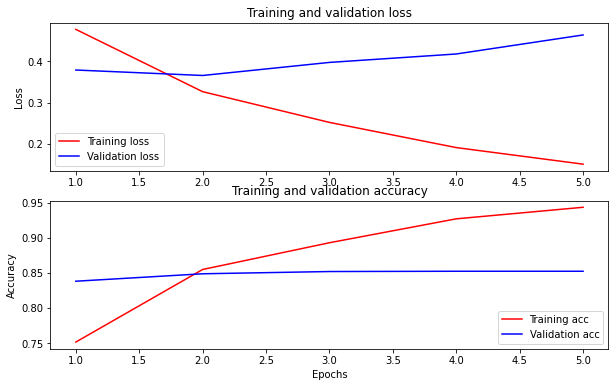

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2021-12-01 12:26:06.207608: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999521
input: The movie was great!           : score: 0.997015
input: The movie was meh.             : score: 0.988535
input: The movie was okish.           : score: 0.079138
input: The movie was terrible...      : score: 0.001622

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999521
input: The movie was great!           : score: 0.997015
input: The movie was meh.             : score: 0.988535
input: The movie was okish.           : score: 0.079138
input: The movie was terrible...      : score: 0.001622



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999521
input: The movie was great!           : score: 0.997015
input: The movie was meh.             : score: 0.988535
input: The movie was okish.           : score: 0.079138
input: The movie was terrible...      : score: 0.001622



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.